# Modelo de inferencia de energia solar 

---
## Sección 1: EDA
En esta seccion se realizara un analisis exploratorio de los datos de las estaciones metereologicas de la argentina, se fucionaran distintos datasets para enriquecer los datos originales con por ejemplo la provincia de la estacion, region, etc

In [2]:
#Se importan todas las librerías necesarias
#Librerías de manejo de datos y genéricas
import os
import requests
import re
import itertools
import geopandas
import numpy as np
import pandas as pd

#Librerías de visualización
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm # para mostrar barras de progreso

from unidecode import unidecode # para eliminar acentos
from pandas.api.types import CategoricalDtype # para manejar tipos de datos categóricos

#Librerías de machine learning
from sklearn.linear_model import Ridge #regresión lineal regularizada
from sklearn.ensemble import RandomForestRegressor # Random Forest Regressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, max_error, mean_squared_error # métricas de rendimiento
from sklearn.svm import SVR # Support Vector Regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # para escalar los datos numéricos
from sklearn.neighbors import NearestNeighbors # para encontrar vecinos más cercanos
from lightgbm import LGBMRegressor # LightGBM Regressor
from sklearn.cluster import KMeans # K-Means Clustering

#Otras librerías
from concurrent.futures import ThreadPoolExecutor, as_completed
from shapely.geometry import Point
from scipy.interpolate import LinearNDInterpolator



In [ ]:
# FUNCIONES UTILITARIAS PARA MEJORAR VISUALIZACIÓN DE TABLAS
def display_nice_table(df, title=None, max_rows=10, max_cols=None, precision=2):
    """
    Función para mostrar tablas de pandas con mejor formato visual
    
    Parámetros:
    - df: DataFrame de pandas
    - title: Título para la tabla (opcional)
    - max_rows: Número máximo de filas a mostrar
    - max_cols: Número máximo de columnas a mostrar
    - precision: Número de decimales para valores numéricos
    """
    # Configurar opciones de pandas para mejor visualización
    with pd.option_context('display.max_rows', max_rows,
                          'display.max_columns', max_cols,
                          'display.precision', precision,
                          'display.float_format', '{:.2f}'.format,
                          'display.width', None,
                          'display.max_colwidth', 20):
        
        if title:
            print(f"\n{'='*60}")
            print(f"{title:^60}")
            print(f"{'='*60}")
            print(f"Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
            print("-" * 60)
        
        # Usar display() para mejor renderizado en Jupyter
        display(df)
        
        if len(df) > max_rows:
            print(f"\n... mostrando solo las primeras {max_rows} filas de {len(df)} totales")

def display_summary_stats(df, title="Estadísticas Descriptivas"):
    """
    Función para mostrar estadísticas descriptivas con mejor formato
    """
    print(f"\n{'='*60}")
    print(f"{title:^60}")
    print(f"{'='*60}")
    
    # Información básica
    print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"💾 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Tipos de datos
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    datetime_cols = df.select_dtypes(include=['datetime']).columns
    
    print(f"🔢 Columnas numéricas: {len(numeric_cols)}")
    print(f"📝 Columnas categóricas: {len(categorical_cols)}")
    print(f"📅 Columnas de fecha: {len(datetime_cols)}")
    
    # Valores nulos
    null_counts = df.isnull().sum()
    null_percentage = (null_counts / len(df)) * 100
    
    if null_counts.sum() > 0:
        print(f"\n⚠️  Valores nulos encontrados:")
        for col in null_counts[null_counts > 0].index:
            print(f"   {col}: {null_counts[col]} ({null_percentage[col]:.1f}%)")
    else:
        print(f"\n✅ Sin valores nulos")

def style_dataframe(df, highlight_nulls=True, color_negative=True):
    """
    Aplica estilos visuales a un DataFrame para mejor presentación
    """
    
    def highlight_null(val):
        return 'background-color: #ffcccc' if pd.isna(val) else ''
    
    def color_negative_values(val):
        if pd.isna(val):
            return ''
        try:
            if float(val) < 0:
                return 'color: red; font-weight: bold'
        except:
            pass
        return ''
    
    styled = df.style
    
    if highlight_nulls:
        styled = styled.applymap(highlight_null)
    
    if color_negative and len(df.select_dtypes(include=[np.number]).columns) > 0:
        styled = styled.applymap(color_negative_values, 
                                subset=df.select_dtypes(include=[np.number]).columns)
    
    # Formato para números
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        styled = styled.format({col: '{:.2f}' for col in numeric_cols})
    
    return styled



def iqr(x):
    """Función para calcular el Rango Intercuartílico."""
    return x.quantile(0.75) - x.quantile(0.25)

def mode(x):
    """Función para obtener la moda (el primer valor si hay múltiples)."""
    return x.mode().iloc[0] if not x.mode().empty else np.nan

def limpiar_texto(texto):
    """Función para limpiar texto, eliminando acentos y caracteres especiales, y convirtiendo a minúsculas."""
    if not isinstance(texto, str):
        return texto
    limpio = unidecode(texto)
    limpio = re.sub(r'[\s-]+', '_', limpio)
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()
print("✅ Funciones de visualización de tablas cargadas correctamente")

✅ Funciones de visualización de tablas cargadas correctamente


In [35]:
# Cargar y procesar los datos de las estaciones meteorológicas de Argentina
# Se cargan los datos de las estaciones meteorológicas de Argentina desde un archivo de texto con formato fijo.
# Se procesan las columnas para extraer la latitud y longitud en formato decimal y se renombran las columnas para facilitar su uso posterior.
df_bases = pd.read_fwf(
    'datos/estaciones_smn.txt', 
    skiprows=2, 
    header=None, 
    encoding='latin-1'
)

nombres_columnas = [
    'nombre_original', 'provincia', 'lat_gr', 'lat_min',
    'lon_gr', 'lon_min', 'altura', 'nro', 'oaci'
]

df_bases.columns = nombres_columnas
df_bases['nombre_original'] = df_bases['nombre_original'].str.strip()
df_bases['provincia'] = df_bases['provincia'].str.strip()
# Convertir latitud y longitud a formato decimal
df_bases['latitud'] = df_bases['lat_gr'] + np.sign(df_bases['lat_gr']) * (df_bases['lat_min'] / 60)
df_bases['longitud'] = df_bases['lon_gr'] + np.sign(df_bases['lon_gr']) * (df_bases['lon_min'] / 60)
# Eliminar columnas que ya no se usan
df_bases = df_bases.drop(columns=['lat_gr', 'lat_min', 'lon_gr', 'lon_min'])
# Se muestra el DataFrame resultante con formato mejorado
display_nice_table(df_bases, 
                  title="🗺️  ESTACIONES METEOROLÓGICAS DE ARGENTINA", 
                  max_rows=8)
display_summary_stats(df_bases)



         🗺️  ESTACIONES METEOROLÓGICAS DE ARGENTINA         
Dimensiones: 120 filas × 7 columnas
------------------------------------------------------------


nombre_original        provincia  altura      nro  oaci  latitud  \
0       BASE BELGRANO II        ANTARTIDA  256.00 89034.00  SAYB   -77.87   
1    BASE CARLINI (EX...        ANTARTIDA   11.00 89053.00  SAYJ   -62.23   
2         BASE ESPERANZA        ANTARTIDA   24.00 88963.00  SAYE   -63.38   
3          BASE MARAMBIO        ANTARTIDA  198.00 89055.00  SAWB   -64.23   
..                   ...              ...     ...      ...   ...      ...   
116  TERMAS DE RIO HO...  SANTIAGO DEL ES  280.00 87127.00  SANR   -27.50   
117      RIO GRANDE B.A.  TIERRA DEL FUEG   22.00 87934.00  SAWE   -53.77   
118         USHUAIA AERO  TIERRA DEL FUEG   57.00 87938.00  SAWH   -54.83   
119         TUCUMAN AERO          TUCUMAN  450.00 87121.00  SANT   -26.83   

     longitud  
0      -34.62  
1      -58.65  
2      -56.98  
3      -56.62  
..        ...  
116    -64.93  
117    -67.75  
118    -68.30  
119    -65.10  

[120 rows x 7 columns]


... mostrando solo las primeras 8 filas de 120 totales

                 Estadísticas Descriptivas                  
📊 Dimensiones: 120 filas × 7 columnas
💾 Memoria utilizada: 0.02 MB
🔢 Columnas numéricas: 4
📝 Columnas categóricas: 3
📅 Columnas de fecha: 0

⚠️  Valores nulos encontrados:
   provincia: 2 (1.7%)
   altura: 2 (1.7%)
   nro: 2 (1.7%)
   oaci: 3 (2.5%)
   latitud: 2 (1.7%)
   longitud: 2 (1.7%)


In [36]:
# En esta sección se cargan los datos de las estaciones meteorológicas de Argentina desde un archivo Excel.
# Se busca la fila que contiene el encabezado correcto y se carga el DataFrame con ese encabezado.
# Luego, se transforma el DataFrame a un formato largo (long format) para facilitar el análisis.
# Finalmente, se limpian los nombres de las variables y se procesan los valores para crear un DataFrame final con las columnas adecuadas.


pd.set_option('display.max_columns', None) # Se configura para mostrar todas las columnas
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)
#Primer se carga del archivo para detectar el encabezado correcto (el exel tiene un encabezado en una fila distinta a la 0)
if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")
        
#Se carga el DataFrame con el encabezado detectado
df = pd.read_excel(ruta_completa, header=header_row_index)
# Se usa melt para transformar el DataFrame a formato largo es decir, cada fila representa un mes y una variable para una estación específica.
# Esto facilita el análisis y la visualización de los datos.
df_largo = df.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# Mapa de nombres de variables a nombres más amigables
mapa_nombres = {
    'Temperatura (°C)': 'temperatura_c',
    'Temperatura máxima (°C)': 'temperatura_maxima_c',
    'Temperatura mínima (°C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitación (mm)': 'precipitacion_mm',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
estaciones_df_final=df_largo['Estación'].unique()
# Se renombra la columna 'Valor Medio de' a 'Variable' y se limpia el texto con el mapa de nombres
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])
# Se limpian los nombres de las estaciones y meses estan llenos de caracteres especiales
df_largo['Estación'] = df_largo['Estación'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)
df_bases['Estación'] = df_bases['nombre_original'].apply(limpiar_texto)
df_bases = df_bases.drop(columns=['nombre_original'])
# Procesamiento de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')

# --- Creación del DataFrame Final ---
columnas_ordenadas = ['Estación', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# Crear el tipo de dato Categórico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)
# se detectaron que hay algunas estaciones con nombres que no coinciden con los de la base de datos de estaciones meteorológicas
# Se corrigen los nombres de las estaciones para que coincidan con los de la base de estaciones meteorológicas
correcciones_estaciones = {
    'coronel_pringles_aero': 'coronel_pringles_aero',
    'el_trebol': 'el_trebol',
    'presidencia_roque_saenz_pena_aero': 'presidencia_roque_saenz_pena_a', 
    'san_miguel': 'san_miguel',
}

df_final['Estación'] = df_final['Estación'].map(correcciones_estaciones).fillna(df_final['Estación'])
# Se unen los DataFrames df_final y df_bases para enriquecer los datos con la información de las estaciones meteorológicas
# Se usa un merge para combinar los DataFrames por la columna 'Estación'.
# El resultado es un DataFrame que contiene la información de las estaciones meteorológicas junto con los datos climáticos.
df_enriquecido = pd.merge(
    left=df_final,
    right=df_bases, 
    on='Estación',
    how='left'
)
# Se mapea las provincias a regiones para facilitar el análisis regional
mapa_regiones = {
    'jujuy': 'NOA',
    'salta': 'NOA',
    'formosa': 'NEA',
    'misiones': 'NEA',
    'tucuman': 'NOA',
    'santiago del es': 'NOA',
    'chaco': 'NEA',
    'corrientes': 'NEA',
    'catamarca': 'NOA',
    'la rioja': 'NOA',
    'cordoba': 'Pampeana',
    'santa fe': 'Pampeana',
    'san juan': 'Cuyo',
    'entre rios': 'NEA',
    'mendoza': 'Cuyo',
    'san luis': 'Cuyo',
    'la pampa': 'Pampeana',
    'buenos aires': 'Pampeana',
    'capital federal': 'Pampeana',
    'neuquen': 'Patagonia',
    'rio negro': 'Patagonia',
    'chubut': 'Patagonia',
    'santa cruz': 'Patagonia',
    'tierra del fueg': 'Patagonia', 
    'antartida': 'Antártida'
}
# Creamos la columna 'region'
df_enriquecido['region'] = df_enriquecido['provincia'].str.lower().map(mapa_regiones)
df_enriquecido.to_csv('datos/dataframe_enriquecido.csv', index=False)


¡Encabezado detectado en la fila (0-indexada): 4!


In [38]:
# Esto se hizo para verificar que habia estaciones que no coincidan los nombres del dataset metereologico con el dataset de bases
estaciones_final_limpias = set(df_final['Estación'].unique())
estaciones_bases_limpias = set(df_bases['Estación'].unique())

no_coinciden_en_final = sorted(list(estaciones_final_limpias - estaciones_bases_limpias))
no_coinciden_en_bases = sorted(list(estaciones_bases_limpias - estaciones_final_limpias))

print("\n---")
print("Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):")
if no_coinciden_en_final:
    for nombre in no_coinciden_en_final:
        print(f"- {nombre}")
else:
    print("¡Todos los nombres limpios de df_final['Estación'] se encuentran en df_bases['Estación']!")

print("\n---")
print("Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):")
if no_coinciden_en_bases:
    for nombre in no_coinciden_en_bases:
        print(f"- {nombre}")
else:
    print("¡Todos los nombres limpios de df_bases['Estación'] se encuentran en df_final['Estación']!")
print("---")


---
Estaciones en df_final (LIMPIAS) que NO se encuentran en df_bases (LIMPIAS):
- coronel_pringles_aero
- el_trebol
- san_miguel

---
Estaciones en df_bases (LIMPIAS) que NO se encuentran en df_final (LIMPIAS):
- benito_juarez
- campo_de_mayo_aero
- chapelco_aero
- chepes
- ero
- escuela_de_aviacion_militar_ae
- ituzaingo
- mariano_moreno_aero
- mercedes_aero_ctes
- merlo_aero
- metan
- moron_aero
- paso_de_indios
- puerto_madryn_aero
- rafaela_aero
- rivadavia
- ro
- santa_cruz_aero
- santa_rosa_de_conlara_aero
- sunchales_aero
- termas_de_rio_hondo_aero
- trenque_lauquen
- uspallata
- victorica
- villa_gesell_aero
---


## Tabla con la descricion de las columnas que tiene el dataset enriquesido.
| Variable      | Descripción                                                                 |
| :------------ | :-------------------------------------------------------------------------- |
| `Estación`    | Nombre de la estación meteorológica.                                        |
| `Variable`    | Tipo de variable climática medida (ej., temperatura, humedad).             |
| `Mes`         | Mes en que se registró el valor de la variable.                             |
| `Valor`       | Valor numérico de la variable medida.                                       |
| `provincia`   | Provincia donde se encuentra la estación meteorológica.                     |
| `altura`      | Altitud de la estación meteorológica en metros sobre el nivel del mar.      |
| `nrooac`      | Número o código de identificación de la estación según la OACI (Organización de Aviación Civil Internacional) |
| `latitud`     | Latitud geográfica de la estación en grados decimales.                     |
| `longitud`    | Longitud geográfica de la estación en grados decimales.                    |
| `region`      | Región geográfica a la que pertenece la estación.                           |

In [41]:
# Se muestra el DataFrame enriquecido con formato mejorado
display_nice_table(df_enriquecido, 
                  title="🌡️  DATOS METEOROLÓGICOS ENRIQUECIDOS", 
                  max_rows=10)
display_summary_stats(df_enriquecido)


           🌡️  DATOS METEOROLÓGICOS ENRIQUECIDOS            
Dimensiones: 9408 filas × 11 columnas
------------------------------------------------------------


Estación             Variable  Mes  Valor  provincia  altura  \
0     la_quiaca_observ...        temperatura_c  ene  13.20      JUJUY 3459.00   
1     la_quiaca_observ...  temperatura_maxi...  ene  20.60      JUJUY 3459.00   
2     la_quiaca_observ...  temperatura_mini...  ene   7.70      JUJUY 3459.00   
3     la_quiaca_observ...  humedad_relativa...  ene  62.60      JUJUY 3459.00   
4     la_quiaca_observ...  velocidad_viento...  ene   6.50      JUJUY 3459.00   
...                   ...                  ...  ...    ...        ...     ...   
9403      base_san_martin  humedad_relativa...  dic  73.20  ANTARTIDA    7.00   
9404      base_san_martin  velocidad_viento...  dic    NaN  ANTARTIDA    7.00   
9405      base_san_martin    nubosidad_octavos  dic   6.20  ANTARTIDA    7.00   
9406      base_san_martin     precipitacion_mm  dic    NaN  ANTARTIDA    7.00   
9407      base_san_martin  frecuencia_dias_...  dic    NaN  ANTARTIDA    7.00   

          nro  oaci  latitud  longitud     region  
0    87007.00  SASQ   -22.10    -65.60        NOA  
1    87007.00  SASQ   -22.10    -65.60        NOA  
2    87007.00  SASQ   -22.10    -65.60        NOA  
3    87007.00  SASQ   -22.10    -65.60        NOA  
4    87007.00  SASQ   -22.10    -65.60        NOA  
...       ...   ...      ...       ...        ...  
9403 89066.00  SAYS   -68.12    -67.10  Antártida  
9404 89066.00  SAYS   -68.12    -67.10  Antártida  
9405 89066.00  SAYS   -68.12    -67.10  Antártida  
9406 89066.00  SAYS   -68.12    -67.10  Antártida  
9407 89066.00  SAYS   -68.12    -67.10  Antártida  

[9408 rows x 11 columns]


... mostrando solo las primeras 10 filas de 9408 totales

                 Estadísticas Descriptivas                  
📊 Dimensiones: 9408 filas × 11 columnas
💾 Memoria utilizada: 3.05 MB
🔢 Columnas numéricas: 5
📝 Columnas categóricas: 6
📅 Columnas de fecha: 0

⚠️  Valores nulos encontrados:
   Valor: 853 (9.1%)
   provincia: 288 (3.1%)
   altura: 288 (3.1%)
   nro: 288 (3.1%)
   oaci: 384 (4.1%)
   latitud: 288 (3.1%)
   longitud: 288 (3.1%)
   region: 288 (3.1%)


In [24]:
#Se verifica la información del DataFrame enriquecido
df_enriquecido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Estación   9408 non-null   object  
 1   Variable   9408 non-null   object  
 2   Mes        9408 non-null   category
 3   Valor      8555 non-null   float64 
 4   provincia  9120 non-null   object  
 5   altura     9120 non-null   float64 
 6   nro        9120 non-null   float64 
 7   oaci       9024 non-null   object  
 8   latitud    9120 non-null   float64 
 9   longitud   9120 non-null   float64 
 10  region     9120 non-null   object  
dtypes: category(1), float64(5), object(5)
memory usage: 744.7+ KB


In [25]:
# Se verifican los tipos de datos del DataFrame enriquecido
df_enriquecido.dtypes

Estación       object
Variable       object
Mes          category
Valor         float64
provincia      object
altura        float64
nro           float64
oaci           object
latitud       float64
longitud      float64
region         object
dtype: object

In [26]:
# Se verifica la variable 'Mes' para ver los meses únicos presentes en el DataFrame enriquecido
df_enriquecido['Mes'].unique()

['ene', 'feb', 'mar', 'abr', 'may', ..., 'ago', 'sep', 'oct', 'nov', 'dic']
Length: 12
Categories (12, object): ['ene' < 'feb' < 'mar' < 'abr' ... 'sep' < 'oct' < 'nov' < 'dic']

In [27]:
# Se verifica si hay valores nulos en el DataFrame enriquecido porcentualmente
df_enriquecido.isna().mean().round(4)*100

Estación     0.00
Variable     0.00
Mes          0.00
Valor        9.07
provincia    3.06
altura       3.06
nro          3.06
oaci         4.08
latitud      3.06
longitud     3.06
region       3.06
dtype: float64

/tmp/ipykernel_87470/1307914299.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_enriquecido.pivot_table(


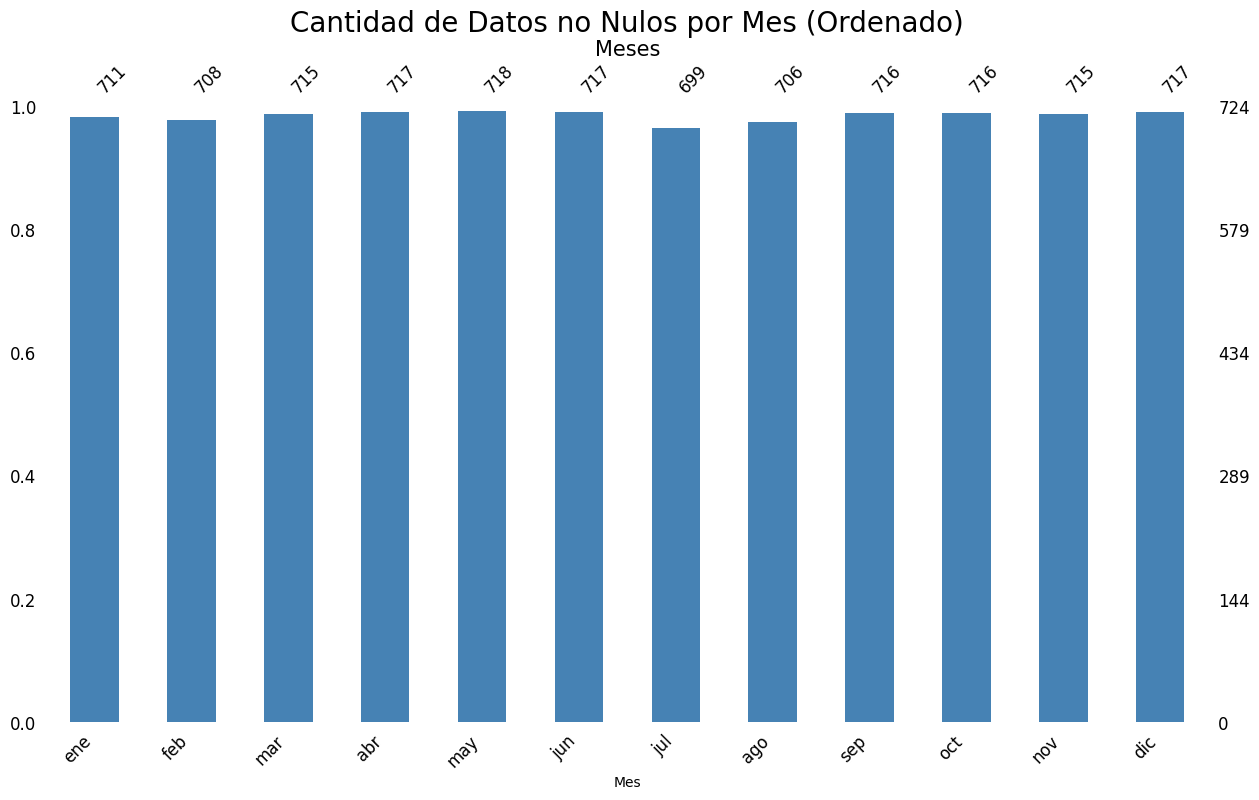

In [14]:
# En esta sección se crea un gráfico de barras que muestra la cantidad de datos no nulos por mes para cada variable en el DataFrame enriquecido.
# Se utiliza la función pivot_table de pandas para reorganizar los datos y luego se usa missingno para visualizar la cantidad de datos no nulos.
# El gráfico resultante permite identificar rápidamente los meses con más o menos datos disponibles para cada variable en las estaciones meteorológicas.

df_pivoted = df_enriquecido.pivot_table(
    index=['Estación', 'Variable'],
    columns='Mes',
    values='Valor'
)
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


<Axes: >

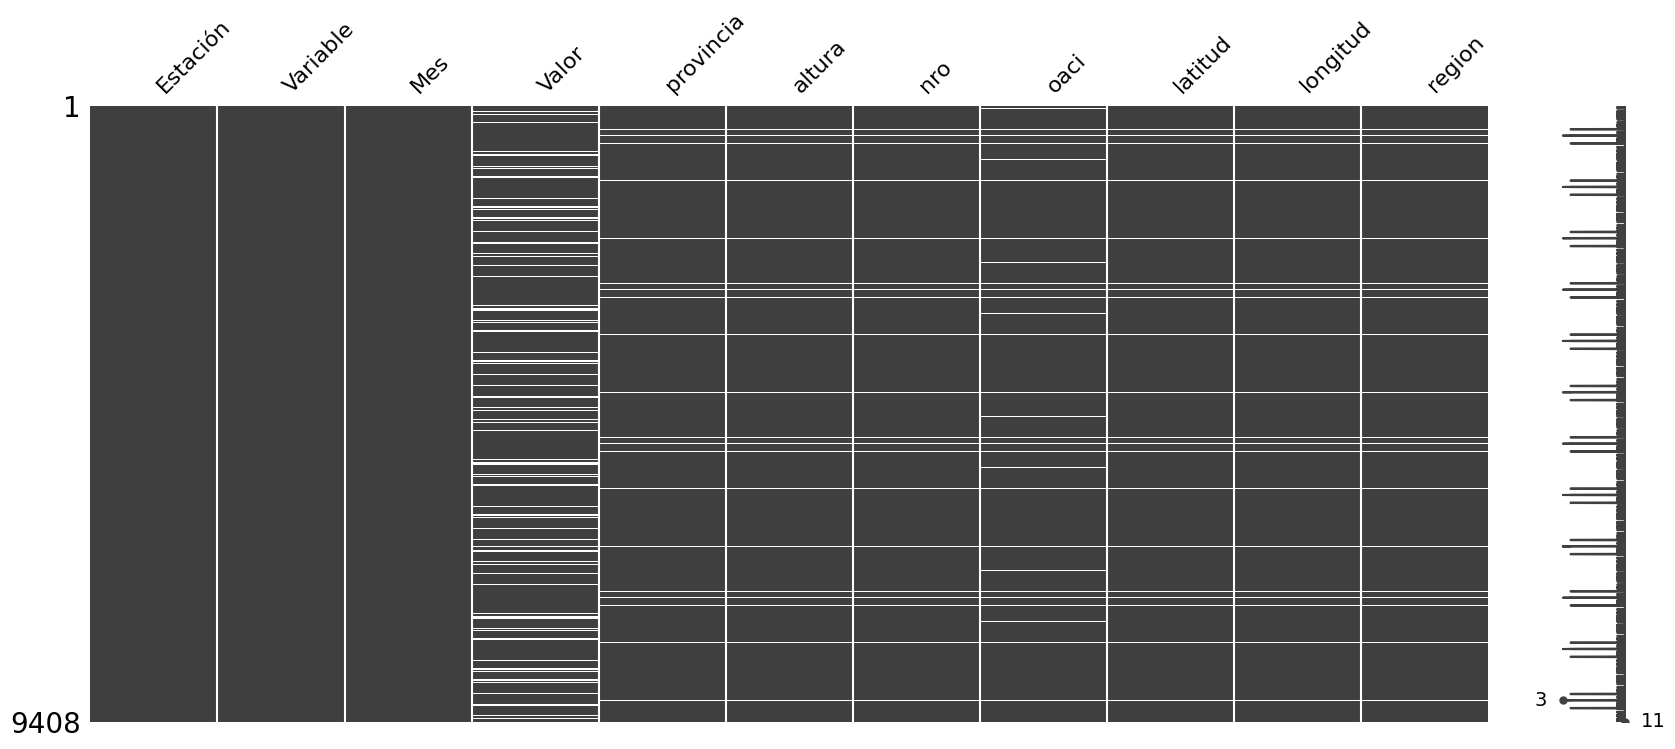

In [17]:
# Otra forma de visualizar la cantidad de datos no nulos por mes para cada variable en el DataFrame enriquecido es utilizando un gráfico de matriz de missingno.
msno.matrix(df_enriquecido , figsize=(20,8))

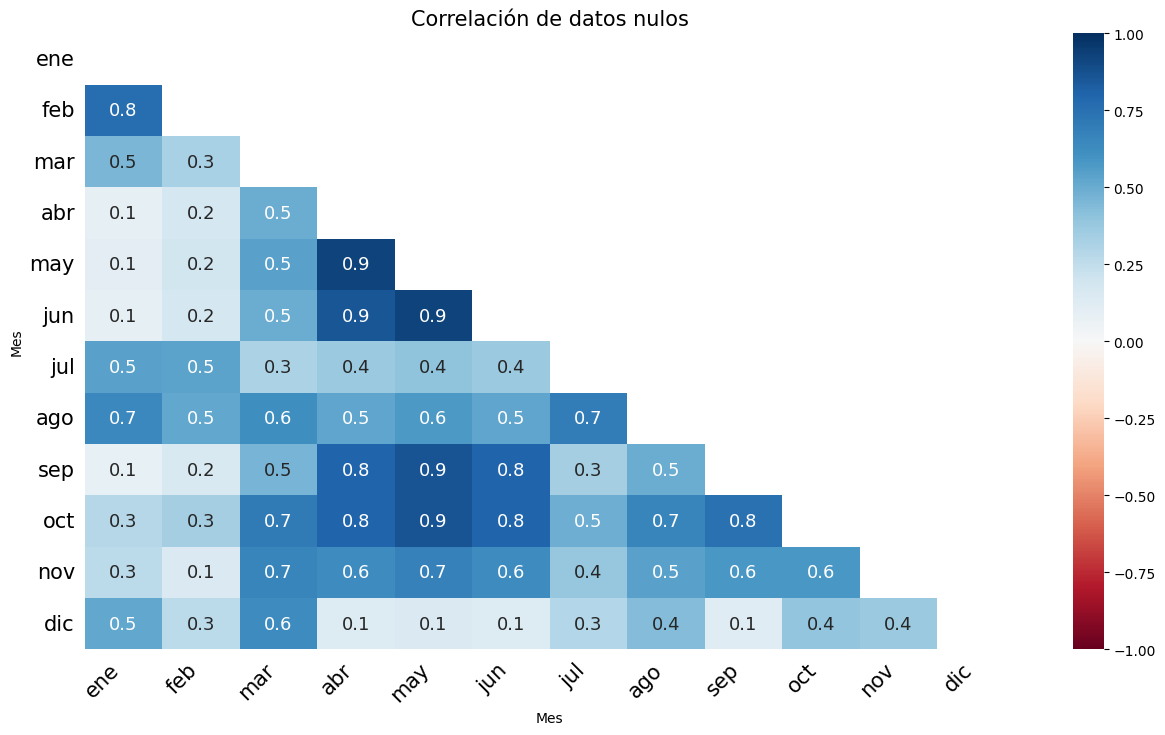

In [19]:
# Correlación de datos nulos
# En esta sección se crea un gráfico de calor que muestra la correlación entre los datos nulos en el DataFrame enriquecido.
# Se utiliza la función heatmap de missingno para visualizar
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

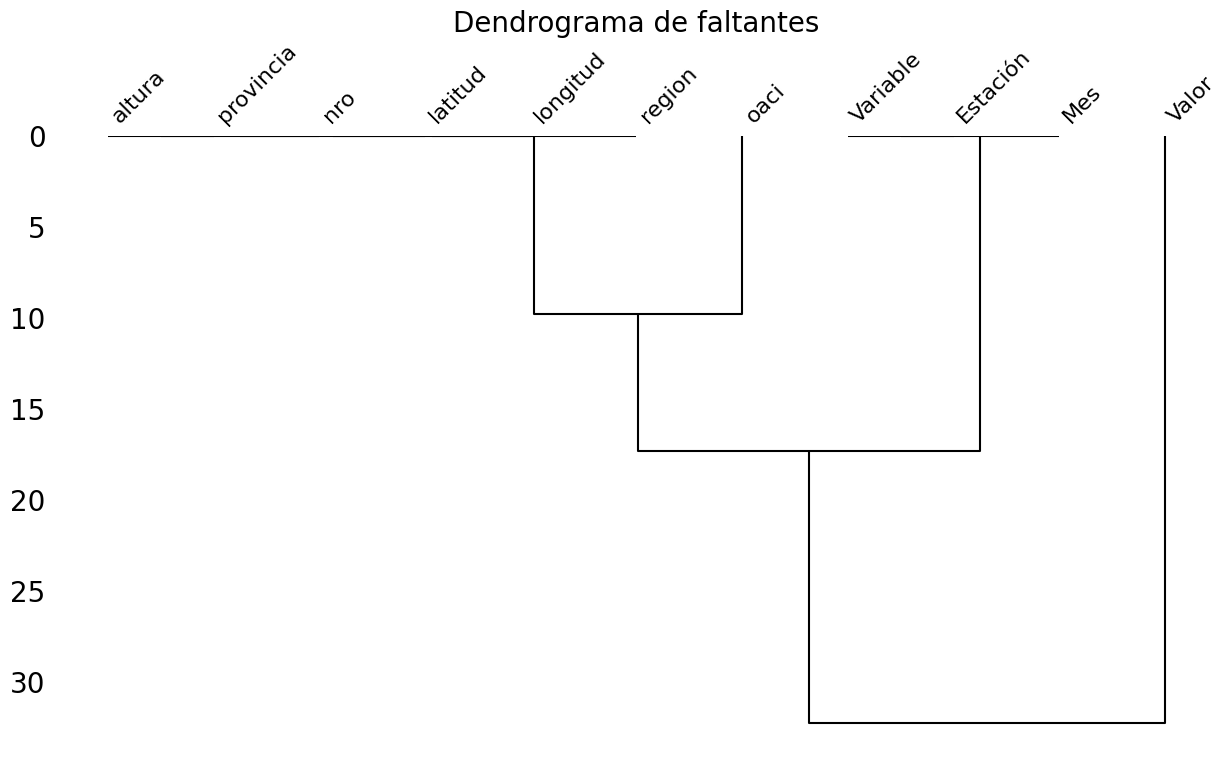

In [ ]:
#Se utiliza un dendrograma para visualizar la estructura de los datos nulos en el DataFrame enriquecido.
# El dendrograma permite identificar patrones en la distribución de los datos faltantes y agrupar las variables que tienen un comportamiento similar en cuanto a la presencia de datos nulos.
msno.dendrogram(df_enriquecido, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [39]:
# En esta sección se define una función para calcular el porcentaje de valores nulos por grupo en el DataFrame enriquecido agrupado por variables.
# Esto sirve para identificar qué grupos tienen una mayor proporción de datos faltantes en una columna específica.
# Lo que no da una idea si los nulos estan realacionados con algun grupo en particular, por ejemplo, si hay más nulos en una estación específica o en un mes específico.
# Lo que sirver para identificar patrones de datos faltantes en el DataFrame enriquecido y el tipo de valores nulos que se presentan.

def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    return agrupar_nulos

# Ejemplos de análisis para 'Valor' (re-generamos para tener los DataFrames)
nulos_valor_por_estacion = nulos_por_grupo(df_enriquecido, 'Estación', 'Valor')
nulos_valor_por_variable = nulos_por_grupo(df_enriquecido, 'Variable', 'Valor')
nulos_valor_por_provincia = nulos_por_grupo(df_enriquecido, 'provincia', 'Valor')
nulos_valor_por_estacion_variable = nulos_por_grupo(df_enriquecido, ['Estación', 'Variable'], 'Valor')

# --- Cómo ordenar de mayor a menor ---

print("🔍 ANÁLISIS DE VALORES NULOS EN EL DATASET")
print("="*60)

nulos_age_por_estacion_ordenado = nulos_valor_por_estacion.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
display_nice_table(nulos_age_por_estacion_ordenado, 
                  title="📍 NULOS POR ESTACIÓN", 
                  max_rows=15)

nulos_valor_por_variable_ordenado = nulos_valor_por_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
display_nice_table(nulos_valor_por_variable_ordenado, 
                  title="🌡️ NULOS POR VARIABLE CLIMÁTICA", 
                  max_rows=10)

nulos_valor_por_provincia_ordenado = nulos_valor_por_provincia.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
display_nice_table(nulos_valor_por_provincia_ordenado, 
                  title="🗺️ NULOS POR PROVINCIA", 
                  max_rows=15)

nulos_valor_por_estacion_variable_ordenado = nulos_valor_por_estacion_variable.sort_values(
    by='porcentaje_nulos_Valor',
    ascending=False
)
display_nice_table(nulos_valor_por_estacion_variable_ordenado, 
                  title="🔗 NULOS POR ESTACIÓN × VARIABLE", 
                  max_rows=20)

🔍 ANÁLISIS DE VALORES NULOS EN EL DATASET

                    📍 NULOS POR ESTACIÓN                    
Dimensiones: 98 filas × 2 columnas
------------------------------------------------------------


Estación  porcentaje_nulos_Valor
4      base_belgrano_ii                50.00   
7         base_marambio                47.92   
55                obera                47.92   
6        base_esperanza                46.88   
9       base_san_martin                46.88   
..                  ...                  ...   
85     sauce_viejo_aero                 0.00   
83      santa_rosa_aero                 0.00   
91         tucuman_aero                 0.00   
96   villa_dolores_aero                 0.00   
97  villa_reynolds_aero                 0.00   

[98 rows x 2 columns]


... mostrando solo las primeras 15 filas de 98 totales

              🌡️ NULOS POR VARIABLE CLIMÁTICA               
Dimensiones: 8 filas × 2 columnas
------------------------------------------------------------


Variable  porcentaje_nulos_Valor
7  velocidad_viento...                39.80   
0  frecuencia_dias_...                 9.78   
3     precipitacion_mm                 9.78   
1  humedad_relativa...                 5.61   
6  temperatura_mini...                 4.42   
5  temperatura_maxi...                 1.53   
2    nubosidad_octavos                 0.85   
4        temperatura_c                 0.77


                   🗺️ NULOS POR PROVINCIA                   
Dimensiones: 25 filas × 2 columnas
------------------------------------------------------------


provincia  porcentaje_nulos_Valor
0         ANTARTIDA                44.97   
4             CHACO                18.75   
14         MISIONES                15.10   
20       SANTA CRUZ                13.89   
12         LA RIOJA                12.15   
..              ...                  ...   
9           FORMOSA                 0.00   
15          NEUQUEN                 0.00   
19         SAN LUIS                 0.00   
22  SANTIAGO DEL ES                 0.00   
24          TUCUMAN                 0.00   

[25 rows x 2 columns]


... mostrando solo las primeras 15 filas de 25 totales

              🔗 NULOS POR ESTACIÓN × VARIABLE               
Dimensiones: 784 filas × 3 columnas
------------------------------------------------------------


Estación             Variable  porcentaje_nulos_Valor
67        base_orcadas     precipitacion_mm               100.00   
263  general_pico_aero  velocidad_viento...               100.00   
64        base_orcadas  frecuencia_dias_...               100.00   
63       base_marambio  velocidad_viento...               100.00   
327      la_plata_aero  velocidad_viento...               100.00   
..                 ...                  ...                  ...   
294             jachal  temperatura_mini...                 0.00   
296         jujuy_aero  frecuencia_dias_...                 0.00   
297         jujuy_aero  humedad_relativa...                 0.00   
298         jujuy_aero    nubosidad_octavos                 0.00   
286        iguazu_aero  temperatura_mini...                 0.00   

[784 rows x 3 columns]


... mostrando solo las primeras 20 filas de 784 totales



# Tipos de datos faltantes

### 1. MAR (Missing at Random)
* **Qué es:** la falta del dato se explica por otra variable que sí podemos observar.
* **Ejemplo:** la **velocidad del viento** falta por completo en la estación **Orán Aero**, probablemente porque esa estación no tenía el equipamiento necesario. La ausencia depende de la variable `Estación`.

### 2. MNAR (Missing Not at Random)
* **Qué es:** la falta del dato es causada por el propio valor que no se pudo medir.
* **Ejemplo:** un termómetro que se congela y deja de reportar datos solo cuando la temperatura es extremadamente baja. La ausencia depende del valor extremo que no se registró.

### 3. MCAR (Missing Completely at Random)
* **Qué es:** la ausencia es puramente accidental y no tiene relación con ninguna variable.
* **Ejemplo:** un error humano al anotar un único dato al azar. Es poco probable que explique los patrones sistemáticos de tus datos.

---

# Interpretación detallada de los nulos por grupos

El orden de los resultados por porcentaje de nulos ofrece una visión clara y rápida de dónde se concentran los valores faltantes en la columna `Valor`. A continuación, se analiza cada agrupación.

---

## Nulos en 'Valor' por estación


### Análisis
Se observa una clara concentración de nulos en las **estaciones antárticas** (`Base Belgrano II`, `Base Marambio`, `Base Esperanza`, `Base San Martín`) y `Obera`, con porcentajes de nulos extremadamente altos (entre 46.8% y 50%). Esto sugiere problemas crónicos de recolección o transmisión de datos debido a su ubicación remota o condiciones extremas. En contraste, muchas estaciones presentan un 0% de nulos.

### Implicación
Los datos **no son MCAR** (Missing Completely At Random). La ausencia de datos en `Valor` está fuertemente condicionada por la `Estación`. Es más probable que sean **MNAR** (Missing Not At Random), porque las fallas en los equipos se relacionan directamente con las condiciones extremas que se intentan medir.

---

## Nulos en 'Valor' por variable


### Análisis
Esta tabla es muy reveladora. La variable **`velocidad_viento_kmh` se destaca de forma drástica con casi un 40% de nulos**. Las variables de precipitación también tienen un porcentaje notablemente alto (casi 10%), mientras que las de temperatura y nubosidad presentan muy pocos nulos.

### Implicación
Nuevamente, los datos **no son MCAR**. La probabilidad de un valor nulo en `Valor` depende fuertemente de la `Variable` que se mide. Este es un fuerte indicio de **MAR**, donde la ausencia se explica por el tipo de medición. Por ejemplo, los anemómetros (medidores de viento) podrían ser más propensos a fallar que otros sensores.

---

## Nulos en 'Valor' por provincia


### Análisis
La provincia de **Antártida** es, con diferencia, la que presenta la mayor proporción de nulos (casi 45%), lo cual es consistente con el análisis por estación. Le siguen **Chaco** y **Misiones**. Por otro lado, un gran número de provincias no tienen ningún valor nulo.

### Implicación
Esto confirma que los datos **no son MCAR**. La `provincia` de origen es un factor muy importante que explica la presencia de nulos.

---

## Nulos en 'Valor' por estación y variable

### Análisis
Esta tabla ofrece la prueba más contundente. Vemos que combinaciones específicas de `Estación` y `Variable` tienen un **100% de nulos**.

### Implicación
Definitivamente, los datos **no son MCAR**. La ausencia es **sistemática** y depende de la combinación de *dónde* (`Estación`) y *qué* (`Variable`) se mide. Esto es un caso claro de **MAR** e incluso podría tener componentes de **MNAR**, si la falta de registro se debe a que la medición es imposible de obtener en ciertas condiciones.

---

## Conclusión general

Con base en todos los análisis, podemos afirmar con alta confianza que los datos faltantes en la columna `Valor` **no son MCAR**. La distribución de los nulos es altamente dependiente de la `Estación` y de la `Variable`.

Esto indica que el mecanismo de pérdida es **MAR (Missing At Random)**, ya que la probabilidad de que un valor falte se relaciona de forma sistemática con otra información que sí tenemos en el conjunto de datos.


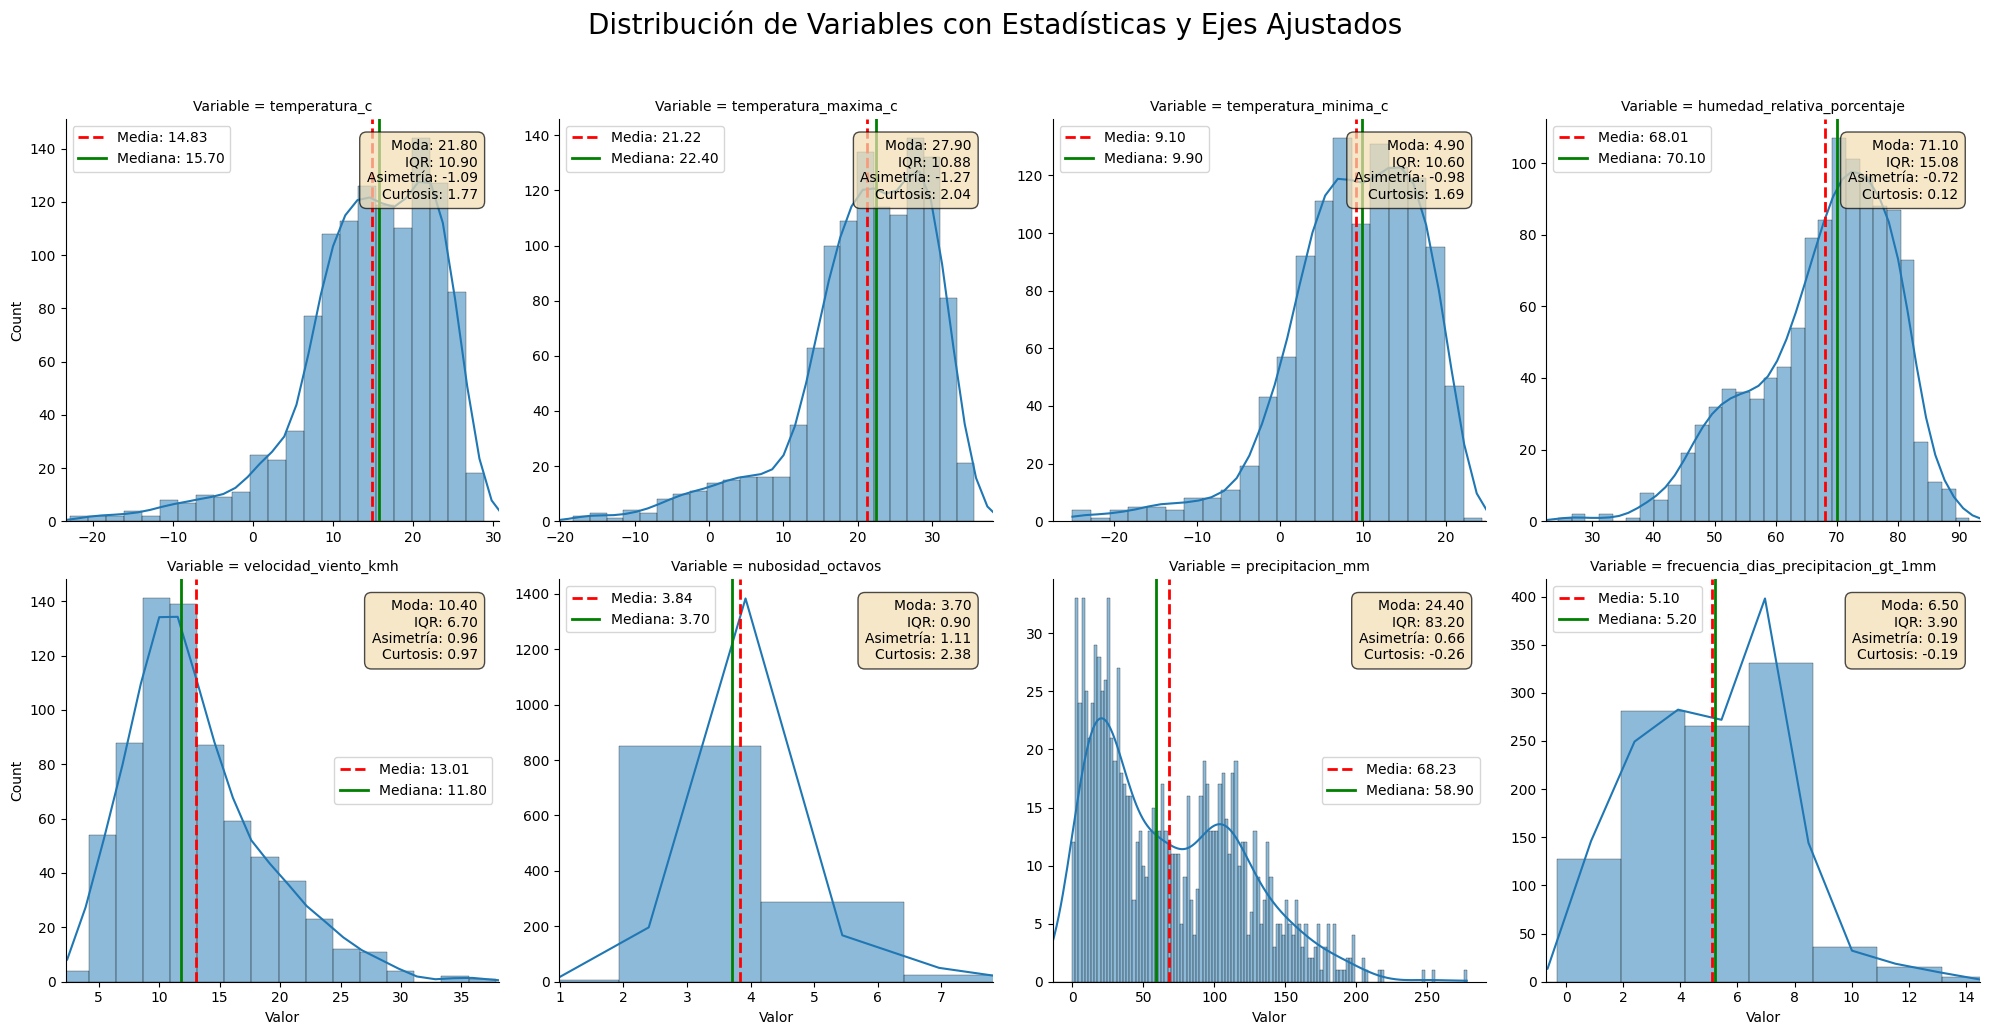

In [ ]:
# En esta sección se calculan estadísticas generales para cada variable en el DataFrame enriquecido.
# Se agrupan los datos por 'Variable' y se calculan estadísticas como media, mediana, moda, rango intercuartílico (IQR), asimetría de Pearson, curtosis de Fisher, mínimo y máximo.
# Estas estadísticas proporcionan una visión general de la distribución de los datos para cada variable, lo que es útil para entender su comportamiento y detectar posibles anomal
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max') 
)

g = sns.displot(
    data=df_enriquecido,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]
    stats_variable = estadisticas_generales.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.05
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        # Se centran los textos de las estadísticas en la parte superior derecha del gráfico
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle('Distribución de Variables con Estadísticas y Ejes Ajustados', y=1.03, fontsize=20)
g.tight_layout()
plt.show()

--- Estadísticas para la provincia de: MENDOZA ---
                                          media  mediana  moda     iqr  asimetria_pearson  curtosis_fisher  minimo  maximo
Variable                                                                                                                  
frecuencia_dias_precipitacion_gt_1mm   2.933333     2.95   2.8   1.800           0.066931        -0.632993     0.6     5.4
humedad_relativa_porcentaje           56.086667    54.10  53.8  13.350           0.007384        -1.014701    40.0    70.4
nubosidad_octavos                      2.993333     2.95   2.7   0.500           0.495182        -0.135989     2.3     4.0
precipitacion_mm                      24.185000    23.85   3.1  20.650           0.339670        -0.806592     3.1    54.2
temperatura_c                         15.586667    15.95   7.4  10.725          -0.056774        -1.272642     3.8    25.9
temperatura_maxima_c                  23.191667    23.45  15.3  10.650          -0.05797

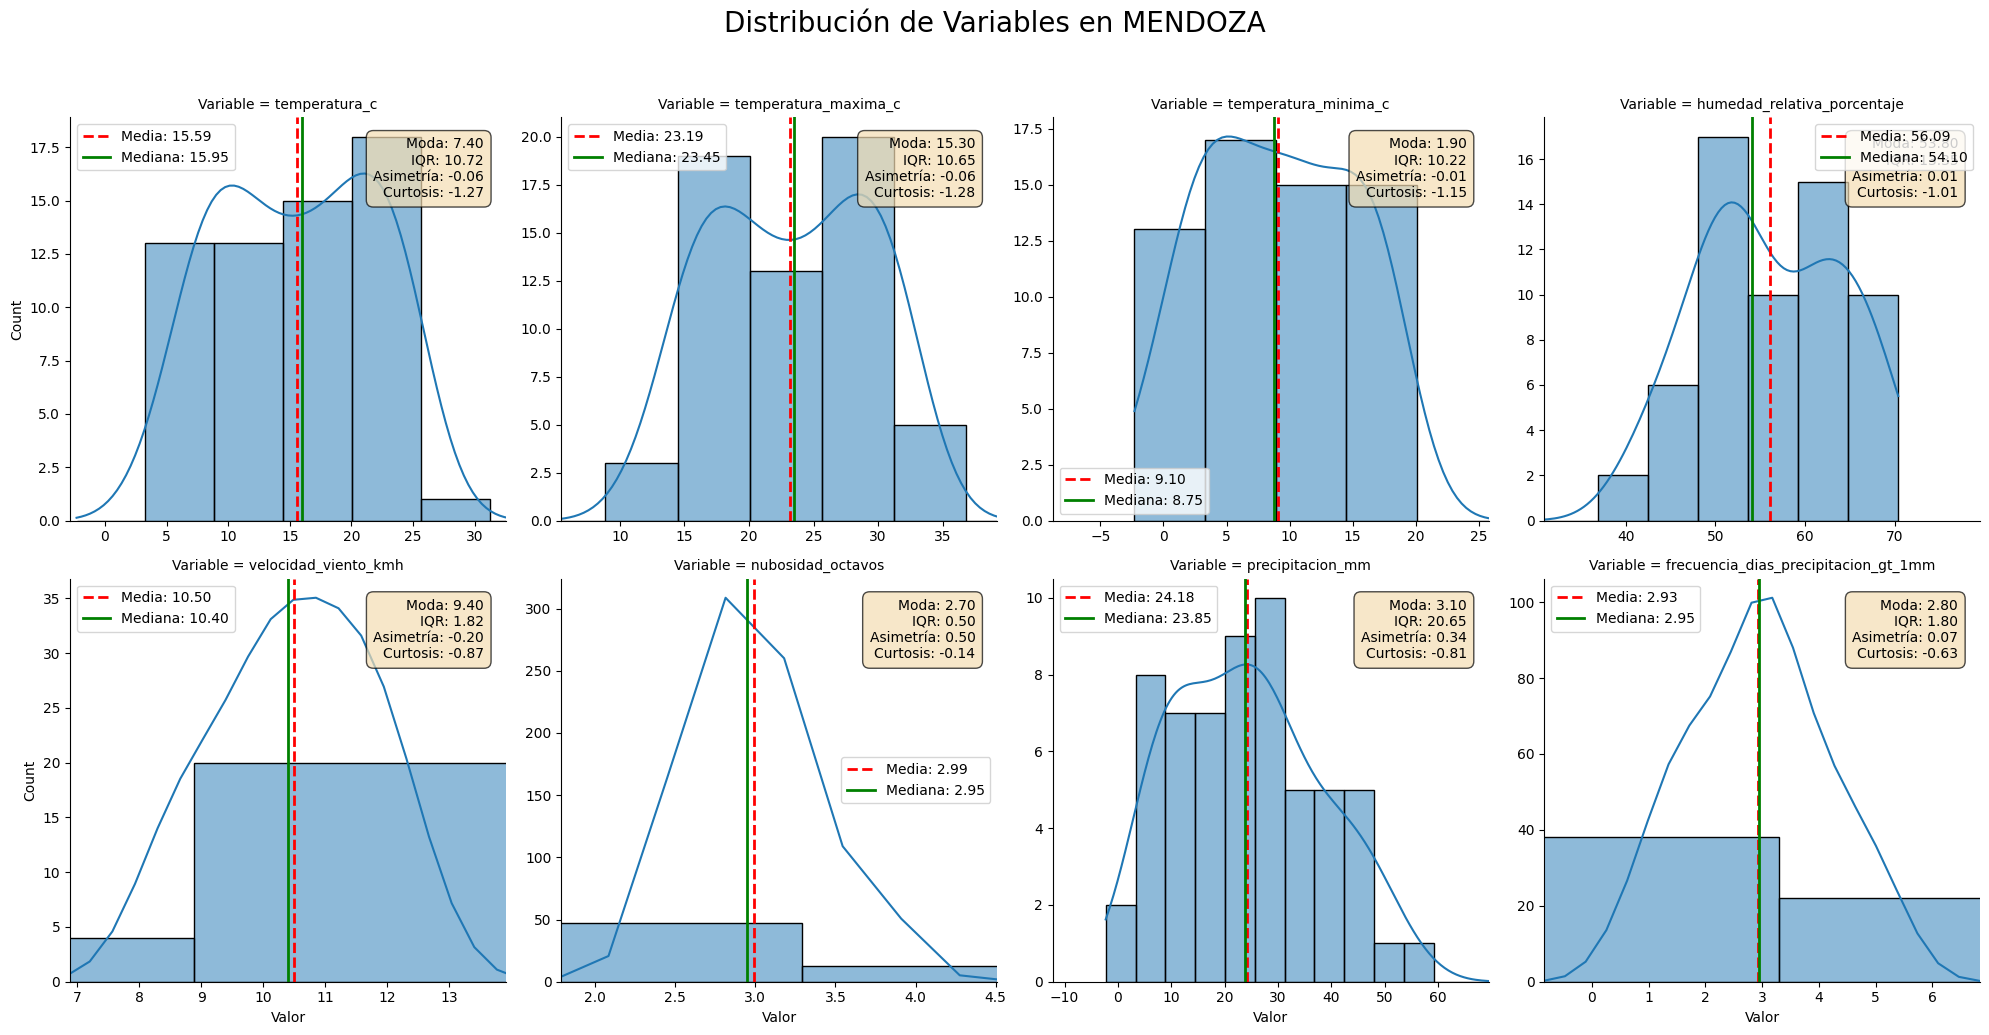

In [ ]:
# Se analizan las estadísticas para una provincia específica, en este caso 'MENDOZA'.
provincia_seleccionada = 'MENDOZA'  # Cambiar esto por la provincia que quieras analizar
df_provincia = df_enriquecido[df_enriquecido['provincia'] == provincia_seleccionada]

estadisticas_provincia = df_provincia.groupby('Variable').agg(
    media=('Valor', 'mean'),
    mediana=('Valor', 'median'),
    moda=('Valor', mode),
    iqr=('Valor', iqr),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max')
)

print(f"--- Estadísticas para la provincia de: {provincia_seleccionada} ---")
print(estadisticas_provincia)


g = sns.displot(
    data=df_provincia,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_variable = titulo.split(' = ')[1]

    stats_variable = estadisticas_provincia.loc[nombre_variable]

    if not stats_variable.empty:
        min_val = stats_variable['minimo']
        max_val = stats_variable['maximo']
        padding = (max_val - min_val) * 0.30
        if padding == 0: padding = 1 
        ax.set_xlim(min_val - padding, max_val + padding)
        
        media = stats_variable['media']
        mediana = stats_variable['mediana']
        moda = stats_variable['moda']
        r_iqr = stats_variable['iqr']
        asim = stats_variable['asimetria_pearson']
        curt = stats_variable['curtosis_fisher']
        
        ax.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
        
        texto_stats = (
            f"Moda: {moda:.2f}\n"
            f"IQR: {r_iqr:.2f}\n"
            f"Asimetría: {asim:.2f}\n"
            f"Curtosis: {curt:.2f}"
        )
        
        ax.text(0.95, 0.95, texto_stats,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()

g.fig.suptitle(f'Distribución de Variables en {provincia_seleccionada}', y=1.03, fontsize=20)
g.tight_layout()
plt.show()


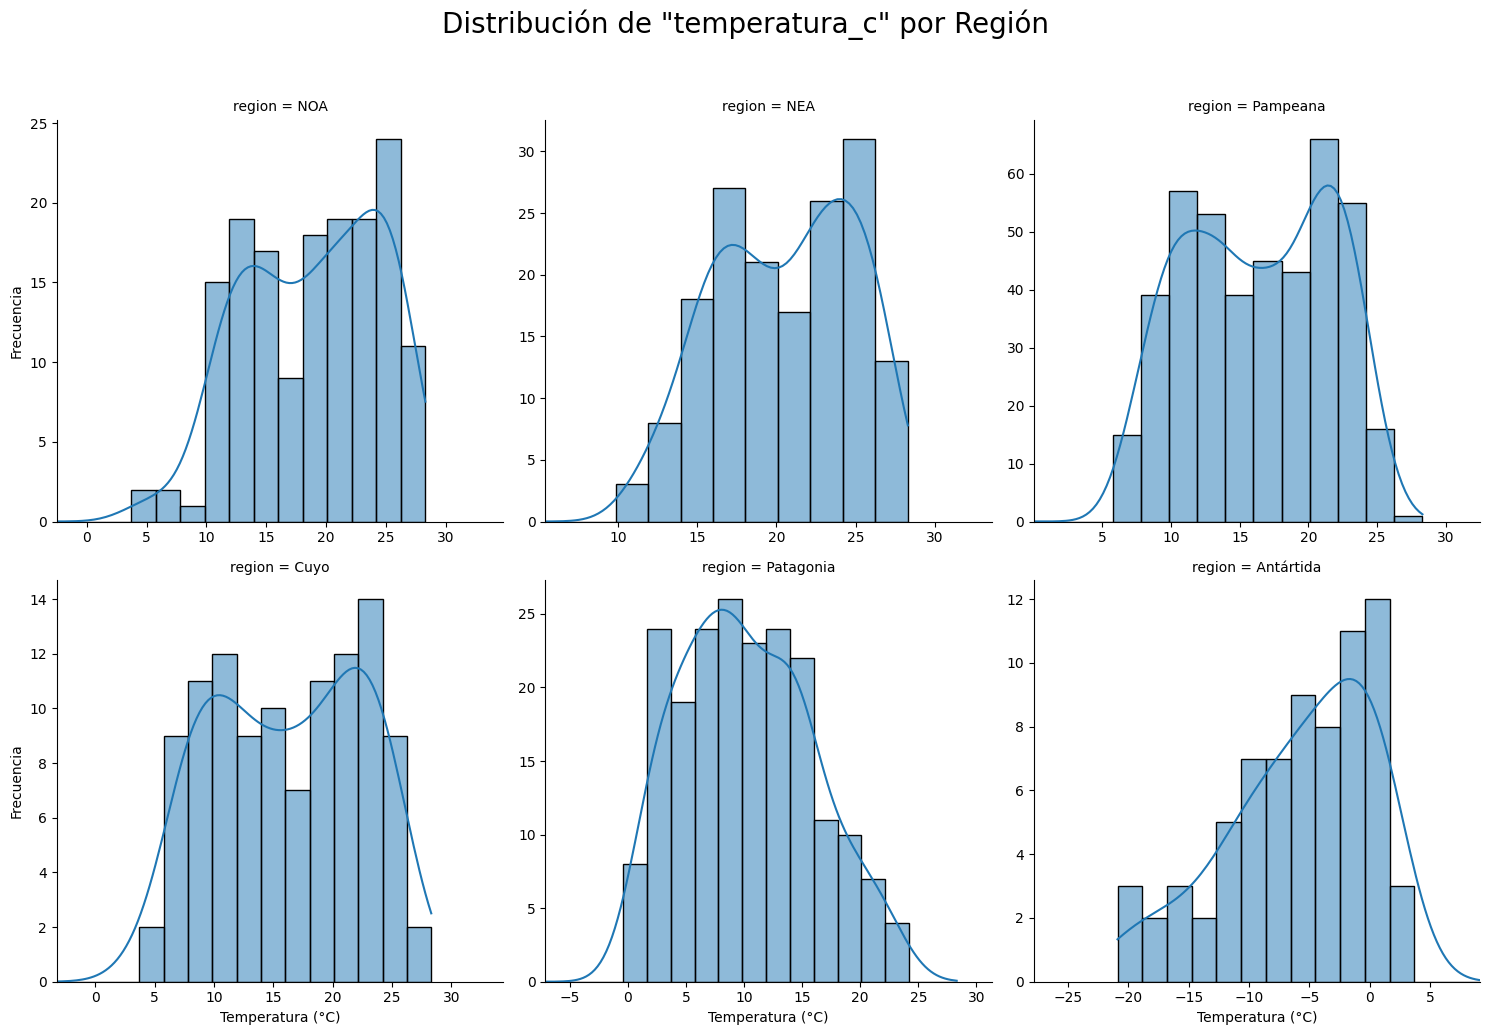

In [ ]:
# Este análisis se centra en la distribución de una variable específica (en este caso, 'temperatura_c') por región.
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'temperatura_c'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (°C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

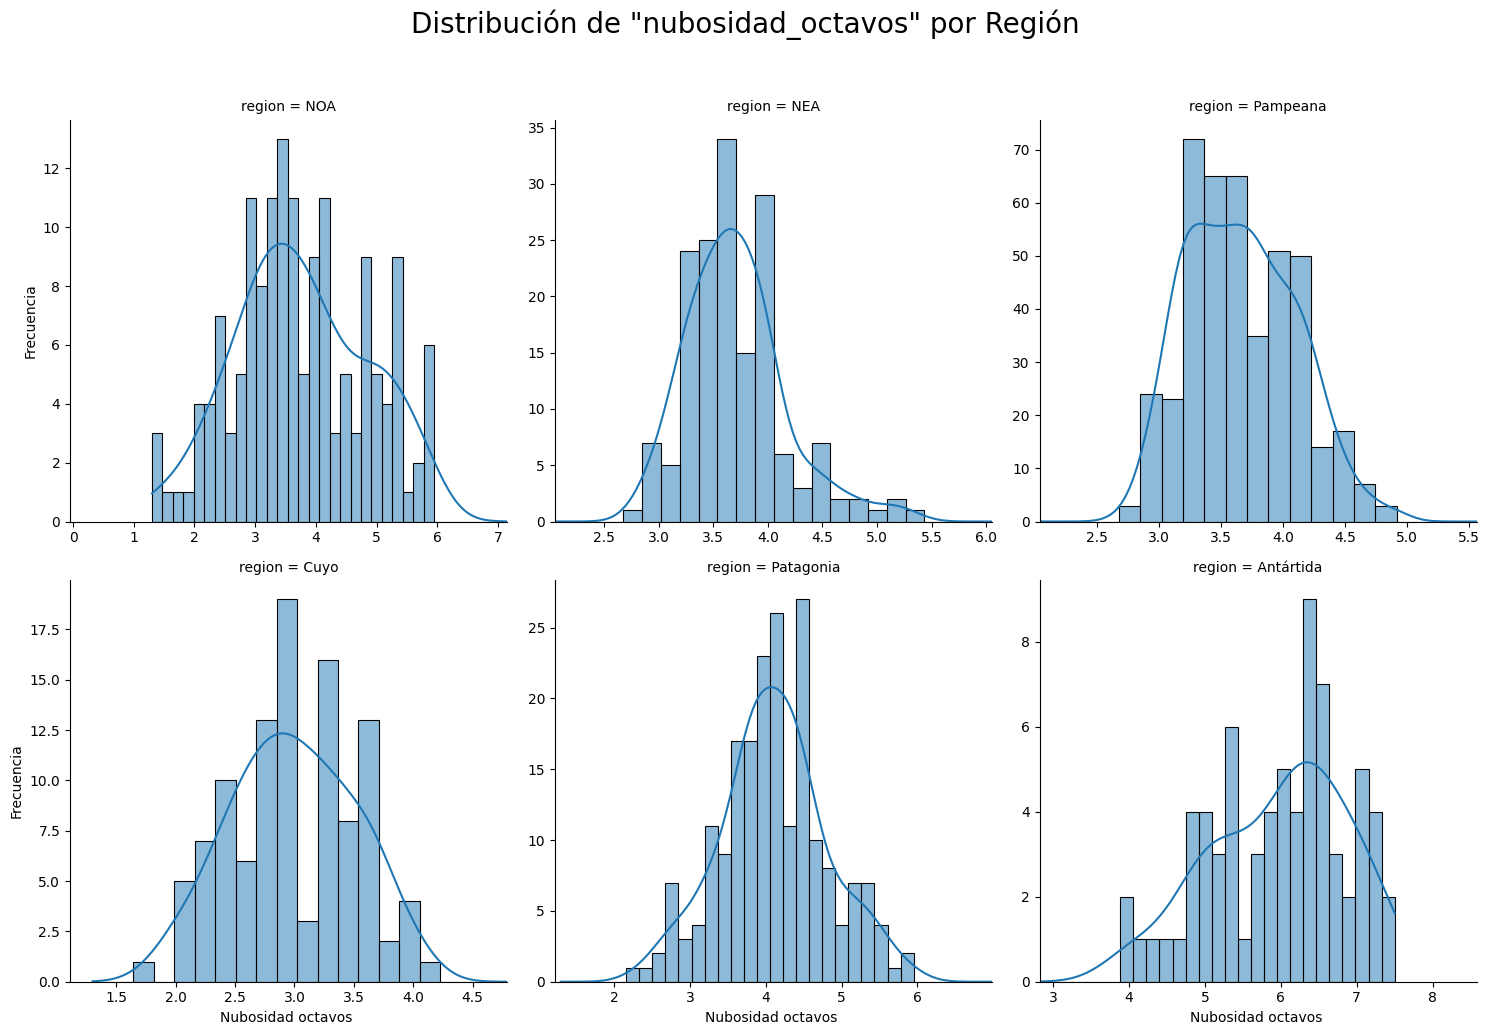

In [26]:
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'nubosidad_octavos'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        padding = (max_val - min_val) * 0.3
        
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región', y=1.03, fontsize=20)
g.set_axis_labels("Nubosidad octavos ", "Frecuencia")
g.fig.tight_layout()
plt.show()

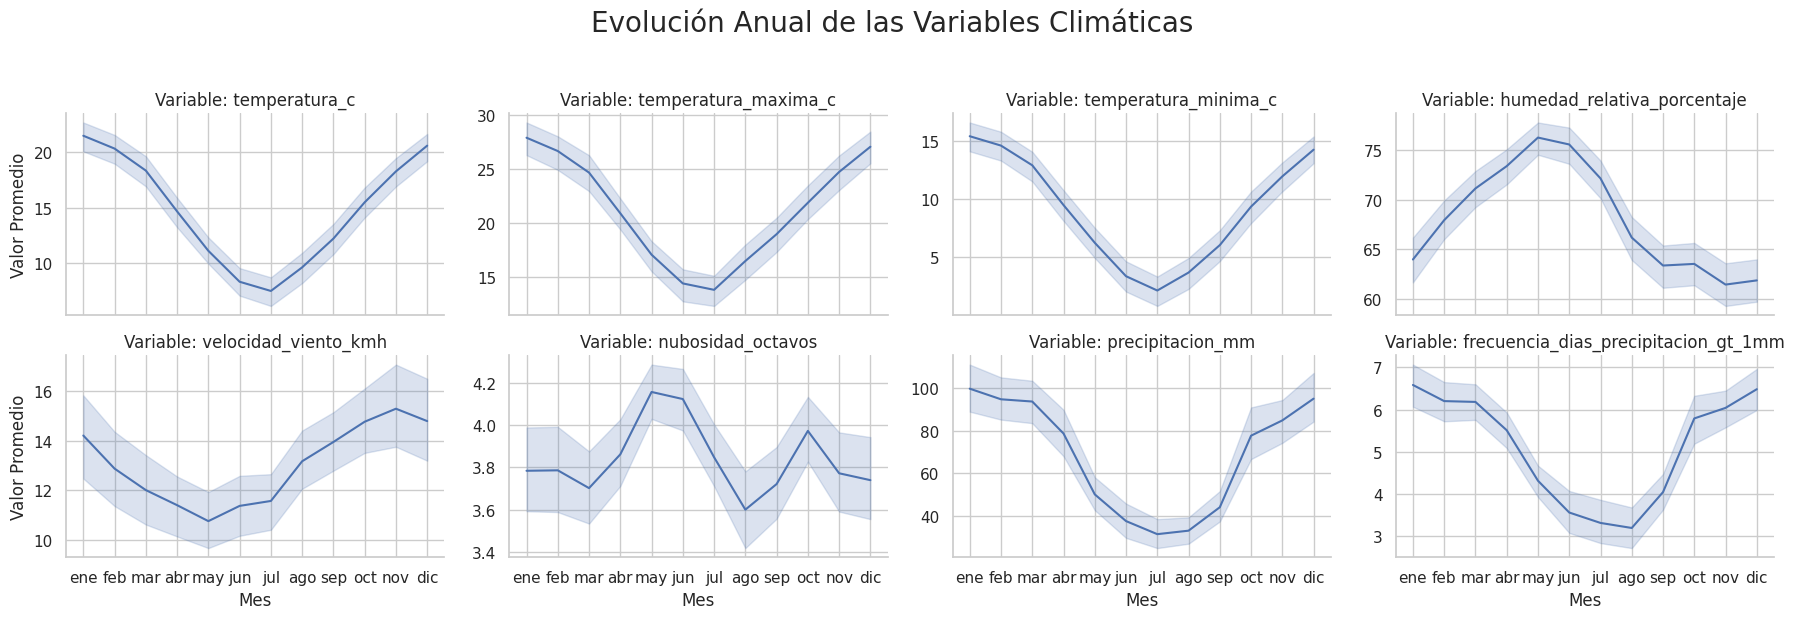

In [ ]:
#Aqui se crea un gráfico de líneas que muestra la evolución promedio anual de las variables climáticas en el DataFrame enriquecido.
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=df_enriquecido,
    x='Mes',
    y='Valor',
    col='Variable',
    kind='line',
    col_wrap=4,
    height=3,
    aspect=1.5,
    facet_kws={'sharey': False, 'sharex': True}
)

g.fig.suptitle('Evolución Anual de las Variables Climáticas', y=1.03, fontsize=20)
g.set_titles("Variable: {col_name}")
g.set_axis_labels("Mes", "Valor Promedio")
plt.tight_layout()
plt.show()

## Descripción General de las Distribuciones de Variables Climáticas

### 1. Temperatura ($temperatura\_c$)

* **Evolución Anual (General):** Sigue un patrón estacional claro, con valores promedio bajos en invierno (julio) y altos en verano (enero-febrero). La banda sombreada indica una variabilidad considerable a lo largo del año.
* **Distribución General:** La distribución general de la temperatura tiende a ser bimodal o presenta una ligera asimetría, con una cola más larga hacia valores más bajos. La media se sitúa alrededor de 14.83 °C y la mediana en 15.70 °C, sugiriendo una ligera asimetría negativa. El rango intercuartílico (IQR) es de 10.98, indicando una dispersión moderada. La curtosis de 1.77 sugiere colas más ligeras que una distribución normal.
* **Distribución en Mendoza:** En Mendoza, la distribución de la temperatura ($temperatura\_c$) se centra alrededor de una media de 15.59 °C y una mediana de 15.95 °C. Presenta un IQR de 10.72 y una curtosis de -1.27, lo que indica una distribución más aplanada (platicúrtica) y posiblemente bimodal o con dos picos, uno alrededor de 10-15°C y otro cerca de 20-25°C. La asimetría es de -0.06, lo que sugiere una distribución casi simétrica o ligeramente sesgada a la izquierda.
* **Distribución por Región:** La distribución de temperatura varía significativamente por región.
    * **NOA, NEA, Pampeana y Cuyo:** Muestran distribuciones que parecen bimodales o con un rango amplio de temperaturas, reflejando las variaciones estacionales. Las temperaturas promedio son más cálidas en estas regiones.
    * **Patagonia:** Presenta un rango de temperaturas más bajas y una distribución más concentrada en valores fríos, aunque con cierta variabilidad.
    * **Antártida:** Exhibe las temperaturas más bajas y una distribución notablemente sesgada hacia valores negativos, con un rango de temperatura mucho más frío en comparación con las demás regiones.

### 2. Temperatura Máxima ($temperatura\_maxima\_c$)

* **Evolución Anual (General):** Al igual que la temperatura promedio, la temperatura máxima muestra una clara estacionalidad, alcanzando sus picos en los meses de verano y sus mínimos en invierno.
* **Distribución General:** La distribución general de la temperatura máxima tiene una media de 21.22 °C y una mediana de 22.40 °C. El IQR es de 13.68, lo que indica una dispersión considerable. La asimetría de -0.08 sugiere una distribución casi simétrica. La curtosis de -0.94 indica que la distribución es más aplanada (platicúrtica) que una normal.
* **Distribución en Mendoza:** Para Mendoza, la temperatura máxima ($temperatura\_maxima\_c$) tiene una media de 23.19 °C y una mediana de 23.45 °C. El IQR es de 13.29, y la asimetría de -0.28 indica un ligero sesgo hacia valores más bajos. La curtosis de -1.20 sugiere una distribución más aplanada que la normal.

### 3. Temperatura Mínima ($temperatura\_minima\_c$)

* **Evolución Anual (General):** La temperatura mínima también sigue un patrón estacional, con los valores más bajos en invierno y los más altos en verano.
* **Distribución General:** La distribución general de la temperatura mínima muestra una media de 9.30 °C y una mediana de 9.90 °C. El IQR es de 10.60, indicando una dispersión similar a la temperatura máxima. La asimetría es de -0.08, sugiriendo una distribución casi simétrica. La curtosis de -1.69 indica que es más aplanada que una distribución normal.
* **Distribución en Mendoza:** La temperatura mínima ($temperatura\_minima\_c$) en Mendoza presenta una media de 8.94 °C y una mediana de 8.75 °C. Con un IQR de 10.22 y una asimetría de -0.01, la distribución es casi simétrica. La curtosis de -1.15 la hace más aplanada que una distribución normal.

### 4. Humedad Relativa ($humedad\_relativa\_porcentaje$)

* **Evolución Anual (General):** La humedad relativa muestra una tendencia estacional inversa a la temperatura, con valores más altos en los meses más fríos y más bajos en los meses más cálidos.
* **Distribución General:** La distribución general de la humedad relativa es multimodal o tiene una forma irregular. La media se encuentra en 68.01 % y la mediana en 70.10 %. El IQR de 13.08 indica una dispersión moderada. La asimetría de -0.22 sugiere un ligero sesgo hacia valores más altos de humedad. La curtosis de 0.12 indica una forma similar a una normal o ligeramente más puntiaguda.
* **Distribución en Mendoza:** En Mendoza, la humedad relativa ($humedad\_relativa\_porcentaje$) tiene una media de 56.09 % y una mediana de 54.10 %. El IQR es de 10.98 y la asimetría de -1.01, lo que indica un sesgo significativo hacia valores más altos de humedad. La curtosis de -1.01 sugiere una distribución más aplanada.

### 5. Velocidad del Viento ($velocidad\_viento\_kmh$)

* **Evolución Anual (General):** La velocidad del viento presenta cierta estacionalidad, con valores ligeramente más altos en primavera-verano y más bajos en invierno.
* **Distribución General:** La distribución general de la velocidad del viento parece tener una cola larga hacia valores más altos, indicando la ocurrencia de vientos fuertes ocasionales. La media es de 10.40 km/h y la mediana de 11.85 km/h. El IQR es de 6.94 y la asimetría de 0.96, confirmando un sesgo positivo (hacia la derecha). La curtosis de 0.97 indica colas más pesadas que una normal.
* **Distribución en Mendoza:** En Mendoza, la velocidad del viento ($velocidad\_viento\_kmh$) tiene una media de 10.50 km/h y una mediana de 10.40 km/h. El IQR es de 3.80, lo que sugiere una menor dispersión en comparación con la distribución general. La asimetría de 1.02 y una curtosis de 0.87 confirman un sesgo positivo y colas más pesadas.

### 6. Nubosidad ($nubosidad\_octavos$)

* **Evolución Anual (General):** La nubosidad muestra fluctuaciones a lo largo del año, con valores ligeramente más altos en los meses de invierno y primavera.
* **Distribución General:** La distribución general de la nubosidad es marcadamente asimétrica, concentrándose en valores bajos (poca nubosidad) y con una cola que se extiende hacia valores más altos (mayor nubosidad). La media es de 3.70 octavos y la mediana de 3.84 octavos. El IQR de 1.90 y la asimetría de 0.70 reflejan este sesgo positivo. La curtosis de 3.38 indica una distribución con un pico más agudo y colas más pesadas que una normal.
* **Distribución en Mendoza:** La nubosidad ($nubosidad\_octavos$) en Mendoza tiene una media de 2.99 octavos y una mediana de 3.00 octavos, lo que sugiere cielos generalmente menos nublados que en el promedio general. El IQR es de 0.50, lo que indica una distribución más concentrada. La asimetría de 0.14 y una curtosis de -1.04 sugieren una distribución más simétrica y aplanada en comparación con la distribución general.

### 7. Precipitación ($precipitacion\_mm$)

* **Evolución Anual (General):** La precipitación es altamente estacional, con los mayores volúmenes concentrados en los meses de verano (especialmente de diciembre a marzo) y mínimos en invierno.
* **Distribución General:** La distribución general de la precipitación está fuertemente sesgada hacia cero, con una gran cantidad de días sin precipitación o con muy poca, y una larga cola hacia valores más altos que representan eventos de lluvia intensos. La media es de 24.40 mm y la mediana de 68.22 mm. El IQR de 83.90 y la asimetría de 1.50 confirman un fuerte sesgo positivo. La curtosis de 0.26 indica colas más pesadas que una normal.
* **Distribución en Mendoza:** La precipitación ($precipitacion\_mm$) en Mendoza tiene una media de 24.18 mm y una mediana de 23.85 mm. El IQR de 60.90 y la asimetría de 0.81 indican un sesgo positivo, aunque posiblemente menos pronunciado que en la distribución general, reflejando el clima más árido de la región. La curtosis de -0.21 sugiere una distribución ligeramente más aplanada.

### 8. Frecuencia de Días con Precipitación > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$)

* **Evolución Anual (General):** La frecuencia de días con precipitación sigue un patrón estacional similar a la precipitación total, siendo más alta en los meses de verano y más baja en invierno.
* **Distribución General:** La distribución general de la frecuencia de días con precipitación > 1mm también está sesgada hacia valores bajos, indicando que los días con precipitación significativa son menos frecuentes. La media es de 5.10 días y la mediana de 5.20 días. El IQR de 1.90 y la asimetría de 0.19 sugieren un ligero sesgo positivo. La curtosis de -0.10 indica una forma similar a una distribución normal.
* **Distribución en Mendoza:** La frecuencia de días con precipitación > 1mm ($frecuencia\_dias\_precipitacion\_gt\_1mm$) en Mendoza tiene una media de 2.93 días y una mediana de 2.80 días. El IQR es de 0.83, lo que sugiere una menor variabilidad. La asimetría de 0.77 y una curtosis de 0.33 indican un sesgo positivo y colas ligeramente más pesadas, lo que es consistente con una región con menor frecuencia de lluvias significativas.

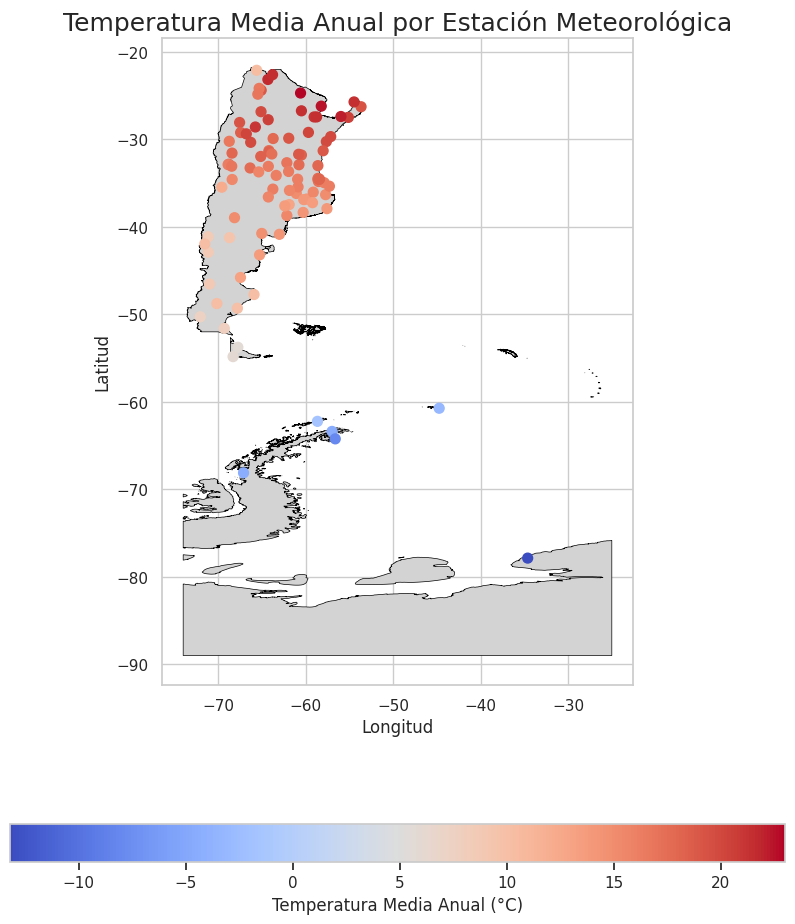

In [ ]:
# Para visualizar los datos se pensaron varias opciones, una de ellas es crear un mapa que muestre las variables metereologicas medias por base.
# Esto permite ademas visualizar la distribución geográfica de las estaciones meteorológicas y cómo varían las variables climáticas en diferentes regiones del país.
# Para ello, se utiliza la librería geopandas para manejar datos geoespaciales y matplotlib para la visualización.  

# 1. Preparar los Datos Geoespaciales
gdf_estaciones = geopandas.GeoDataFrame(
    df_bases, 
    geometry=geopandas.points_from_xy(df_bases.longitud, df_bases.latitud),
    crs="EPSG:4326"
)

#  2. Preparar los Datos a Visualizar 
df_temperatura_media = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('Estación')['Valor'].mean().reset_index()
df_temperatura_media.rename(columns={'Valor': 'temp_media_anual'}, inplace=True)
#  3. Unir Datos  
gdf_final_para_mapa = pd.merge(
    gdf_estaciones,
    df_temperatura_media,
    on='Estación',
    how='inner'
)

#  4. Dibujar el Mapa 
ruta_al_mapa = "datos/pais/paisPolygon.shp"  
argentina_mapa = geopandas.read_file(ruta_al_mapa)


# Creamos la figura y el eje del gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Dibujamos el mapa de provincias como base
argentina_mapa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Superponemos los puntos de las estaciones
gdf_final_para_mapa.plot(
    column='temp_media_anual', 
    ax=ax, 
    legend=True,
    cmap='coolwarm',
    markersize=50,
    legend_kwds={'label': "Temperatura Media Anual (°C)", 'orientation': "horizontal"}
)

# Configuramos el título y los ejes
ax.set_title('Temperatura Media Anual por Estación Meteorológica', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

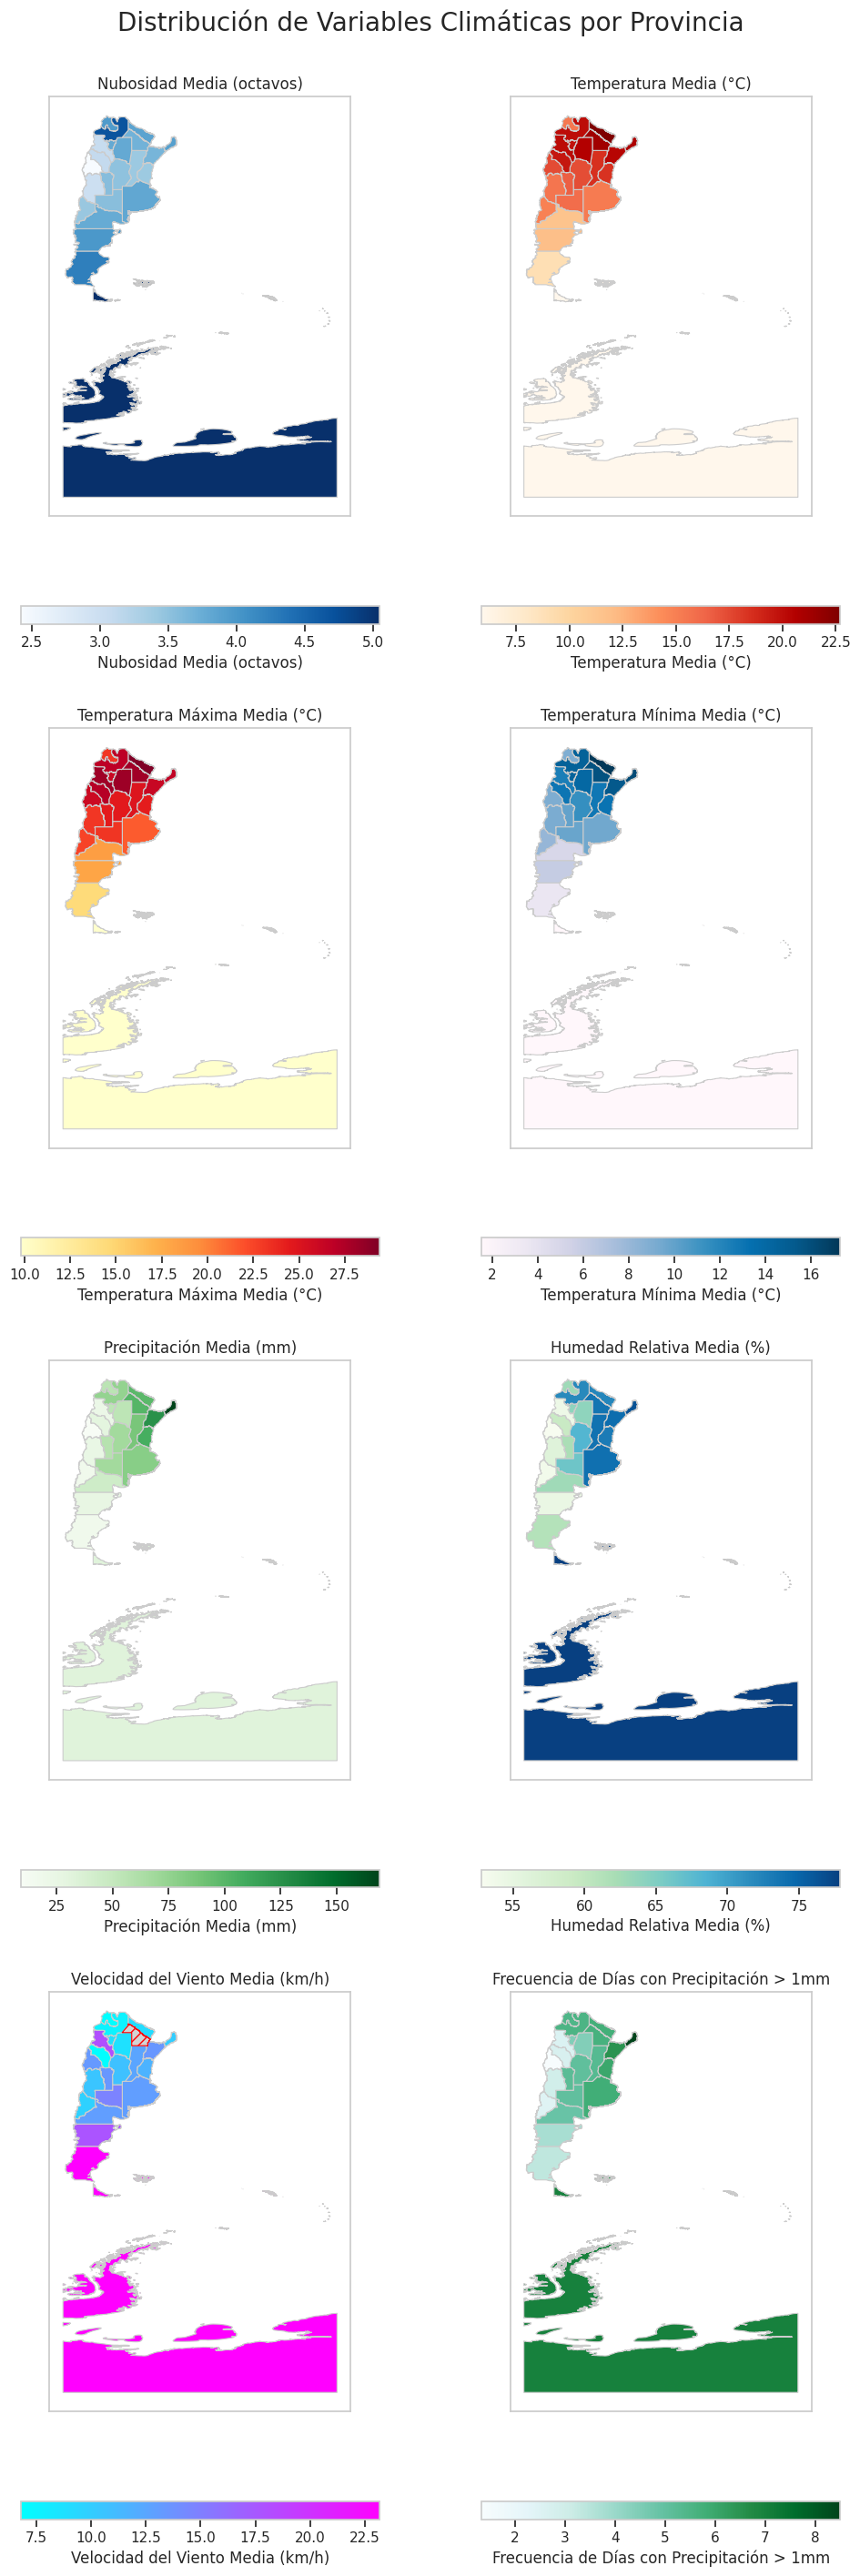

In [ ]:
# En esta sección se crea un mapa que muestra la variable metereologica por provincia en Argentina utilizando los datos promedio anuales de las estaciones meteorológicas.

#  1. PREPARAR DATOS DE NUBOSIDAD 
df_nubo_provincia = df_enriquecido[df_enriquecido['Variable'] == 'nubosidad_octavos'].groupby('provincia')['Valor'].mean().reset_index()
df_nubo_provincia.rename(columns={'Valor': 'nubo_media_provincial'}, inplace=True)
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia'].apply(limpiar_texto)
mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_nubo_provincia['provincia_limpia'] = df_nubo_provincia['provincia_limpia'].replace(mapa_correcciones)

#  2. PREPARAR DATOS DEL MAPA 
ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)

#  3. DICCIONARIO DE VARIABLES A PLOTEAR Y SUS PROPIEDADES 
variables_a_plotear = {
    'nubosidad_octavos': {
        'nombre_columna': 'nubo_media_provincial',
        'titulo': 'Nubosidad Media (octavos)',
        'cmap': 'Blues'
    },
      'temperatura_c': { 
        'nombre_columna': 'temp_media_provincial',
        'titulo': 'Temperatura Media (°C)',
        'cmap': 'OrRd'
    },
    'temperatura_maxima_c': {
        'nombre_columna': 'temp_max_media_provincial',
        'titulo': 'Temperatura Máxima Media (°C)',
        'cmap': 'YlOrRd'
    },
    'temperatura_minima_c': {
        'nombre_columna': 'temp_min_media_provincial',
        'titulo': 'Temperatura Mínima Media (°C)',
        'cmap': 'PuBu'
    },
    'precipitacion_mm': {
        'nombre_columna': 'precip_media_provincial',
        'titulo': 'Precipitación Media (mm)',
        'cmap': 'Greens'
    },
    'humedad_relativa_porcentaje': {
        'nombre_columna': 'humedad_media_provincial',
        'titulo': 'Humedad Relativa Media (%)',
        'cmap': 'GnBu'
    },
    'velocidad_viento_kmh': {
        'nombre_columna': 'viento_media_provincial',
        'titulo': 'Velocidad del Viento Media (km/h)',
        'cmap': 'cool'
    },
    'frecuencia_dias_precipitacion_gt_1mm': {
        'nombre_columna': 'frec_precip_media_provincial',
        'titulo': 'Frecuencia de Días con Precipitación > 1mm',
        'cmap': 'BuGn'
    }
}

#  4. CREAR EL SUBPLOT DE MAPAS 
n_variables = len(variables_a_plotear)
ncols = 2
nrows = (n_variables + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 7)) # Ajusta el tamaño de la figura
axes = axes.flatten() 

for i, (variable_original, props) in enumerate(variables_a_plotear.items()):
    ax = axes[i]

    # Prepara los datos para la variable actual
    df_variable_provincia = df_enriquecido[df_enriquecido['Variable'] == variable_original].groupby('provincia')['Valor'].mean().reset_index()
    df_variable_provincia.rename(columns={'Valor': props['nombre_columna']}, inplace=True)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia'].apply(limpiar_texto)
    df_variable_provincia['provincia_limpia'] = df_variable_provincia['provincia_limpia'].replace(mapa_correcciones)

    # Une los dataframes
    mapa_final_variable = pd.merge(
        mapa_provincias,
        df_variable_provincia,
        on='provincia_limpia',
        how='left'
    )

    # Dibuja el mapa
    mapa_final_variable.plot(
        column=props['nombre_columna'],
        ax=ax,
        legend=True,
        cmap=props['cmap'],
        linewidth=0.8,
        edgecolor='0.8',
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Sin datos",
        },
        legend_kwds={'label': props['titulo'], 'orientation': "horizontal", 'shrink': 0.6} # Shrink para reducir el tamaño de la leyenda
    )

    ax.set_title(props['titulo'], fontsize=12)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_aspect('equal')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Ajusta el layout para evitar solapamientos
plt.suptitle('Distribución de Variables Climáticas por Provincia', fontsize=20, y=1.02) # Título general
plt.show()

In [42]:
#--- 1. Estadísticas Generales por Variable ---
estadisticas_generales = df_enriquecido.groupby('Variable').agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
display_nice_table(estadisticas_generales, 
                  title="📈 ESTADÍSTICAS GENERALES POR VARIABLE", 
                  max_rows=10)

print("\n🔢 MODA POR VARIABLE")
print("-" * 40)
moda_general = df_enriquecido.groupby('Variable')['Valor'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
moda_df = moda_general.reset_index()
moda_df.columns = ['Variable', 'Moda']
display_nice_table(moda_df, max_rows=10)


# --- 2. Estadísticas por Región y Variable ---
estadisticas_por_region = df_enriquecido.groupby(['region', 'Variable']).agg(
    conteo=('Valor', 'count'),
    media=('Valor', 'mean'),
    desvio_est=('Valor', 'std'),
    varianza=('Valor', 'var'),
    mediana=('Valor', 'median'),
    minimo=('Valor', 'min'),
    maximo=('Valor', 'max'),
    asimetria_pearson=('Valor', pd.Series.skew),
    curtosis_fisher=('Valor', pd.Series.kurt)
)
display_nice_table(estadisticas_por_region, 
                  title="🌍 ESTADÍSTICAS POR REGIÓN Y VARIABLE", 
                  max_rows=20)


           📈 ESTADÍSTICAS GENERALES POR VARIABLE            
Dimensiones: 8 filas × 9 columnas
------------------------------------------------------------


conteo  media  desvio_est  varianza  mediana  minimo  \
Variable                                                                     
frecuencia_dias_p...    1061   5.10        2.54      6.43     5.20    0.00   
humedad_relativa_...    1110  68.01       11.03    121.61    70.10   25.70   
nubosidad_octavos       1166   3.84        0.89      0.79     3.70    1.30   
precipitacion_mm        1061  68.23       51.67   2670.26    58.90    0.00   
temperatura_c           1167  14.83        8.18     66.89    15.70  -20.90   
temperatura_maxima_c    1158  21.22        8.94     79.90    22.40  -17.50   
temperatura_minima_c    1124   9.10        7.78     60.51     9.90  -25.00   
velocidad_viento_kmh     708  13.01        5.55     30.85    11.80    3.90   

                      maximo  asimetria_pearson  curtosis_fisher  
Variable                                                          
frecuencia_dias_p...   13.80               0.19            -0.19  
humedad_relativa_...   90.20              -0.72             0.12  
nubosidad_octavos       7.50               1.11             2.38  
precipitacion_mm      277.90               0.66            -0.26  
temperatura_c          28.30              -1.09             1.77  
temperatura_maxima_c   35.50              -1.27             2.04  
temperatura_minima_c   22.50              -0.98             1.69  
velocidad_viento_kmh   36.50               0.96             0.97


🔢 MODA POR VARIABLE
----------------------------------------


Variable  Moda
0  frecuencia_dias_...  6.50
1  humedad_relativa... 71.10
2    nubosidad_octavos  3.70
3     precipitacion_mm 24.40
4        temperatura_c 21.80
5  temperatura_maxi... 27.90
6  temperatura_mini...  4.90
7  velocidad_viento... 10.40


            🌍 ESTADÍSTICAS POR REGIÓN Y VARIABLE            
Dimensiones: 48 filas × 9 columnas
------------------------------------------------------------


conteo  media  desvio_est  varianza  mediana  \
region    Variable                                                             
Antártida frecuencia_dias_p...       0    NaN         NaN       NaN      NaN   
          humedad_relativa_...      17  83.22        5.81     33.70    85.40   
          nubosidad_octavos         72   5.96        0.89      0.80     6.15   
          precipitacion_mm           0    NaN         NaN       NaN      NaN   
          temperatura_c             72  -5.81        6.08     36.94    -5.10   
...                                ...    ...         ...       ...      ...   
Patagonia precipitacion_mm         178  30.02       26.45    699.75    23.55   
          temperatura_c            202  10.21        5.65     31.91     9.80   
          temperatura_maxima_c     203  16.22        6.74     45.41    16.00   
          temperatura_minima_c     193   4.58        4.67     21.83     4.10   
          velocidad_viento_kmh     156  18.54        6.74     45.36    19.10   

                                minimo  maximo  asimetria_pearson  \
region    Variable                                                  
Antártida frecuencia_dias_p...     NaN     NaN                NaN   
          humedad_relativa_...   71.20   90.20              -0.95   
          nubosidad_octavos       3.90    7.50              -0.40   
          precipitacion_mm         NaN     NaN                NaN   
          temperatura_c         -20.90    2.20              -0.74   
...                                ...     ...                ...   
Patagonia precipitacion_mm        6.90  173.10               3.24   
          temperatura_c           0.10   24.10               0.30   
          temperatura_maxima_c    3.20   32.10               0.18   
          temperatura_minima_c   -4.40   15.90               0.33   
          velocidad_viento_kmh    3.90   36.50              -0.10   

                                curtosis_fisher  
region    Variable                               
Antártida frecuencia_dias_p...              NaN  
          humedad_relativa_...            -0.31  
          nubosidad_octavos               -0.60  
          precipitacion_mm                  NaN  
          temperatura_c                   -0.24  
...                                         ...  
Patagonia precipitacion_mm                12.06  
          temperatura_c                   -0.68  
          temperatura_maxima_c            -0.74  
          temperatura_minima_c            -0.56  
          velocidad_viento_kmh            -0.24  

[48 rows x 9 columns]


... mostrando solo las primeras 20 filas de 48 totales


## Outlaiers

/home/rodrigo/Desktop/Maestria/EDA_meteorologica/eda/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


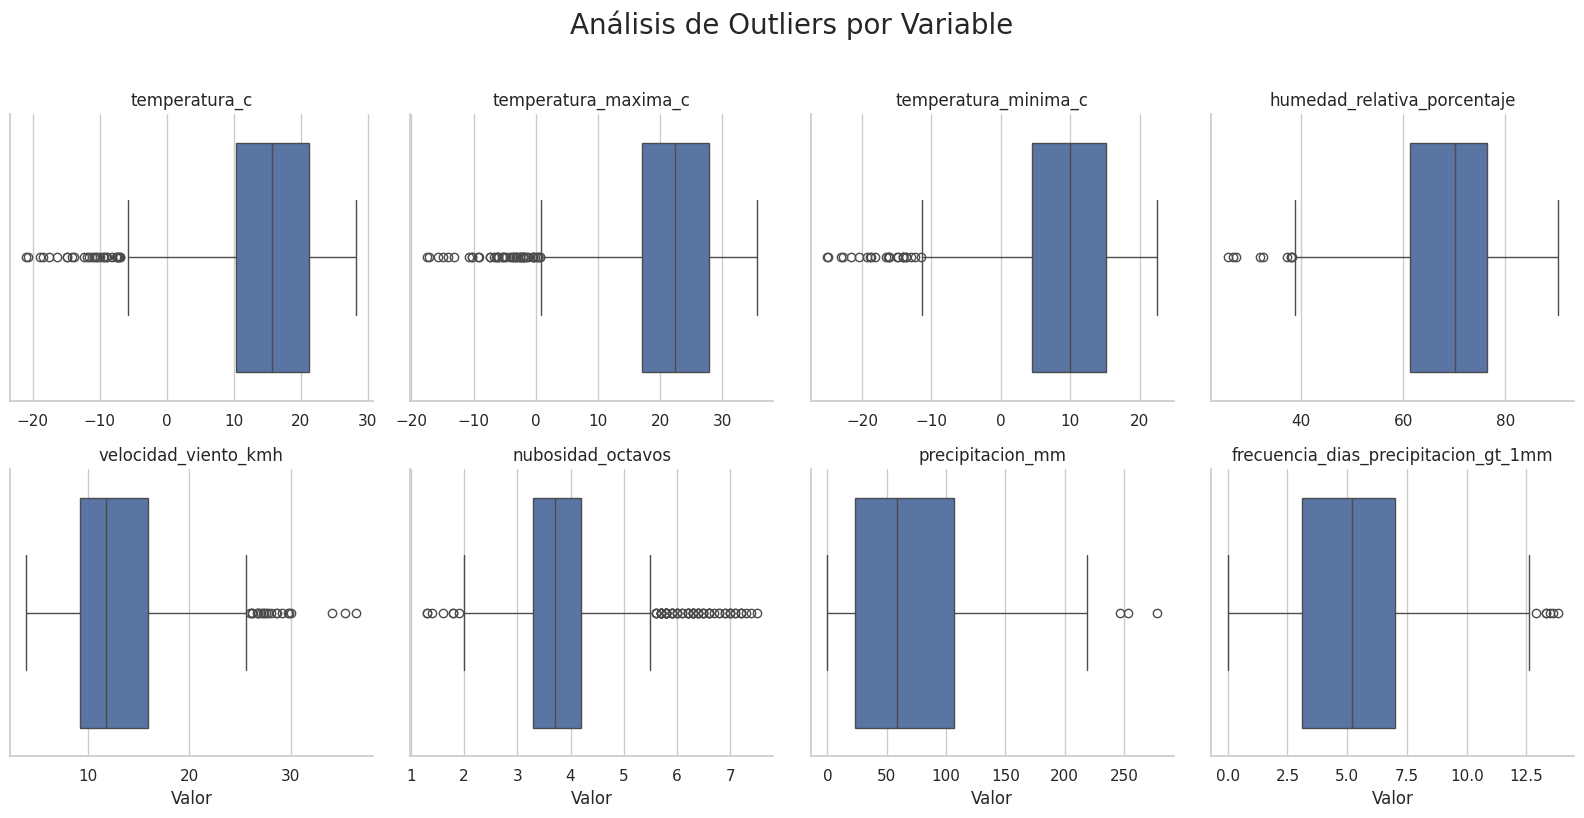

In [ ]:
# --- 3. Análisis de Outliers ---
# En esta sección se crea un gráfico de cajas (boxplot) para cada variable en el DataFrame enriquecido. La desventaja de visualizarlos de esta forma es que si hay muchas variabilidad entre distintas regiones, 
# Puede que haya valores que se visualicen como outliers por la variabilidad climatica del pais pero si los analizamos por región, podemos ver que no son outliers.
# Por ejemplo en misiones promido llueve 2000mm al año
sns.set_theme(style="whitegrid")

g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=4, 
    sharey=False, 
    sharex=False, 
    height=4
)

g.map(sns.boxplot, "Valor")

g.set_axis_labels("Valor", "")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
#Aqui se calcula el rango intercuartílico (IQR) para cada variable y se establecen los límites inferior y superior para detectar outliers.
# Los outliers se definen como aquellos valores que están 1.5 por debajo del límite inferior o por 1.5 encima del límite superior.
# Se muestran en tablas
Q1 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.25) 
Q3 = df_enriquecido.groupby('Variable')['Valor'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

limites = pd.DataFrame({'lim_inf': limite_inferior, 'lim_sup': limite_superior})
display_nice_table(limites, 
                  title="⚠️  LÍMITES PARA DETECCIÓN DE OUTLIERS", 
                  max_rows=10)

df_con_limites = pd.merge(df_enriquecido, limites, on='Variable', how='left')

outliers_generales = df_con_limites[
    (df_con_limites['Valor'] < df_con_limites['lim_inf']) | 
    (df_con_limites['Valor'] > df_con_limites['lim_sup'])
]

conteo_de_outliers = outliers_generales['Variable'].value_counts()

total_por_variable = df_enriquecido['Variable'].value_counts()

resumen_outliers = pd.DataFrame({
    'total_registros': total_por_variable,
    'cantidad_outliers': conteo_de_outliers
}).fillna(0)

resumen_outliers['porcentaje_outliers'] = (resumen_outliers['cantidad_outliers'] / resumen_outliers['total_registros']) * 100

display_nice_table(resumen_outliers, 
                  title="📊 RESUMEN DE OUTLIERS POR VARIABLE", 
                  max_rows=10)


           ⚠️  LÍMITES PARA DETECCIÓN DE OUTLIERS           
Dimensiones: 8 filas × 2 columnas
------------------------------------------------------------


lim_inf  lim_sup
Variable                              
frecuencia_dias_p...    -2.75    12.85
humedad_relativa_...    38.71    99.01
nubosidad_octavos        1.95     5.55
precipitacion_mm      -101.50   231.30
temperatura_c           -6.05    37.55
temperatura_maxima_c     0.71    44.21
temperatura_minima_c   -11.40    31.00
velocidad_viento_kmh    -0.85    25.95


             📊 RESUMEN DE OUTLIERS POR VARIABLE             
Dimensiones: 8 filas × 3 columnas
------------------------------------------------------------


total_registros  cantidad_outliers  porcentaje_outliers
Variable                                                                     
frecuencia_dias_p...             1176                  6                 0.51
humedad_relativa_...             1176                  9                 0.77
nubosidad_octavos                1176                 69                 5.87
precipitacion_mm                 1176                  3                 0.26
temperatura_c                    1176                 29                 2.47
temperatura_maxima_c             1176                 47                 4.00
temperatura_minima_c             1176                 24                 2.04
velocidad_viento_kmh             1176                 21                 1.79


--- Regiones encontradas: NOA, NEA, Pampeana, Cuyo, nan, Patagonia, Antártida ---


/home/rodrigo/Desktop/Maestria/solar-energy-suggester/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


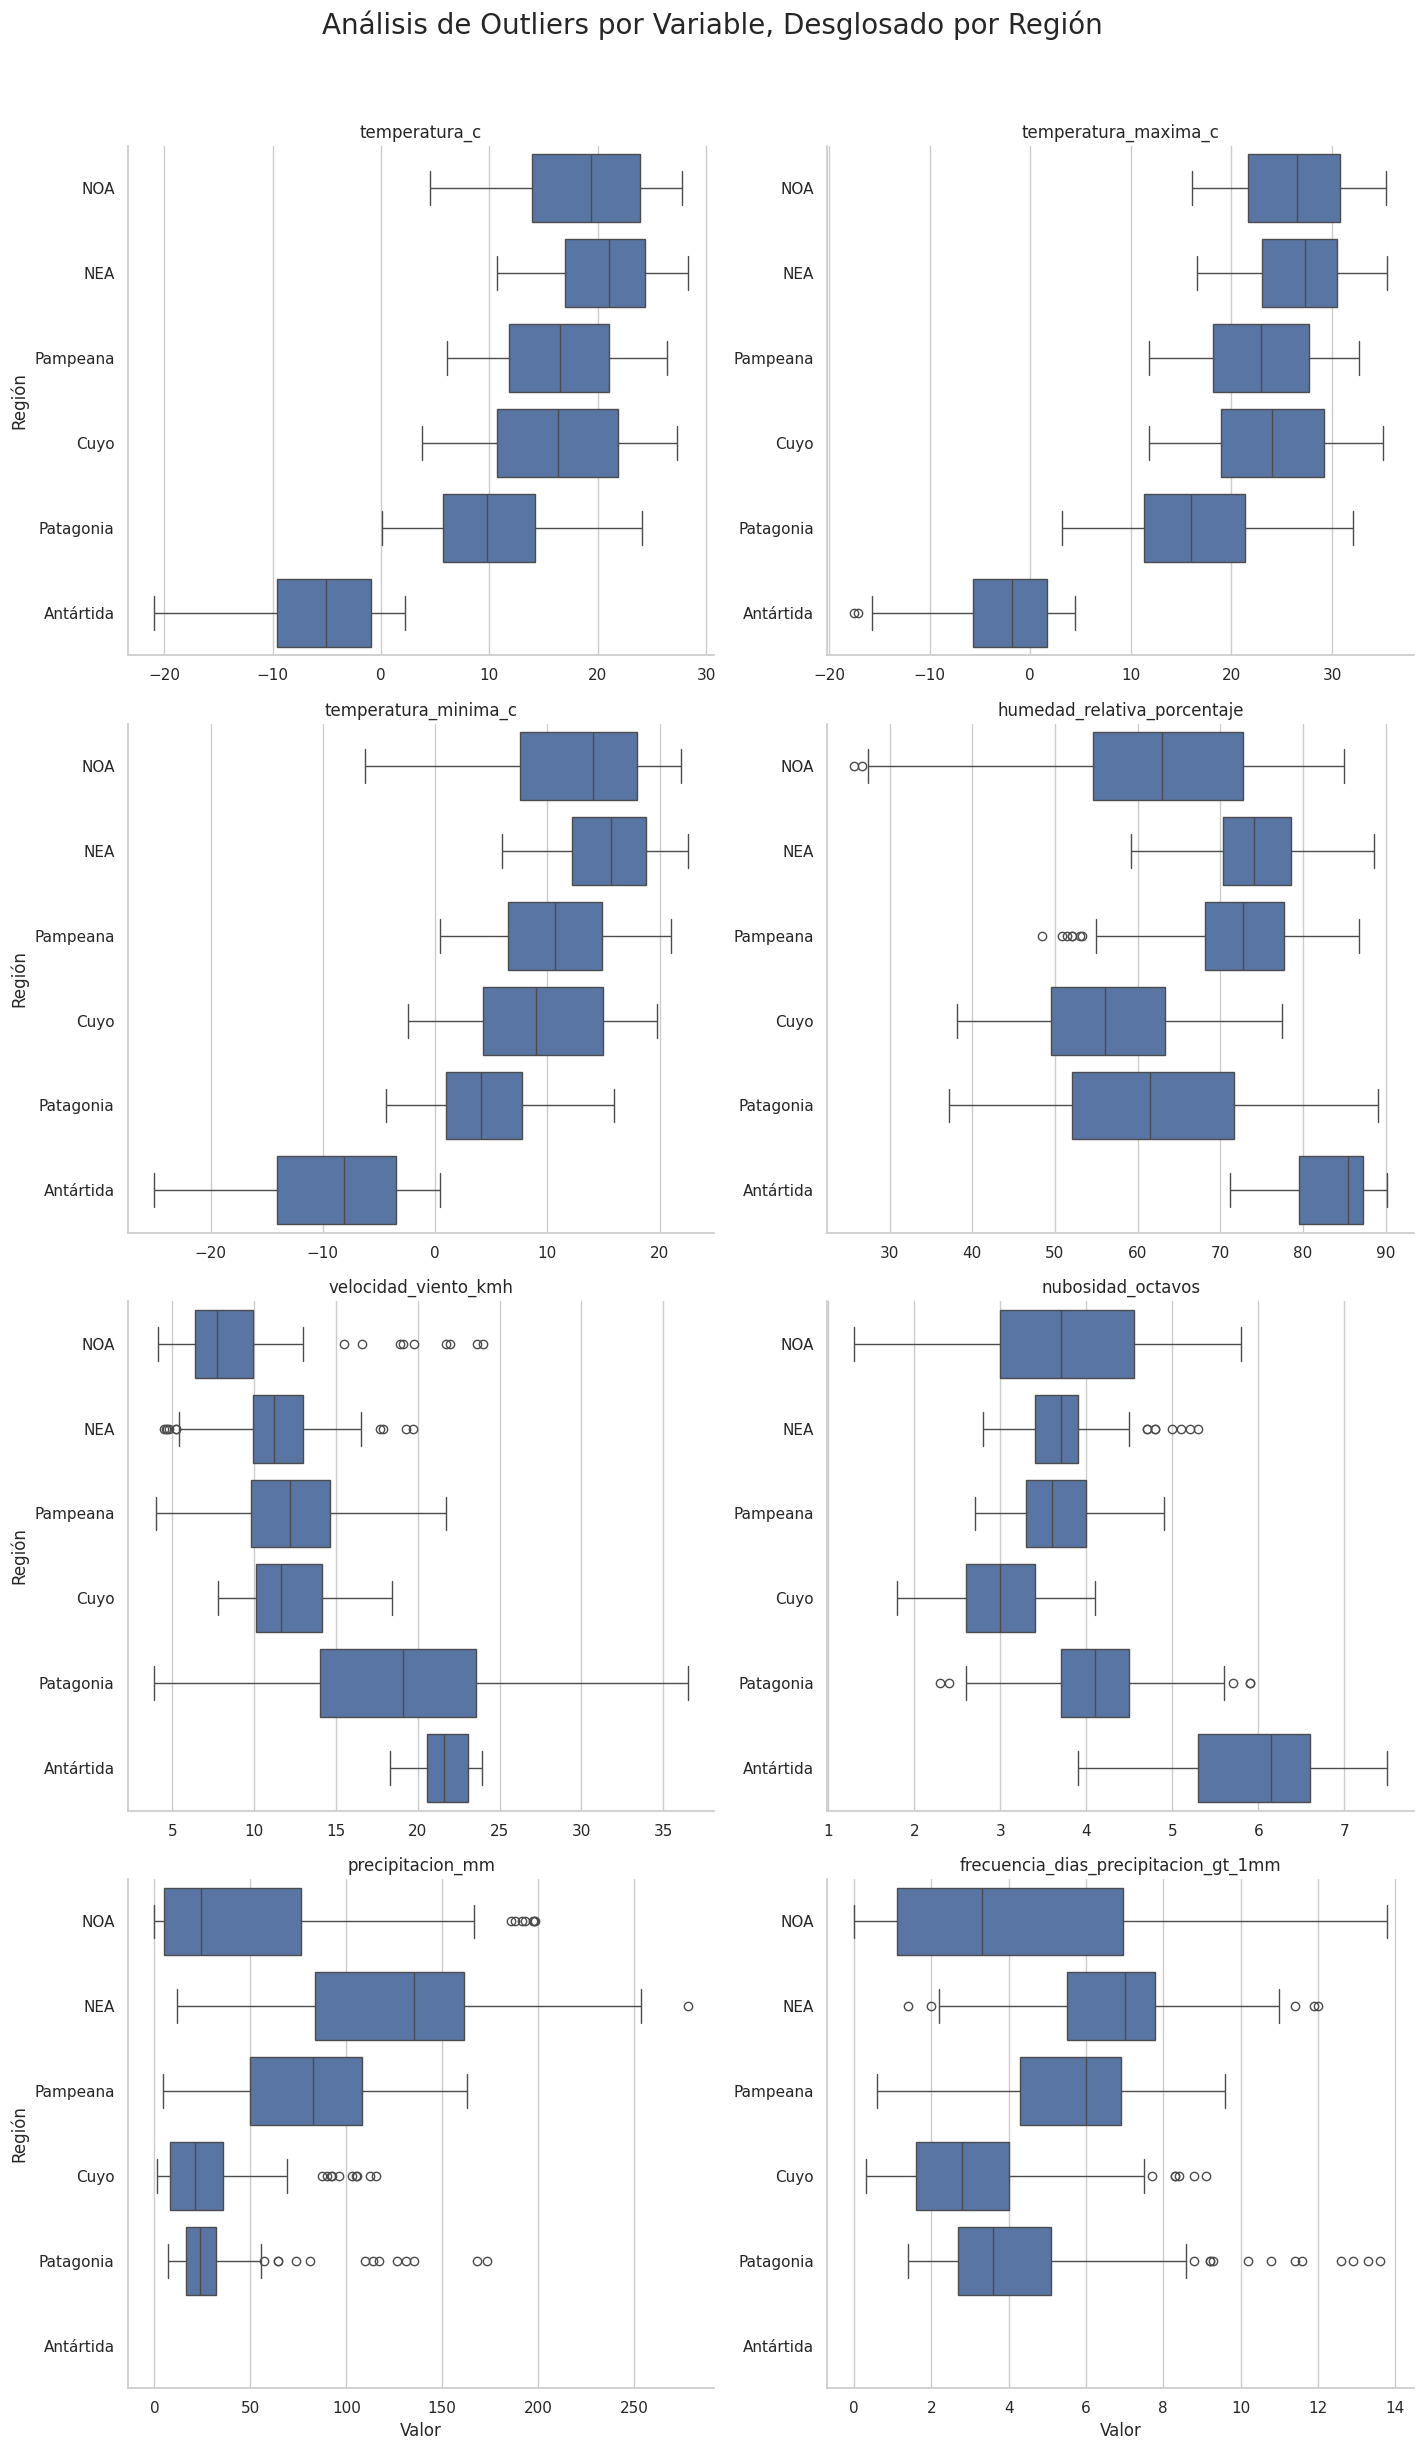

In [ ]:
#Como explicamos anteriormente, los outliers pueden ser causados por la variabilidad climática del país. Por lo tanto, es útil analizar los outliers por región para ver si son realmente outliers o si son valores esperados en ciertas regiones.
# En esta sección se crea un gráfico de cajas (boxplot) para cada variable, desglosado por región. Esto permite visualizar la distribución de los valores y detectar outliers específicos de cada región.
sns.set_theme(style="whitegrid")
regiones= df_enriquecido['region'].astype(str).unique()
print(f"\n--- Regiones encontradas: {', '.join(regiones)} ---")
g = sns.FacetGrid(
    df_enriquecido, 
    col="Variable", 
    col_wrap=2,  
    sharex=False, 
    sharey=False, 
    height=6,   
    aspect=1.2
)


g.map(sns.boxplot, 'Valor', 'region')
g.set_axis_labels("Valor", "Región")
g.set_titles("{col_name}")
g.fig.suptitle("Análisis de Outliers por Variable, Desglosado por Región", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
#Aquí se calcula el rango intercuartílico (IQR) para cada variable por región y se establecen los límites inferior y superior para detectar outliers.
# Los outliers se definen como aquellos valores que están 1.5 por debajo del límite inferior o por 1.5 encima del límite superior.
# Se muestran en tablas
# Calculamos los límites agrupando por región Y variable
Q1_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.25)
Q3_region = df_enriquecido.groupby(['region', 'Variable'])['Valor'].quantile(0.75)
IQR_region = Q3_region - Q1_region

# Calculamos los límites inferior y superior
lim_inf_region = Q1_region - 1.5 * IQR_region
lim_sup_region = Q3_region + 1.5 * IQR_region 

# Creamos un DataFrame con los límites
limites_region = pd.DataFrame({'lim_inf': lim_inf_region, 'lim_sup': lim_sup_region}).reset_index()
display_nice_table(limites_region, 
                  title="🌍 LÍMITES DE OUTLIERS POR REGIÓN Y VARIABLE", 
                  max_rows=15)
# Unimos los límites al DataFrame original
df_con_limites_region = pd.merge(df_enriquecido, limites_region, on=['region', 'Variable'], how='left')

# Filtramos los outliers usando los límites corregidos
outliers_region = df_con_limites_region[
    (df_con_limites_region['Valor'] < df_con_limites_region['lim_inf']) | 
    (df_con_limites_region['Valor'] > df_con_limites_region['lim_sup'])
]

conteo_outliers_region = outliers_region.groupby(['region', 'Variable']).size()
total_por_region = df_enriquecido.groupby(['region', 'Variable']).size()

resumen_outliers_region = pd.DataFrame({
    'total_registros': total_por_region,
    'cantidad_outliers': conteo_outliers_region
}).fillna(0)

resumen_outliers_region['porcentaje_outliers'] = \
    (resumen_outliers_region['cantidad_outliers'] / resumen_outliers_region['total_registros']) * 100
display_nice_table(resumen_outliers_region, 
                  title="📊 RESUMEN DE OUTLIERS POR REGIÓN Y VARIABLE", 
                  max_rows=15)


        🌍 LÍMITES DE OUTLIERS POR REGIÓN Y VARIABLE         
Dimensiones: 48 filas × 4 columnas
------------------------------------------------------------


region             Variable  lim_inf  lim_sup
0   Antártida  frecuencia_dias_...      NaN      NaN
1   Antártida  humedad_relativa...    67.95    98.75
2   Antártida    nubosidad_octavos     3.35     8.55
3   Antártida     precipitacion_mm      NaN      NaN
4   Antártida        temperatura_c   -22.75    12.25
..        ...                  ...      ...      ...
43  Patagonia     precipitacion_mm    -6.90    55.50
44  Patagonia        temperatura_c    -6.89    26.81
45  Patagonia  temperatura_maxi...    -3.78    36.43
46  Patagonia  temperatura_mini...    -9.05    17.75
47  Patagonia  velocidad_viento...    -0.33    37.88

[48 rows x 4 columns]


... mostrando solo las primeras 15 filas de 48 totales

        📊 RESUMEN DE OUTLIERS POR REGIÓN Y VARIABLE         
Dimensiones: 48 filas × 3 columnas
------------------------------------------------------------


total_registros  cantidad_outliers  \
region    Variable                                                   
Antártida frecuencia_dias_p...               72               0.00   
          humedad_relativa_...               72               0.00   
          nubosidad_octavos                  72               0.00   
          precipitacion_mm                   72               0.00   
          temperatura_c                      72               0.00   
...                                         ...                ...   
Patagonia precipitacion_mm                  204              13.00   
          temperatura_c                     204               0.00   
          temperatura_maxima_c              204               0.00   
          temperatura_minima_c              204               0.00   
          velocidad_viento_kmh              204               0.00   

                                porcentaje_outliers  
region    Variable                                   
Antártida frecuencia_dias_p...                 0.00  
          humedad_relativa_...                 0.00  
          nubosidad_octavos                    0.00  
          precipitacion_mm                     0.00  
          temperatura_c                        0.00  
...                                             ...  
Patagonia precipitacion_mm                     6.37  
          temperatura_c                        0.00  
          temperatura_maxima_c                 0.00  
          temperatura_minima_c                 0.00  
          velocidad_viento_kmh                 0.00  

[48 rows x 3 columns]


... mostrando solo las primeras 15 filas de 48 totales


## 1. Límites de Detección

A continuación, se presentan los límites calculados para cada variable:

--- Límites para detección de outliers por Variable ---

| Variable                               | lim_inf | lim_sup |
|----------------------------------------|---------|---------|
| frecuencia_dias_precipitacion_gt_1mm  | -2.7500 | 12.8500 |
| humedad_relativa_porcentaje            | 38.7125 | 99.0125 |
| nubosidad_octavos                      | 1.9500  | 5.5500  |
| precipitacion_mm                       | -101.5000 | 231.3000 |
| temperatura_c                          | -6.0500 | 37.5500 |
| temperatura_maxima_c                   | 0.7125  | 44.2125 |
| temperatura_minima_c                   | -11.4000 | 31.0000 |
| velocidad_viento_kmh                   | -0.8500 | 25.9500 |

## 2. Análisis General de Outliers por Variable

**Observaciones:**

* **`nubosidad_octavos`** presenta el mayor porcentaje de outliers (5.87%), sugiriendo variaciones considerables en la cobertura nubosa.
* Las variables de temperatura (`temperatura_maxima_c`, `temperatura_c`, `temperatura_minima_c`) también muestran una cantidad notable de outliers, indicando registros de temperaturas inusualmente altas o bajas.
* **`precipitacion_mm`** tiene el menor porcentaje de outliers (0.26%), lo cual es esperable, ya que las precipitaciones extremadamente altas son eventos menos frecuentes.

## 3. Análisis de Outliers Desglosado por Región

### Diferencias Clave en los Outliers entre Regiones:

Las regiones presentan patrones distintivos en la aparición de outliers, lo que subraya la diversidad climática del país:

* **Antártida:** Destaca por la casi total ausencia de outliers, con la excepción de `temperatura_maxima_c`. Esto sugiere una menor variabilidad en sus condiciones climáticas en comparación con otras regiones.
* **Cuyo:** Muestra una alta concentración de outliers en variables relacionadas con la precipitación (`frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`), lo que podría indicar eventos de lluvias intensas o infrecuentes. No presenta outliers en temperatura ni viento. Esto se podria explicar por las tormentas de verano tipicas de esta region.
* **NEA y NOA:** Ambas regiones del norte exhiben outliers significativos en `velocidad_viento_kmh` y `precipitacion_mm`, además de `nubosidad_octavos` en el NEA.
* **Pampeana:** Se caracteriza por tener un bajo número de outliers en general, con solo `humedad_relativa_porcentaje` mostrando una proporción notable. Esto podría indicar una mayor estabilidad en sus patrones climáticos.
* **Patagonia:** Presenta un número considerable de outliers en `frecuencia_dias_precipitacion_gt_1mm` y `precipitacion_mm`, lo cual es coherente con su clima variable que puede incluir eventos de precipitación extremos. También se observan outliers en `nubosidad_octavos`.

---
# Parte 2: Proceso de transformacion de datos temporales a datos tabulares

Dada la naturaleza temporal del dataset en su formato actual, habiando secuencialidad en los datos de cada variable de cada estacion por cada mes, es conveniente hacer uso de esto para poder inputar ciertas de las entradas de ciertas columnas con tecnicas de interpolacion, interpolando cada variable con los valores de los meses anteriores y posteriores de cada estacion con datos faltantes. Por otro lado es importante destacar, que en caso de que sea posible inputar sin interpolacion, como casos faltantes de coordenadas geograficas o nombres de provincia, regio, etc. sera inputado con el valor verdadero usando fuentes externas.

In [57]:
# Mapa para cubrir datos faltantes cateogricos y de coordenadas geograficas. Fue conformado a partir de datos externos e investigacion.
corrections_map = {
    'aeroparque_aero': ['CAPITAL FEDERAL', 'GBA', -34.57, -58.42, 6, 87582, 'SABE'],
    'azul_aero': ['BUENOS AIRES', 'PAMPEANA', -36.83, -59.88, 147, 87641, 'SAZA'],
    'bahia_blanca_aero': ['BUENOS AIRES', 'PAMPEANA', -38.72, -62.17, 83, 87750, 'SAZB'],
    'bariloche_aero': ['RIO NEGRO', 'PATAGONICA', -41.15, -71.17, 835, 87765, 'SAZS'],
    'base_belgrano_ii': ['ANTARTIDA', 'ANTARTIDA', -77.87, -34.63, 256, 89034, None],
    'base_carlini_ex_jubany': ['ANTARTIDA', 'ANTARTIDA', -62.23, -58.67, 11, 89053, 'SAYJ'],
    'base_esperanza': ['ANTARTIDA', 'ANTARTIDA', -63.40, -57.00, 24, 89034, 'SAYE'],
    'base_marambio': ['ANTARTIDA', 'ANTARTIDA', -64.23, -56.63, 198, 89033, 'SAWB'],
    'base_orcadas': ['ANTARTIDA', 'ANTARTIDA', -60.73, -44.73, 12, 88963, 'SAYO'],
    'base_san_martin': ['ANTARTIDA', 'ANTARTIDA', -68.13, -67.10, 7, 89066, 'SAYM'],
    'bernardo_de_irigoyen_aero': ['MISIONES', 'NEA', -26.28, -53.67, 815, 87103, 'SATI'],
    'bolivar_aero': ['BUENOS AIRES', 'PAMPEANA', -36.18, -61.07, 94, 87634, 'SAZI'],
    'buenos_aires_observatorio': ['CAPITAL FEDERAL', 'GBA', -34.58, -58.48, 25, 87576, None],
    'catamarca_aero': ['CATAMARCA', 'NOA', -28.60, -65.75, 464, 87217, 'SANC'],
    'ceres_aero': ['SANTA FE', 'PAMPEANA', -29.88, -61.93, 88, 87349, 'SANW'],
    'chamical_aero': ['LA RIOJA', 'NOA', -30.35, -66.30, 461, 87311, 'SACT'],
    'chilecito_aero': ['LA RIOJA', 'NOA', -29.22, -67.45, 947, 87213, 'SANO'],
    'comodoro_rivadavia_aero': ['CHUBUT', 'PATAGONICA', -45.80, -67.47, 46, 87860, 'SAVC'],
    'concordia_aero': ['ENTRE RIOS', 'NEA', -31.30, -58.00, 38, 87480, 'SAAC'],
    'cordoba_aero': ['CORDOBA', 'CENTRO', -31.30, -64.22, 495, 87344, 'SACO'],
    'cordoba_observatorio': ['CORDOBA', 'CENTRO', -31.42, -64.20, 425, 87345, None],
    'coronel_pringles_aero': ['BUENOS AIRES', 'PAMPEANA', -38.00, -61.33, 247, 87751, 'SAZP'],
    'coronel_suarez_aero': ['BUENOS AIRES', 'PAMPEANA', -37.45, -61.88, 233, 87644, 'SAZC'],
    'corrientes_aero': ['CORRIENTES', 'NEA', -27.45, -58.77, 62, 87166, 'SARC'],
    'dolores_aero': ['BUENOS AIRES', 'PAMPEANA', -36.32, -57.72, 9, 87679, 'SAZD'],
    'el_bolson_aero': ['RIO NEGRO', 'PATAGONICA', -41.95, -71.53, 337, 87774, 'SAVB'],
    'el_calafate_aero': ['SANTA CRUZ', 'PATAGONICA', -50.28, -72.08, 204, 87896, 'SAWC'],
    'el_palomar_aero': ['BUENOS AIRES', 'GBA', -34.60, -58.62, 12, 87572, 'SADP'],
    'el_trebol': ['SANTA FE', 'PAMPEANA', -32.20, -61.72, 96, 87447, None],
    'esquel_aero': ['CHUBUT', 'PATAGONICA', -42.90, -71.15, 797, 87803, 'SAVE'],
    'ezeiza_aero': ['BUENOS AIRES', 'GBA', -34.82, -58.55, 20, 87571, 'SAEZ'],
    'formosa_aero': ['FORMOSA', 'NEA', -26.22, -58.22, 60, 87162, 'SARF'],
    'general_pico_aero': ['LA PAMPA', 'PAMPEANA', -35.68, -63.77, 145, 87623, 'SAZG'],
    'gobernador_gregores_aero': ['SANTA CRUZ', 'PATAGONICA', -48.78, -70.17, 358, 87880, 'SAWR'],
    'gualeguaychu_aero': ['ENTRE RIOS', 'NEA', -33.17, -58.62, 23, 87580, 'SAAG'],
    'iguazu_aero': ['MISIONES', 'NEA', -25.73, -54.48, 270, 87097, 'SARI'],
    'jachal': ['SAN JUAN', 'CUYANA', -30.23, -68.73, 1175, 87314, None],
    'jujuy_aero': ['JUJUY', 'NOA', -24.38, -65.10, 907, 87046, 'SASJ'],
    'jujuy_u_n': ['JUJUY', 'NOA', -24.18, -65.33, 1302, 87047, None],
    'junin_aero': ['BUENOS AIRES', 'PAMPEANA', -34.55, -60.93, 81, 87544, 'SAAJ'],
    'la_plata_aero': ['BUENOS AIRES', 'GBA', -34.97, -57.90, 23, 87593, 'SADL'],
    'la_quiaca_observatorio': ['JUJUY', 'NOA', -22.10, -65.60, 3459, 87007, 'SASQ'],
    'la_rioja_aero': ['LA RIOJA', 'NOA', -29.38, -66.80, 429, 87211, 'SANL'],
    'laboulaye_aero': ['CORDOBA', 'CENTRO', -34.13, -63.37, 137, 87534, 'SAOL'],
    'las_flores': ['BUENOS AIRES', 'PAMPEANA', -36.03, -59.13, 36, 87640, None],
    'las_lomitas': ['FORMOSA', 'NEA', -24.70, -60.60, 130, 87078, None],
    'malargue_aero': ['MENDOZA', 'CUYANA', -35.48, -69.58, 1425, 87506, 'SAMM'],
    'maquinchao': ['RIO NEGRO', 'PATAGONICA', -41.25, -68.70, 888, 87770, None],
    'mar_del_plata_aero': ['BUENOS AIRES', 'PAMPEANA', -37.93, -57.58, 21, 87692, 'SAZM'],
    'marcos_juarez_aero': ['CORDOBA', 'CENTRO', -32.68, -62.15, 114, 87448, 'SAOM'],
    'mendoza_aero': ['MENDOZA', 'CUYANA', -32.85, -68.80, 704, 87418, 'SAME'],
    'mendoza_observatorio': ['MENDOZA', 'CUYANA', -32.89, -68.87, 827, 87420, None],
    'monte_caseros_aero': ['CORRIENTES', 'NEA', -30.27, -57.63, 54, 87393, 'SARM'],
    'neuquen_aero': ['NEUQUEN', 'PATAGONICA', -38.95, -68.13, 271, 87715, 'SAZN'],
    'nueve_de_julio': ['BUENOS AIRES', 'PAMPEANA', -35.43, -60.88, 76, 87642, None],
    'obera': ['MISIONES', 'NEA', -27.48, -55.13, 303, 87178, None],
    'olavarria_aero': ['BUENOS AIRES', 'PAMPEANA', -36.88, -60.22, 166, 87645, 'SAZF'],
    'oran_aero': ['SALTA', 'NOA', -23.15, -64.33, 357, 87042, 'SASO'],
    'parana_aero': ['ENTRE RIOS', 'NEA', -31.78, -60.48, 78, 87481, 'SAAP'],
    'paso_de_los_libres_aero': ['CORRIENTES', 'NEA', -29.68, -57.15, 70, 87289, 'SARL'],
    'pehuajo_aero': ['BUENOS AIRES', 'PAMPEANA', -35.83, -61.87, 87, 87632, 'SAZP'],
    'perito_moreno_aero': ['SANTA CRUZ', 'PATAGONICA', -46.53, -70.98, 429, 87834, 'SAWP'],
    'pigue_aero': ['BUENOS AIRES', 'PAMPEANA', -37.60, -62.38, 304, 87752, 'SAZE'],
    'pilar_observatorio': ['CORDOBA', 'CENTRO', -31.67, -63.88, 338, 87347, None],
    'posadas_aero': ['MISIONES', 'NEA', -27.38, -55.97, 125, 87173, 'SARP'],
    'presidencia_roque_saenz_pena_aero': ['CHACO', 'NEA', -26.75, -60.48, 93, 87155, 'SARS'],
    'puerto_deseado_aero': ['SANTA CRUZ', 'PATAGONICA', -47.73, -65.90, 80, 87870, 'SAWD'],
    'punta_indio_ba': ['BUENOS AIRES', 'PAMPEANA', -35.35, -57.30, 22, 87600, 'SAPI'],
    'reconquista_aero': ['SANTA FE', 'PAMPEANA', -29.20, -59.70, 53, 87270, 'SATR'],
    'resistencia_aero': ['CHACO', 'NEA', -27.43, -59.05, 52, 87163, 'SARE'],
    'rio_cuarto_aero': ['CORDOBA', 'CENTRO', -33.10, -64.28, 421, 87444, 'SAOC'],
    'rio_gallegos_aero': ['SANTA CRUZ', 'PATAGONICA', -51.62, -69.30, 19, 87925, 'SAWG'],
    'rio_grande_ba': ['TIERRA DEL FUEGO', 'PATAGONICA', -53.78, -67.77, 22, 87934, 'SAWE'],
    'rosario_aero': ['SANTA FE', 'PAMPEANA', -32.90, -60.78, 25, 87486, 'SAAR'],
    'salta_aero': ['SALTA', 'NOA', -24.85, -65.48, 1221, 87121, 'SASA'],
    'san_antonio_oeste_aero': ['RIO NEGRO', 'PATAGONICA', -40.75, -65.33, 20, 87784, 'SAVN'],
    'san_fernando_aero': ['BUENOS AIRES', 'GBA', -34.45, -58.58, 5, 87580, 'SADF'],
    'san_juan_aero': ['SAN JUAN', 'CUYANA', -31.57, -68.42, 598, 87405, 'SANU'],
    'san_julian_aero': ['SANTA CRUZ', 'PATAGONICA', -49.30, -67.80, 62, 87892, 'SAWJ'],
    'san_luis_aero': ['SAN LUIS', 'CUYANA', -33.27, -66.35, 713, 87528, 'SAOU'],
    'san_martin_mza': ['MENDOZA', 'CUYANA', -33.07, -68.47, 653, 87412, 'SAMI'],
    'san_miguel': ['BUENOS AIRES', 'GBA', -34.54, -58.71, 28, 87570, None],
    'san_rafael_aero': ['MENDOZA', 'CUYANA', -34.58, -68.40, 748, 87503, 'SAMR'],
    'santa_rosa_aero': ['LA PAMPA', 'PAMPEANA', -36.60, -64.28, 191, 87625, 'SAZR'],
    'santiago_del_estero_aero': ['SANTIAGO DEL ESTERO', 'NOA', -27.75, -64.30, 199, 87222, 'SANE'],
    'sauce_viejo_aero': ['SANTA FE', 'PAMPEANA', -31.70, -60.80, 18, 87470, 'SAAV'],
    'tandil_aero': ['BUENOS AIRES', 'PAMPEANA', -37.23, -59.23, 175, 87648, 'SAZT'],
    'tartagal_aero': ['SALTA', 'NOA', -22.62, -63.80, 450, 87034, 'SAST'],
    'tinogasta': ['CATAMARCA', 'NOA', -28.07, -67.57, 1201, 87203, None],
    'trelew_aero': ['CHUBUT', 'PATAGONICA', -43.22, -65.28, 43, 87828, 'SAVT'],
    'tres_arroyos': ['BUENOS AIRES', 'PAMPEANA', -38.37, -60.28, 115, 87754, 'SAZH'],
    'tucuman_aero': ['TUCUMAN', 'NOA', -26.83, -65.12, 450, 87129, 'SANT'],
    'ushuaia_aero': ['TIERRA DEL FUEGO', 'PATAGONICA', -54.83, -68.30, 57, 87938, 'SAWH'],
    'venado_tuerto_aero': ['SANTA FE', 'PAMPEANA', -33.68, -61.97, 112, 87535, 'SAZV'],
    'viedma_aero': ['RIO NEGRO', 'PATAGONICA', -40.87, -63.00, 7, 87791, 'SAVV'],
    'villa_de_maria_del_rio_seco': ['CORDOBA', 'CENTRO', -29.90, -63.73, 341, 87332, None],
    'villa_dolores_aero': ['CORDOBA', 'CENTRO', -31.95, -65.15, 566, 87425, 'SAOD'],
    'villa_reynolds_aero': ['SAN LUIS', 'CUYANA', -33.72, -65.37, 486, 87536, 'SAOR']
}

**Importante**: Se ira guardando en cada estapa el .csv correspondiente ya que ciertas etapas requieren mucho tiempo de procesamiento

### Imputación del dataset en formato largo - 1

In [61]:
#Prime criterio de imputación: primero se imputará para completar valores faltantes en las series de tiempo. Esto se hará para corregir sesgos en la medias posteriormente calculadas para los features que se usan en el modelo
# Lectura de dataset
df = pd.read_csv('datos/dataset.csv')
df.rename(columns={'Estación': 'estacion', 'Mes': 'mes', 'temperatura_c': 'temperatura'}, inplace=True)

# 1. PREPARACIÓN DE DATOS
df['mes'] = pd.Categorical(df['mes'], categories=['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'], ordered=True)
df['mes'] = df['mes'].cat.codes + 1
df['mes'] = df['mes'].astype(int)

print("-" * 50)
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0]
print("Cantidad de valores faltantes por columna (ANTES):")
display_nice_table(missing_before)
print("-" * 50)

# Dropear columna con exceso de nulos
COLUMN_TO_DROP = 'velocidad_viento_kmh'
if COLUMN_TO_DROP in df.columns:
    print(f"Eliminando la columna '{COLUMN_TO_DROP}'.")
    df.drop(columns=[COLUMN_TO_DROP], inplace=True)

# 2. ORDENAR LOS DATOS
# Se debe ordenar por estación y luego por mes para que la secuencia temporal sea correcta.
df.sort_values(by=['estacion', 'mes'], inplace=True)

# 3. IMPUTACIÓN POR INTERPOLACIÓN AGRUPADA
print("Iniciando imputación por interpolación agrupada por estación...")

cols_meterologicas = [
    'frecuencia_dias_precipitacion_gt_1mm',
    'humedad_relativa_porcentaje', 
    'nubosidad_octavos',
    'precipitacion_mm',
    'temperatura',
    'temperatura_maxima_c',
    'temperatura_minima_c'
]

# Verificar que las columnas existen en el DataFrame
cols_to_impute = [col for col in cols_meterologicas if col in df.columns]

print(f"Columnas meteorológicas a interpolar: {cols_to_impute}")

# Se agrupa por estación y luego aplicar la interpolación a cada grupo
df[cols_to_impute] = df.groupby('estacion')[cols_to_impute].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both', axis=0)
)


# 4. VERIFICACIÓN FINAL
print("\n--- ANÁLISIS DESPUÉS DE LA IMPUTACIÓN ---")
missing_after = df.isnull().sum()
missing_after = missing_after[missing_after > 0]

if missing_after.empty:
    print("✅ ¡Éxito! Todos los valores numéricos han sido imputados.")
else:
    print(f"ADVERTENCIA: Aún quedan valores faltantes en columnas no numéricas o estaciones sin datos:")
    display_nice_table(missing_after)
print("-" * 50)


# Guardar dataset sanitizado e imputado
df.to_csv('datos/dataset_par_cleaned.csv', index=False)

--------------------------------------------------
Cantidad de valores faltantes por columna (ANTES):


frecuencia_dias_precipitacion_gt_1mm    110
humedad_relativa_porcentaje              61
nubosidad_octavos                         5
precipitacion_mm                        110
temperatura                               4
                                       ... 
latitud                                  36
longitud                                 36
altura                                   36
oaci                                     48
nro                                      36
Length: 15, dtype: int64


... mostrando solo las primeras 10 filas de 15 totales
--------------------------------------------------
Eliminando la columna 'velocidad_viento_kmh'.
Iniciando imputación por interpolación agrupada por estación...
Columnas meteorológicas a interpolar: ['frecuencia_dias_precipitacion_gt_1mm', 'humedad_relativa_porcentaje', 'nubosidad_octavos', 'precipitacion_mm', 'temperatura', 'temperatura_maxima_c', 'temperatura_minima_c']

--- ANÁLISIS DESPUÉS DE LA IMPUTACIÓN ---
ADVERTENCIA: Aún quedan valores faltantes en columnas no numéricas o estaciones sin datos:


frecuencia_dias_precipitacion_gt_1mm    96
humedad_relativa_porcentaje             12
precipitacion_mm                        96
temperatura_maxima_c                    12
temperatura_minima_c                    36
                                        ..
latitud                                 36
longitud                                36
altura                                  36
oaci                                    48
nro                                     36
Length: 12, dtype: int64


... mostrando solo las primeras 10 filas de 12 totales
--------------------------------------------------


In [62]:
# Imputación de segundo nivel: vecino más cercano. devido a que la interpolación no es suficiente para cubrir todos los nulos, se utilizará el método de vecino más cercano para
# completar los valores que directamente no se pueden interpolar, como por ejemplo las precipitaciones o la humedad relativa, que no tienen datos en todos los meses de todas las estaciones.
# Por lo que se decidio usar los vecinos más cercanos (geograficos) para completar los valores faltantes en las series temporales de las variables seleccionadas.

df = pd.read_csv('datos/dataset_par_cleaned.csv')

vars_con_nulos = [
    'frecuencia_dias_precipitacion_gt_1mm',
    'humedad_relativa_porcentaje',
    'precipitacion_mm',
    'temperatura_maxima_c',
    'temperatura_minima_c'
]

print("🔧 IMPUTACIÓN DE SEGUNDO NIVEL: VECINO MÁS CERCANO")
print("="*60)
print("📋 Variables a procesar:", ', '.join(vars_con_nulos))
print("="*60)

# --- PROCESO DE IMPUTACIÓN ---
for var in vars_con_nulos:
    nulos_iniciales = df[var].isnull().sum()
    if nulos_iniciales == 0:
        print(f"\n✅ Variable '{var}' - Sin valores nulos. Omitiendo.")
        continue

    print(f"\n🔄 Procesando: '{var}' ({nulos_iniciales} valores nulos)")
    print("-" * 50)

    # 1. Identificar estaciones 'donantes' y 'receptoras'
    
    # --- INICIO DE LA CORRECCIÓN ---
    # Un 'donante' debe tener datos de la variable Y coordenadas válidas.
    condicion_donante = df[var].notnull() & df['latitud'].notnull() & df['longitud'].notnull()
    estaciones_con_datos = df[condicion_donante]['estacion'].unique()
    # --- FIN DE LA CORRECIÓN ---
    
    estaciones_sin_datos = df[df[var].isnull()]['estacion'].unique()

    # Si no hay donantes, no se puede continuar para esta variable
    if len(estaciones_con_datos) == 0:
        print(f"⚠️ Sin estaciones donantes con coordenadas válidas. Omitiendo '{var}'.")
        continue

    # Crear resumen de estaciones
    info_estaciones = {
        'Estaciones Donantes': len(estaciones_con_datos),
        'Estaciones Receptoras': len(estaciones_sin_datos),
        'Total de Estaciones': len(df['estacion'].unique())
    }
    
    print(f"📍 Donantes: {info_estaciones['Estaciones Donantes']} | "
          f"Receptoras: {info_estaciones['Estaciones Receptoras']} | "
          f"Total: {info_estaciones['Total de Estaciones']}")

    # DataFrames de referencia con una sola fila por estación
    df_donantes = df[df['estacion'].isin(estaciones_con_datos)].drop_duplicates(subset='estacion')
    df_receptoras = df[df['estacion'].isin(estaciones_sin_datos)].drop_duplicates(subset='estacion')

    coords_donantes = df_donantes[['latitud', 'longitud']].values
    coords_receptoras = df_receptoras[['latitud', 'longitud']].values

    # 2. Encontrar el vecino más cercano
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords_donantes)
    distancias, indices = nbrs.kneighbors(coords_receptoras)

    # 3. Imputar y verificar distancias
    # Crear DataFrame para mostrar las distancias de manera más elegante
    verificacion_data = []
    
    for i, nombre_receptora in enumerate(estaciones_sin_datos):
        indice_donante = indices[i][0]
        nombre_donante = df_donantes.iloc[indice_donante]['estacion']
        distancia = distancias[i][0]
        
        verificacion_data.append({
            'Estación Receptora': nombre_receptora,
            'Vecino Donante': nombre_donante,
            'Distancia (grados)': round(distancia, 4),
            'Distancia (km aprox.)': round(distancia * 111, 1)  # Conversión aproximada a km
        })

        serie_donante = df[df['estacion'] == nombre_donante][var].values
        df.loc[df['estacion'] == nombre_receptora, var] = serie_donante
    
    # Mostrar tabla de verificación con formato mejorado
    if verificacion_data:
        verificacion_df = pd.DataFrame(verificacion_data)
        display_nice_table(verificacion_df, 
                          title=f"🔗 ASIGNACIÓN DE VECINOS PARA '{var.upper()}'", 
                          max_rows=20)

# --- VERIFICACIÓN FINAL ---
print("\n" + "="*80)
print("🎯 ANÁLISIS FINAL DESPUÉS DE LA IMPUTACIÓN POR VECINOS")
print("="*80)

# Crear resumen de nulos antes y después
resumen_final = []
for var in vars_con_nulos:
    nulos_actuales = df[var].isnull().sum()
    total_registros = len(df)
    porcentaje_nulos = (nulos_actuales / total_registros) * 100
    
    resumen_final.append({
        'Variable': var,
        'Valores Nulos': nulos_actuales,
        'Total Registros': total_registros,
        'Porcentaje Nulos': round(porcentaje_nulos, 2),
        'Estado': '✅ Completa' if nulos_actuales == 0 else '⚠️ Incompleta'
    })

resumen_df = pd.DataFrame(resumen_final)
display_nice_table(resumen_df, 
                  title="📊 RESUMEN FINAL DE IMPUTACIÓN", 
                  max_rows=10)

# Verificación específica de éxito
nulos_totales = resumen_df['Valores Nulos'].sum()
if nulos_totales == 0:
    print("\n🎉 ¡ÉXITO COMPLETO! Todas las variables han sido imputadas correctamente.")
else:
    print(f"\n⚠️ ADVERTENCIA: Aún quedan {nulos_totales} valores faltantes en total.")
    variables_incompletas = resumen_df[resumen_df['Valores Nulos'] > 0]['Variable'].tolist()
    print(f"Variables incompletas: {', '.join(variables_incompletas)}")

print(f"\n💾 Dataset guardado en: 'datos/dataset_cleaned.csv'")
print("-" * 80)
df.to_csv('datos/dataset_cleaned.csv', index=False)

🔧 IMPUTACIÓN DE SEGUNDO NIVEL: VECINO MÁS CERCANO
📋 Variables a procesar: frecuencia_dias_precipitacion_gt_1mm, humedad_relativa_porcentaje, precipitacion_mm, temperatura_maxima_c, temperatura_minima_c

🔄 Procesando: 'frecuencia_dias_precipitacion_gt_1mm' (96 valores nulos)
--------------------------------------------------
📍 Donantes: 87 | Receptoras: 8 | Total: 98

🔗 ASIGNACIÓN DE VECINOS PARA 'FRECUENCIA_DIAS_PRECIPITACION_GT_1MM'
Dimensiones: 8 filas × 4 columnas
------------------------------------------------------------


Estación Receptora       Vecino Donante  Distancia (grados)  \
0     base_belgrano_ii         ushuaia_aero               40.81   
1  base_carlini_ex_...         ushuaia_aero               12.16   
2       base_esperanza         ushuaia_aero               14.18   
3        base_marambio         ushuaia_aero               15.00   
4         base_orcadas        rio_grande_ba               24.05   
5      base_san_martin         ushuaia_aero               13.34   
6   perito_moreno_aero  gobernador_grego...                2.38   
7  puerto_deseado_aero      san_julian_aero                2.46   

   Distancia (km aprox.)  
0              4529.40    
1              1349.80    
2              1574.40    
3              1664.50    
4              2669.30    
5              1480.50    
6               264.60    
7               273.30


🔄 Procesando: 'humedad_relativa_porcentaje' (12 valores nulos)
--------------------------------------------------
📍 Donantes: 94 | Receptoras: 1 | Total: 98

 🔗 ASIGNACIÓN DE VECINOS PARA 'HUMEDAD_RELATIVA_PORCENTAJE' 
Dimensiones: 1 filas × 4 columnas
------------------------------------------------------------


Estación Receptora Vecino Donante  Distancia (grados)  Distancia (km aprox.)
0   base_belgrano_ii   base_orcadas               19.90              2208.60


🔄 Procesando: 'precipitacion_mm' (96 valores nulos)
--------------------------------------------------
📍 Donantes: 87 | Receptoras: 8 | Total: 98

      🔗 ASIGNACIÓN DE VECINOS PARA 'PRECIPITACION_MM'       
Dimensiones: 8 filas × 4 columnas
------------------------------------------------------------


Estación Receptora       Vecino Donante  Distancia (grados)  \
0     base_belgrano_ii         ushuaia_aero               40.81   
1  base_carlini_ex_...         ushuaia_aero               12.16   
2       base_esperanza         ushuaia_aero               14.18   
3        base_marambio         ushuaia_aero               15.00   
4         base_orcadas        rio_grande_ba               24.05   
5      base_san_martin         ushuaia_aero               13.34   
6   perito_moreno_aero  gobernador_grego...                2.38   
7  puerto_deseado_aero      san_julian_aero                2.46   

   Distancia (km aprox.)  
0              4529.40    
1              1349.80    
2              1574.40    
3              1664.50    
4              2669.30    
5              1480.50    
6               264.60    
7               273.30


🔄 Procesando: 'temperatura_maxima_c' (12 valores nulos)
--------------------------------------------------
📍 Donantes: 94 | Receptoras: 1 | Total: 98

    🔗 ASIGNACIÓN DE VECINOS PARA 'TEMPERATURA_MAXIMA_C'     
Dimensiones: 1 filas × 4 columnas
------------------------------------------------------------


Estación Receptora       Vecino Donante  Distancia (grados)  \
0    el_palomar_aero  buenos_aires_obs...                0.12   

   Distancia (km aprox.)  
0                13.10


🔄 Procesando: 'temperatura_minima_c' (36 valores nulos)
--------------------------------------------------
📍 Donantes: 92 | Receptoras: 3 | Total: 98

    🔗 ASIGNACIÓN DE VECINOS PARA 'TEMPERATURA_MINIMA_C'     
Dimensiones: 3 filas × 4 columnas
------------------------------------------------------------


Estación Receptora       Vecino Donante  Distancia (grados)  \
0      el_palomar_aero  buenos_aires_obs...                0.12   
1  presidencia_roqu...     resistencia_aero                1.61   
2  villa_de_maria_d...         cordoba_aero                1.47   

   Distancia (km aprox.)  
0                13.10    
1               178.70    
2               162.70


🎯 ANÁLISIS FINAL DESPUÉS DE LA IMPUTACIÓN POR VECINOS

               📊 RESUMEN FINAL DE IMPUTACIÓN                
Dimensiones: 5 filas × 5 columnas
------------------------------------------------------------


Variable  Valores Nulos  Total Registros  Porcentaje Nulos  \
0  frecuencia_dias_...              0             1171              0.00   
1  humedad_relativa...              0             1171              0.00   
2     precipitacion_mm              0             1171              0.00   
3  temperatura_maxi...              0             1171              0.00   
4  temperatura_mini...              0             1171              0.00   

       Estado  
0  ✅ Completa  
1  ✅ Completa  
2  ✅ Completa  
3  ✅ Completa  
4  ✅ Completa


🎉 ¡ÉXITO COMPLETO! Todas las variables han sido imputadas correctamente.

💾 Dataset guardado en: 'datos/dataset_cleaned.csv'
--------------------------------------------------------------------------------


---
### Augmentacion del dataset en formato largo - 2

In [ ]:
# Archivo de cache para no recalcular la mascara y nueva grilla de puntos geograficos
coords_cache_file = 'datos/nuevas_coordenadas_augmentacion_dataset.csv'
original_dataset_file = 'datos/dataset_cleaned.csv'
# Archivo de forma de cada provincia en formato .shp
provincias_shapefile = 'datos/provincia/provinciaPolygon.shp'
# Output de nuevo dataset aumentado
output_augmented_file = 'datos/dataset_cleaned_aumentado.csv'
final_points_to_fetch = []

if os.path.exists(coords_cache_file):
    print(f"Archivo de coordenadas encontrado. Cargando puntos desde '{coords_cache_file}'...")
    df_points = pd.read_csv(coords_cache_file)
    final_points_to_fetch = df_points.to_dict('records')
    # Archivo de forma de mapa argentina - contiene el poligono de los limites internaciones 
    argentina_map = geopandas.read_file("datos/pais/paisPolygon.shp")
    df_actual = pd.read_csv(original_dataset_file)
    # Extraigo las coordenas de las estaciones del dataset original lat,long en forma de lista de objectos del tipo Point
    existing_coords = [Point(lon, lat) for lon, lat in zip(df_actual['longitud'], df_actual['latitud'])]
    print(f"Se cargaron {len(final_points_to_fetch)} puntos pre-calculados.")
else:
    print(f"No se encontró el archivo '{coords_cache_file}'. Se procederá a calcular los puntos...")
    try:
        argentina_map = geopandas.read_file("datos/pais/paisPolygon.shp")
        df_actual = pd.read_csv(original_dataset_file)
        existing_coords = [Point(lon, lat) for lon, lat in zip(df_actual['longitud'], df_actual['latitud'])]
        print(f"Shapefile y {len(existing_coords)} estaciones existentes cargados.")
    except Exception as e:
        print(f"Error cargando archivos iniciales: {e}")
        exit()

    # Se define una grilla rectangular que abarca a todo el territorio Argentino
    arg_boundaries = {'lat_range': (-80, -21), 'lon_range': (-74, -35)}
    # Discretizacion de la grilla de puntos geograficos (en grados)
    resolution = 0.25
    # Construccion de la grilla usando iteradores (es un reactangulo basicamente)
    full_grid = list(itertools.product(np.arange(arg_boundaries['lat_range'][0], arg_boundaries['lat_range'][1], resolution),
                                         np.arange(arg_boundaries['lon_range'][0], arg_boundaries['lon_range'][1], resolution)))

    points_within_argentina = []
    # Obtengo el poligonos de coordenadas que conformas las fronteras de Argentina
    argentina_polygon = argentina_map.unary_union
    # Proceso de filtrado, dejo solo las coordenas que se encuentras dentro del poligono y las guardo en una lista de diccionarios
    gdf_points = geopandas.GeoDataFrame(
        [{'latitud': lat, 'longitud': lon} for lat, lon in full_grid],
        geometry=[Point(lon, lat) for lat, lon in full_grid],
        crs="EPSG:4326"
    )
    gdf_arg = geopandas.GeoDataFrame(geometry=[argentina_polygon], crs="EPSG:4326")

    points_within_argentina = geopandas.sjoin(gdf_points, gdf_arg, how="inner")
    points_within_argentina = points_within_argentina.drop(columns='index_right').to_dict('records')


    print(f"Se identificaron {len(points_within_argentina)} puntos dentro del contorno.")

    # Valor para poder filtar las nuevas coordenas que podrian solaparse con las estaciones del dataset original, valores a modificar para tener mas o menos resolucion
    distance_threshold = 0.5 
    for point_info in tqdm(points_within_argentina, desc="Excluyendo zonas ya cubiertas"):
        new_point = Point(point_info['longitud'], point_info['latitud'])
        if not any(new_point.distance(ep) * 111 < distance_threshold * 111 for ep in existing_coords):
            final_points_to_fetch.append(point_info)
    
    print(f"Cálculo finalizado. Se determinaron {len(final_points_to_fetch)} nuevos puntos.")
    
    # Se guardan los nuevos puntos geograficos en archivo cache para cargar desde alli si es necesario
    if final_points_to_fetch:
        df_to_save = pd.DataFrame(final_points_to_fetch)
        df_to_save.to_csv(coords_cache_file, index=False)
        print(f"Los nuevos puntos se han guardado en '{coords_cache_file}' para uso futuro.")

if not final_points_to_fetch:
    print("No hay puntos para procesar. Terminando el script.")
    exit()

# Sanity check: Visualizacion grafica de los nuevos puntos a incoporar    
if final_points_to_fetch:
    
    df_nuevos_check = pd.DataFrame(final_points_to_fetch)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 14))

    argentina_map.plot(ax=ax, color='lightgray', edgecolor='black')

    # Se carga los puntos ya existentes haciendo uso de la libreria de geopandas, como cirulos rellenos azules
    gdf_original = geopandas.GeoDataFrame(geometry=existing_coords, crs="EPSG:4326")
    gdf_original.plot(ax=ax, marker='o', color='blue', markersize=30, label='Estaciones Originales')

    # Se grafican los nuevos puntos obtenidos con cruces rojas
    geometry_nuevos = [Point(xy) for xy in zip(df_nuevos_check['longitud'], df_nuevos_check['latitud'])]
    gdf_nuevos = geopandas.GeoDataFrame(df_nuevos_check, geometry=geometry_nuevos, crs="EPSG:4326")
    gdf_nuevos.plot(ax=ax, marker='x', color='red', markersize=15, label=f'Nuevos Puntos ({len(final_points_to_fetch)})')
    
    plt.title('Chequeo Visual: Cobertura de Puntos de Datos', fontsize=16)
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    check_map_filename = 'graficos/mapa_chequeo_puntos_a_obtener.png'
    plt.savefig(check_map_filename, dpi=150, bbox_inches='tight')
    print(f"Mapa de chequeo guardado como '{check_map_filename}'")
    
else:
    print("No hay nuevos puntos para visualizar.")

# Inputacion de datos geograficos de cada nuevo punto a incorporar, tales como Provincia, Region, etc.
try:
    provincias_map = geopandas.read_file(provincias_shapefile)
    # Mapa auxiliar para mapear provincia a region
    mapa_regiones = {
        'JUJUY': 'NOA', 'SALTA': 'NOA', 'TUCUMÁN': 'NOA', 'SANTIAGO DEL ESTERO': 'NOA',
        'CATAMARCA': 'NOA', 'LA RIOJA': 'NOA', 'FORMOSA': 'NEA', 'MISIONES': 'NEA',
        'CHACO': 'NEA', 'CORRIENTES': 'NEA', 'ENTRE RÍOS': 'NEA', 'SAN JUAN': 'Cuyo',
        'MENDOZA': 'Cuyo', 'SAN LUIS': 'Cuyo', 'CÓRDOBA': 'Pampeana', 'SANTA FE': 'Pampeana',
        'LA PAMPA': 'Pampeana', 'BUENOS AIRES': 'Pampeana', 
        'CIUDAD AUTÓNOMA DE BUENOS AIRES': 'Pampeana', 'NEUQUÉN': 'Patagonia', 
        'RÍO NEGRO': 'Patagonia', 'CHUBUT': 'Patagonia', 'SANTA CRUZ': 'Patagonia', 
        'TIERRA DEL FUEGO, ANTÁRTIDA E ISLAS DEL ATLÁNTICO SUR': 'Patagonia'
    }
    
    # Se genera la columna region mapeando de provincia a region para cada punto
    provincias_map['region'] = provincias_map['nam'].str.upper().map(mapa_regiones).fillna('Indeterminada')
    
    gdf_nuevos = geopandas.GeoDataFrame(
        pd.DataFrame(final_points_to_fetch),
        geometry=[Point(p['longitud'], p['latitud']) for p in final_points_to_fetch],
        crs="EPSG:4326"
    )
    # Se unifica el dataframe con solo las coordenadas geograficas y el dataset con las provincias y regiones, haciendo un Join Inner (como en SQL) - geometry en comun se le agrean las otras dos columnas
    puntos_con_provincia = geopandas.sjoin(gdf_nuevos, provincias_map[['nam', 'region', 'geometry']], how="inner")
    # normalizacion de los nombres de columnas
    final_points_to_fetch = puntos_con_provincia[['latitud', 'longitud', 'nam', 'region']].rename(columns={'nam': 'provincia'}).to_dict('records')
    print(f"Se asignó provincia y región a {len(final_points_to_fetch)} puntos.")
except Exception as e:
    print(f"Error en el procesamiento geoespacial: {e}")
    exit()

# Mapa con los parametros investigados para cada variable faltante asociada a cada coordenada. Se puede ver en: https://power.larc.nasa.gov/parameters/
# T2M: Temperatura a 2 m sobre la tierra
# T2M_MAX: Temperatura maxima
# T2M_MIN: Temperatura minima 
# RH2M: Humedad relativa en porcentaje
# PRECTOTCORR: Precipitaciones en mm 
# CLOUD_AMT_DAY: Nubosidad en portentaje de cielo cubierto -> Lo pasamos a octabos
parameters_to_get = {
    'temperatura': 'T2M',
    'temperatura_maxima_c': 'T2M_MAX',
    'temperatura_minima_c': 'T2M_MIN',
    'humedad_relativa_porcentaje': 'RH2M',
    'precipitacion_mm': 'PRECTOTCORR',
    'nubosidad_porcentaje': 'CLOUD_AMT_DAY'
}

def fetch_point_data(point, station_counter):
    lat = point['latitud']
    lon = point['longitud']
    api_url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={','.join(parameters_to_get.values())}"
        f"&community=RE&longitude={lon}&latitude={lat}&start=20010101&end=20201231&format=JSON"
    )
    try:
        response = requests.get(api_url, timeout=60)
        response.raise_for_status()
        data = response.json()

        monthly_results = {}
        for var_name, param_code in parameters_to_get.items():
            param_data = data['properties']['parameter'][param_code]
            df_var = pd.DataFrame.from_dict(param_data, orient='index', columns=[var_name])
            df_var.index = pd.to_datetime(df_var.index, format='%Y%m%d')
            df_var.replace(-999, np.nan, inplace=True)
            monthly_results[var_name] = df_var.groupby(df_var.index.month)[var_name].mean()

        precip_data = data['properties']['parameter']['PRECTOTCORR']
        df_precip = pd.DataFrame.from_dict(precip_data, orient='index', columns=['precipitacion'])
        df_precip.index = pd.to_datetime(df_precip.index, format='%Y%m%d')
        df_precip.replace(-999, np.nan, inplace=True)
        df_precip['dia_lluvioso'] = (df_precip['precipitacion'] > 1).astype(int)
        counts_per_month_year = df_precip.groupby([df_precip.index.year, df_precip.index.month])['dia_lluvioso'].sum()
        avg_frequency_per_month = counts_per_month_year.groupby(level=1).mean()
        monthly_results['frecuencia_dias_precipitacion_gt_1mm'] = avg_frequency_per_month

        rows = []
        for month in range(1, 13):
            nubosidad_pct = monthly_results['nubosidad_porcentaje'].get(month)
            nubosidad_octavos = (nubosidad_pct / 100) * 8 if pd.notna(nubosidad_pct) else np.nan

            rows.append({
                'estacion': f'estacion_virtual_{station_counter}',
                'provincia': point['provincia'],
                'region': point['region'],
                'oaci': 'VIRTUAL',
                'mes': float(month),
                'latitud': lat,
                'longitud': lon,
                'altura': np.nan,
                'nro': np.nan,
                'frecuencia_dias_precipitacion_gt_1mm': monthly_results['frecuencia_dias_precipitacion_gt_1mm'].get(month),
                'humedad_relativa_porcentaje': monthly_results['humedad_relativa_porcentaje'].get(month),
                'nubosidad_octavos': nubosidad_octavos,
                'precipitacion_mm': monthly_results['precipitacion_mm'].get(month) * 30.4,
                'temperatura': monthly_results['temperatura'].get(month),
                'temperatura_maxima_c': monthly_results['temperatura_maxima_c'].get(month),
                'temperatura_minima_c': monthly_results['temperatura_minima_c'].get(month)
            })
        return rows

    except Exception as e:
        print(f"\nError procesando punto ({lat}, {lon}): {e}")
        return []

all_new_data = []
max_workers = 4
station_counter = 0

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_point_data, point, idx): idx for idx, point in enumerate(final_points_to_fetch)}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Obteniendo datos en paralelo"):
        result = future.result()
        if result:
            all_new_data.extend(result)

# Crear el DataFrame con los nuevos datos
df_nuevos_datos = pd.DataFrame(all_new_data)

# Cargar el dataset original y unirlo
df_original = pd.read_csv(original_dataset_file)
df_aumentado = pd.concat([df_original, df_nuevos_datos], ignore_index=True)

# Guardar el resultado final
df_aumentado.to_csv(output_augmented_file, index=False, float_format='%.4f')

# Crear resumen del proceso de augmentación
resumen_augmentacion = pd.DataFrame({
    'Descripción': [
        'Filas del dataset original',
        'Filas nuevas añadidas',
        'Total de filas en dataset aumentado',
        'Porcentaje de aumento',
        'Nuevas coordenadas únicas'
    ],
    'Valor': [
        f"{len(df_original):,}",
        f"{len(df_nuevos_datos):,}",
        f"{len(df_aumentado):,}",
        f"{((len(df_nuevos_datos) / len(df_original)) * 100):.1f}%",
        f"{len(df_nuevos_datos) // 12:,}"  # Dividido por 12 meses
    ]
})

display_nice_table(resumen_augmentacion, 
                  title="🎯 RESUMEN DEL PROCESO DE AUGMENTACIÓN", 
                  max_rows=10)

print(f"\n🎉 ¡PROCESO DE AUGMENTACIÓN COMPLETO!")
print(f"💾 Dataset final guardado como: '{output_augmented_file}'")

Archivo de coordenadas encontrado. Cargando puntos desde 'datos/nuevas_coordenadas_augmentacion_dataset.csv'...
Se cargaron 1306 puntos pre-calculados.
Mapa de chequeo guardado como 'graficos/mapa_chequeo_puntos_a_obtener.png'
Se asignó provincia y región a 1304 puntos.


Obteniendo datos en paralelo:   0%|          | 0/1304 [00:03<?, ?it/s]


### OpenMeteo: Incorporacion de la elevacion - 2.1

In [ ]:
#https://opentopomap.org/#marker=6/-31.447/-64.182

dataset_file = 'datos/dataset_cleaned_aumentado.csv'

# Cargar dataset
try:
    df = pd.read_csv(dataset_file)
    print("🌍 INCORPORACIÓN DE DATOS DE ELEVACIÓN")
    print("="*50)
    print(f"📊 Dataset cargado: '{dataset_file}'")
    print(f"📈 Total de filas: {len(df):,}")
    print("="*50)
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo '{dataset_file}'.")
    exit()

# Filtrar coordenadas sin altura
rows_with_null_altitude = df[df['altura'].isnull()]
unique_coords_to_fetch = rows_with_null_altitude[['latitud', 'longitud']].drop_duplicates().to_dict('records')

if not unique_coords_to_fetch:
    print("✅ No hay valores de altura para completar. El dataset ya está completo.")
    exit()

# Mostrar información de coordenadas a procesar
info_coords = pd.DataFrame({
    'Descripción': [
        'Filas con altura nula',
        'Coordenadas únicas sin altura',
        'Total de coordenadas únicas'
    ],
    'Cantidad': [
        len(rows_with_null_altitude),
        len(unique_coords_to_fetch),
        len(df[['latitud', 'longitud']].drop_duplicates())
    ]
})

display_nice_table(info_coords, 
                  title="🗺️ ANÁLISIS DE COORDENADAS A PROCESAR", 
                  max_rows=10)

# Función para obtener altura de un punto
def fetch_elevation(point):
    lat = point['latitud']
    lon = point['longitud']
    api_url = f"https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}"
    
    try:
        response = requests.get(api_url, timeout=30)
        response.raise_for_status()
        data = response.json()
        elevation = data['elevation'][0]
        return (lat, lon), elevation
    except requests.exceptions.RequestException as e:
        print(f"\nError obteniendo altura para ({lat}, {lon}): {e}")
    except (KeyError, IndexError):
        print(f"\nRespuesta inesperada de la API para ({lat}, {lon})")
    return None

# Usar todos los CPUs disponibles
max_workers = 2
elevation_map = {}

# Ejecutar en paralelo
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_elevation, point): point for point in unique_coords_to_fetch}
    for future in tqdm(as_completed(futures), total=len(futures), desc="🌐 Obteniendo alturas"):
        result = future.result()
        if result:
            coord, elevation = result
            elevation_map[coord] = elevation

# Mostrar estadísticas de obtención
exitos = len(elevation_map)
fallos = len(unique_coords_to_fetch) - exitos
tasa_exito = (exitos / len(unique_coords_to_fetch)) * 100

print(f"\n📊 RESULTADOS DE OBTENCIÓN DE ALTURAS:")
print(f"✅ Exitosas: {exitos} ({tasa_exito:.1f}%)")
print(f"❌ Fallidas: {fallos} ({100-tasa_exito:.1f}%)")
print(f"📍 Total procesadas: {len(unique_coords_to_fetch)}")

# Actualizar dataset si se obtuvieron resultados
if elevation_map:
    print("🔄 Rellenando los valores de altura faltantes en el dataset...")
    coord_tuples = list(zip(df['latitud'], df['longitud']))
    fill_values = pd.Series(coord_tuples, index=df.index).map(elevation_map)
    df['altura'].fillna(fill_values, inplace=True)
    df.to_csv(dataset_file, index=False, float_format='%.4f')

    # Crear resumen de resultados
    nulos_restantes = df['altura'].isnull().sum()
    total_puntos = len(df)
    puntos_completados = len(elevation_map)
    
    resumen_altura = pd.DataFrame({
        'Métrica': [
            'Total de puntos en dataset',
            'Coordenadas únicas procesadas', 
            'Alturas obtenidas exitosamente',
            'Valores nulos restantes',
            'Porcentaje de completitud'
        ],
        'Valor': [
            total_puntos,
            len(unique_coords_to_fetch),
            puntos_completados,
            nulos_restantes,
            f"{((total_puntos - nulos_restantes) / total_puntos * 100):.1f}%"
        ]
    })
    
    display_nice_table(resumen_altura, 
                      title="📏 RESUMEN DE OBTENCIÓN DE ALTURAS", 
                      max_rows=10)
    
    print(f"\n✅ ¡Proceso completado!")
    print(f"💾 Dataset actualizado guardado en: '{dataset_file}'")
else:
    print("\n❌ No se pudo obtener ningún dato de altura. El archivo no ha sido modificado.")


Dataset 'datos/dataset_cleaned_aumentado.csv' cargado. Total de filas: 16807
Se han identificado 1304 coordenadas únicas sin datos de altura.


Obteniendo altura en paralelo:   0%|          | 1/1304 [00:01<26:42,  1.23s/it]


Error obteniendo altura para (nan, nan): 400 Client Error: Bad Request for url: https://api.open-meteo.com/v1/elevation?latitude=nan&longitude=nan


Obteniendo altura en paralelo:  26%|██▌       | 334/1304 [03:29<15:08,  1.07it/s]


Error obteniendo altura para (-70.5, -69.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  44%|████▍     | 576/1304 [06:22<1:43:31,  8.53s/it]


Error obteniendo altura para (-44.5, -66.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  44%|████▍     | 580/1304 [06:27<33:40,  2.79s/it]  


Error obteniendo altura para (-44.5, -65.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  75%|███████▌  | 983/1304 [10:37<05:45,  1.08s/it]


Error obteniendo altura para (-32.5, -65.0): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  98%|█████████▊| 1274/1304 [13:53<04:33,  9.12s/it]


Error obteniendo altura para (-24.0, -63.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  98%|█████████▊| 1276/1304 [13:54<02:14,  4.82s/it]


Error obteniendo altura para (-24.0, -62.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  99%|█████████▉| 1289/1304 [14:32<02:13,  8.91s/it]


Error obteniendo altura para (-23.5, -61.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo:  99%|█████████▉| 1290/1304 [14:33<01:30,  6.44s/it]


Error obteniendo altura para (-23.0, -66.5): HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=30)


Obteniendo altura en paralelo: 100%|██████████| 1304/1304 [14:41<00:00,  1.48it/s]
/tmp/ipykernel_24060/2047843861.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['altura'].fillna(fill_values, inplace=True)


Se obtuvo la altura para 1295 coordenadas.
Rellenando los valores de altura faltantes en el dataset...

¡Proceso completado!
La columna 'altura' ha sido actualizada y el archivo 'datos/dataset_cleaned_aumentado.csv' ha sido guardado.
Número de valores de altura nulos restantes: 132


### Imputacion de alturas faltantes por cercania geografica - 2.2

In [ ]:
# De los datos de altura obtenidos en la celada anterior, algunos puntos no pudieron ser completados por la API de Open-Meteo.
# Por lo que se decidió usar el método de KNN para completar los valores faltantes restantes.
def impute_height_with_knn(input_file, output_file, k=5, lat_col='latitud', lon_col='longitud', alt_col='altura'):
    """
    Imputa valores faltantes de altura en un archivo CSV usando el promedio de los k vecinos más cercanos.

    Args:
        input_file (str): Ruta al archivo CSV de entrada.
        output_file (str): Ruta donde se guardará el archivo CSV con los datos imputados.
        k (int): Número de vecinos a considerar para el promedio.
        lat_col (str): Nombre de la columna de latitud.
        lon_col (str): Nombre de la columna de longitud.
        alt_col (str): Nombre de la columna de altura/altitud.
    """
    try:
        df = pd.read_csv(input_file)
        print("🔧 IMPUTACIÓN DE ALTURAS CON KNN")
        print("="*50)
        print(f"📊 Dataset: '{input_file}'")
        print(f"📈 Total de filas: {len(df):,}")
        print(f"🎯 Vecinos a considerar: {k}")
        print("="*50)
    except FileNotFoundError:
        print(f"❌ Error: El archivo '{input_file}' no fue encontrado.")
        return

    # Separar filas con altura conocida y desconocida
    df_known = df[df[alt_col].notnull()].copy()
    df_missing = df[df[alt_col].isnull()].copy()

    if df_missing.empty:
        print("✅ No hay valores de altura faltantes. No se necesita hacer nada.")
        return

    # Crear tabla de resumen antes de la imputación
    resumen_antes = pd.DataFrame({
        'Descripción': [
            'Filas con altura conocida',
            'Filas con altura faltante', 
            'Total de filas',
            'Porcentaje de completitud inicial'
        ],
        'Valor': [
            len(df_known),
            len(df_missing),
            len(df),
            f"{(len(df_known) / len(df) * 100):.1f}%"
        ]
    })
    
    display_nice_table(resumen_antes, 
                      title="📊 ESTADO ANTES DE LA IMPUTACIÓN KNN", 
                      max_rows=10)
    
    print(f"🔄 Imputando {len(df_missing)} valores usando promedio de {k} vecinos más cercanos...")

    # Preparar coordenadas y alturas conocidas
    coords_known = df_known[[lat_col, lon_col]].values
    heights_known = df_known[alt_col].values
    coords_missing = df_missing[[lat_col, lon_col]].values

    # Ajustar el modelo NearestNeighbors para encontrar k vecinos
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords_known)
    distances, indices = nbrs.kneighbors(coords_missing)

    # Calcular el promedio de las alturas de los k vecinos para cada punto faltante
    imputed_heights = np.mean(heights_known[indices], axis=1)

    # Asignar las alturas imputadas al DataFrame original
    df.loc[df[alt_col].isnull(), alt_col] = imputed_heights

    # Guardar el dataset actualizado en un nuevo archivo
    df.to_csv(output_file, index=False, float_format='%.4f')
    
    # Crear tabla de resumen después de la imputación
    resumen_despues = pd.DataFrame({
        'Descripción': [
            'Valores imputados',
            'Valores nulos restantes',
            'Completitud final',
            'Altura mínima imputada',
            'Altura máxima imputada',
            'Altura promedio imputada'
        ],
        'Valor': [
            len(df_missing),
            df[alt_col].isnull().sum(),
            f"{((len(df) - df[alt_col].isnull().sum()) / len(df) * 100):.1f}%",
            f"{imputed_heights.min():.1f} m",
            f"{imputed_heights.max():.1f} m",
            f"{imputed_heights.mean():.1f} m"
        ]
    })
    
    display_nice_table(resumen_despues, 
                      title="✅ RESULTADOS DE LA IMPUTACIÓN KNN", 
                      max_rows=10)
    
    print(f"💾 Archivo actualizado guardado en: '{output_file}'")
impute_height_with_knn('datos/dataset_cleaned_aumentado.csv', 'datos/dataset_cleaned_aumentado_knn.csv', k=5)

Dataset cargado desde 'datos/dataset_cleaned_aumentado.csv'. Total de filas: 16819
✅ No hay valores de altura faltantes. No se necesita hacer nada.


---
## Transformacion de dataset tipo serie a tabular - 3

In [95]:
# Para transformar el dataset a un dataset tabular, recurrimos a la condensacion de los datos de cada estacion por cada mes a su promedio anual. Es decir pasamos de 12 filas por 
# estacion (orignal o aumentada) a una fila por estacion con los promedios anuales, como asi tambien nacen nuevas columnas para no perder informacion sobre la variabilidad y forma.

dataset_file = 'datos/dataset_cleaned_aumentado.csv'

df_final = pd.read_csv(dataset_file)

variables = [
    'frecuencia_dias_precipitacion_gt_1mm',
    'humedad_relativa_porcentaje',
    'nubosidad_octavos',
    'precipitacion_mm',
    'temperatura',
    'temperatura_maxima_c',
    'temperatura_minima_c',
]

# Se calcula estas estadisticas para cada variable por estacion
df_agregado = df_final.groupby('estacion')[variables].agg(
    ['mean', 'std', 'max', 'min', 'sum']
)

# Se generan las nuevas columnas
df_agregado.columns = ['_'.join(col).strip() for col in df_agregado.columns.values]

# Renombrado
for var in variables:
    # Rename
    df_agregado.rename(columns={
        f'{var}_mean': f'{var}_anual_media',
        f'{var}_std': f'{var}_anual_std',
        f'{var}_max': f'{var}_anual_max',
        f'{var}_min': f'{var}_anual_min',
        f'{var}_sum': f'{var}_anual_total'
    }, inplace=True)


    mean_col = f'{var}_anual_media'
    std_col = f'{var}_anual_std'
    cv_col = f'{var}_anual_cv'
    # Es es cociente enter la desviacion estandar y la media
    df_agregado[cv_col] = np.where(df_agregado[mean_col] != 0, df_agregado[std_col] / df_agregado[mean_col], 0)

    max_col = f'{var}_anual_max'
    min_col = f'{var}_anual_min'
    amplitude_col = f'{var}_anual_amplitud'
    df_agregado[amplitude_col] = df_agregado[max_col] - df_agregado[min_col]
    
info_estaciones = df_final.groupby('estacion').first()[['provincia', 'region', 'oaci', 'latitud', 'longitud', 'altura', 'nro']]

df_agregado = df_agregado.reset_index()

# Se hace el merge final concluyendo en un dataset tabular
df_tabular = pd.merge(info_estaciones, df_agregado, on='estacion', how='left')

cols_info = ['provincia', 'region', 'oaci', 'latitud', 'longitud', 'altura', 'nro']
cols_features = [col for col in df_tabular.columns if col not in cols_info and col != 'estacion']
df_tabular = df_tabular[['estacion'] + cols_info + sorted(cols_features)]

# Se guarda 
df_tabular.to_csv('datos/dataset_cleaned_tabular.csv', index=False)


---
# Ingeniería de Características Astronómicas a partir de Coordenadas Geográficas - 4

In [96]:
df = pd.read_csv('datos/dataset_cleaned_tabular.csv')

# Constante Solar y Radiación Extraterrestre
Gs = 1361.0 # W/m²

# - Solsticio de verano del hemisferio sur (dn ≈ 355, 21 de diciembre)
# - Solsticio de invierno del hemisferio sur (dn ≈ 172, 21 de junio)

dn_verano = 365
dn_invierno = 172

# Calcular la radiación extraterrestre para el solsticio de verano
df['G0_verano_W_m2'] = Gs * (1 + 0.033 * np.cos(2 * np.pi * dn_verano / 365))
# Calcular la radiación extraterrestre para el solsticio de invierno
df['G0_invierno_W_m2'] = Gs * (1 + 0.033 * np.cos(2 * np.pi * dn_invierno / 365))


# --- Ángulo de Declinación (δ) ---
delta_verano_rad = np.deg2rad(23.45 * np.sin(2 * np.pi * (dn_verano + 284) / 365))
delta_invierno_rad = np.deg2rad(23.45 * np.sin(2 * np.pi * (dn_invierno + 284) / 365))


df['declinacion_verano_grados'] = np.rad2deg(delta_verano_rad)
df['declinacion_invierno_grados'] = np.rad2deg(delta_invierno_rad)

latitud_rad = np.deg2rad(df['latitud'])

# Ecuación para el ángulo horario de la puesta de Sol (ωs)
cos_omega_s_verano = -np.tan(delta_verano_rad) * np.tan(latitud_rad)
cos_omega_s_invierno = -np.tan(delta_invierno_rad) * np.tan(latitud_rad)

omega_s_verano_rad = np.arccos(np.clip(cos_omega_s_verano, -1.0, 1.0))
omega_s_invierno_rad = np.arccos(np.clip(cos_omega_s_invierno, -1.0, 1.0))

omega_s_verano_deg = np.rad2deg(omega_s_verano_rad)
omega_s_invierno_deg = np.rad2deg(omega_s_invierno_rad)

df['duracion_dia_verano_horas'] = 2 * omega_s_verano_deg / 15
df['duracion_dia_invierno_horas'] = 2 * omega_s_invierno_deg / 15


# --- Ángulo Cenital Solar (θzs) al mediodía solar ---
# Al mediodía solar, el ángulo horario (ω) es 0, por lo que cos(ω) = 1.
# La ecuación se simplifica a: cos(θzs) = cos(δ)cos(ϕ) + sin(δ)sin(ϕ) = cos(ϕ - δ)
# Por lo tanto, θzs = |ϕ - δ|

df['angulo_cenital_mediodia_verano_grados'] = np.abs(df['latitud'] - np.rad2deg(delta_verano_rad))
df['angulo_cenital_mediodia_invierno_grados'] = np.abs(df['latitud'] - np.rad2deg(delta_invierno_rad))

output_filename = 'datos/dataset_cleaned_tabular_engineered.csv'
df.to_csv(output_filename, index=False, float_format='%.4f')



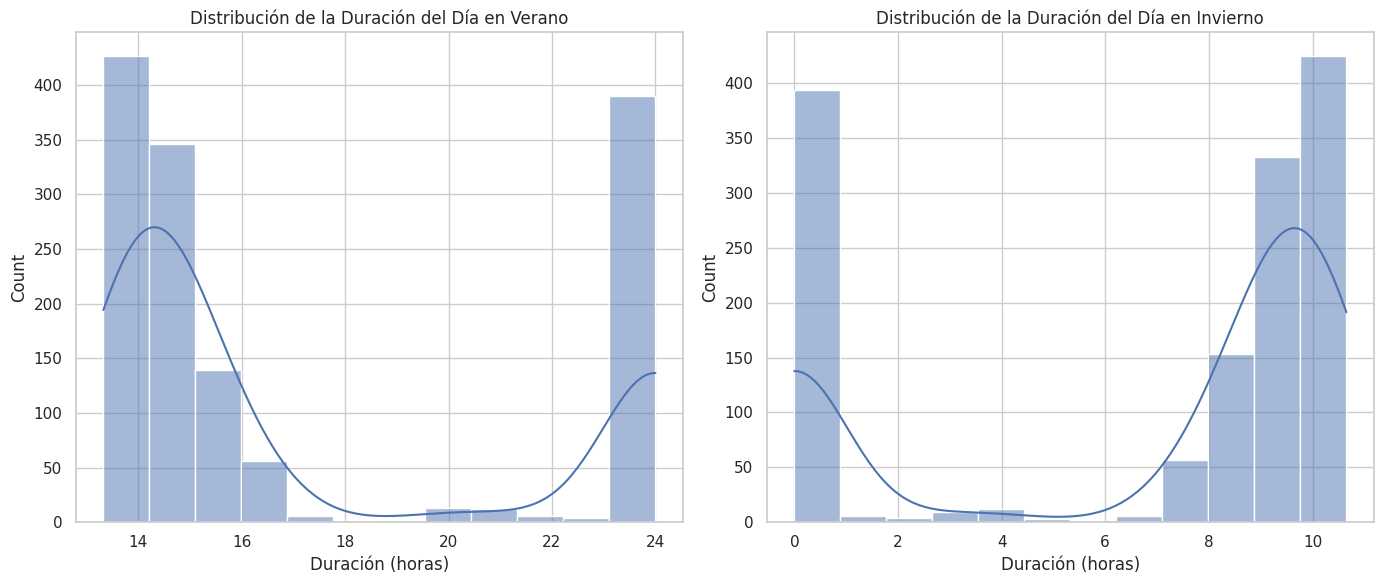

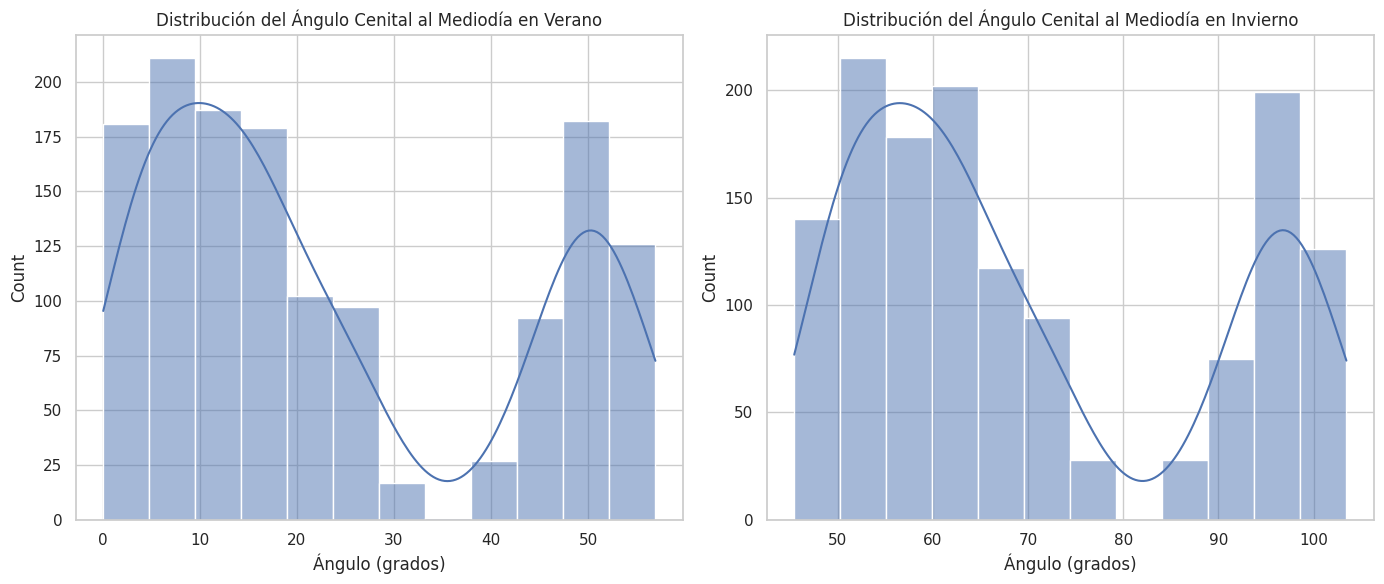

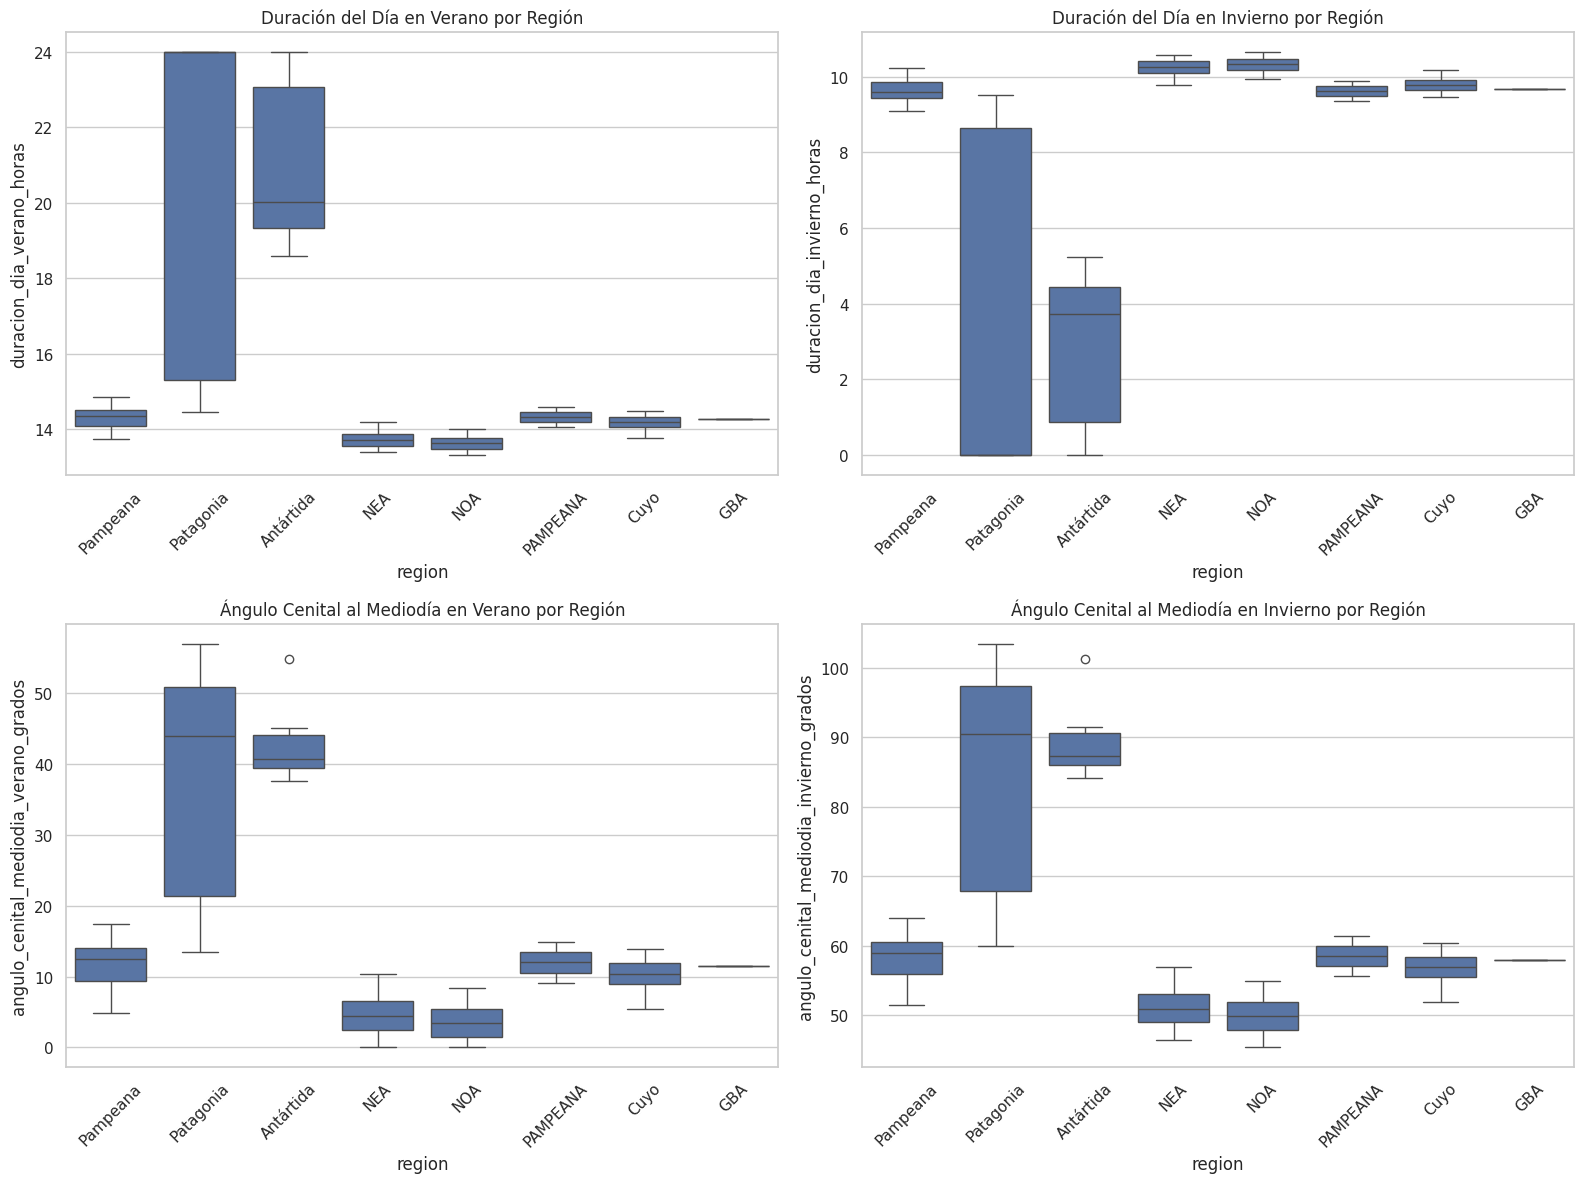

In [ ]:
# Análisis exploratorio de las nuevas variables astronómicas calculadas en la celda anterior
df = pd.read_csv('datos/dataset_cleaned_tabular_engineered.csv')

# Configuración general de los gráficos
sns.set_theme(style="whitegrid")

# 1. Distribución de la Duración del Día en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['duracion_dia_verano_horas'], kde=True)
plt.title('Distribución de la Duración del Día en Verano')
plt.xlabel('Duración (horas)')

plt.subplot(1, 2, 2)
sns.histplot(df['duracion_dia_invierno_horas'], kde=True)
plt.title('Distribución de la Duración del Día en Invierno')
plt.xlabel('Duración (horas)')

plt.tight_layout()
plt.show()

# 2. Distribución del Ángulo Cenital al Mediodía en Verano e Invierno
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['angulo_cenital_mediodia_verano_grados'], kde=True)
plt.title('Distribución del Ángulo Cenital al Mediodía en Verano')
plt.xlabel('Ángulo (grados)')

plt.subplot(1, 2, 2)
sns.histplot(df['angulo_cenital_mediodia_invierno_grados'], kde=True)
plt.title('Distribución del Ángulo Cenital al Mediodía en Invierno')
plt.xlabel('Ángulo (grados)')

plt.tight_layout()
plt.show()

# 4. Boxplots comparando las variables astronómicas por región
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(ax=axes[0, 0], x='region', y='duracion_dia_verano_horas', data=df)
axes[0, 0].set_title('Duración del Día en Verano por Región')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[0, 1], x='region', y='duracion_dia_invierno_horas', data=df)
axes[0, 1].set_title('Duración del Día en Invierno por Región')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1, 0], x='region', y='angulo_cenital_mediodia_verano_grados', data=df)
axes[1, 0].set_title('Ángulo Cenital al Mediodía en Verano por Región')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axes[1, 1], x='region', y='angulo_cenital_mediodia_invierno_grados', data=df)
axes[1, 1].set_title('Ángulo Cenital al Mediodía en Invierno por Región')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Aqui es importante destacar observando los histogramas y diagramas de cajas la gran diversidad de datos que disponemos analizando el territoria Argentino. Esto debido a su gran extension geografica. Lo cual nos aporta un gran valor pudiendo conformar una dataset cuya representacion de la poblacion es representativa en terminos estadisticos. 

### Proceso de incorporacion de una variable target mas precisa y valiosa - 4.1
El proyecto Prediction Of Worldwide Energy Resources (POWER) de la NASA es la solución idónea para este desafío. Ofrece un conjunto de datos de acceso libre y gratuito, con parámetros solares y meteorológicos derivados de observaciones satelitales (como los del proyecto CERES) y modelos de asimilación.8 De manera crucial, POWER proporciona los parámetros exactos necesarios para este análisis: GHI, DNI y DHI, disponibles en series temporales horarias y diarias con una cobertura global que abarca varias décadas.


In [ ]:
dataset_file = 'datos/dataset_cleaned_tabular_engineered.csv'

try:
    df_stations = pd.read_csv(dataset_file)
except FileNotFoundError:
    print(f"El archivo '{dataset_file}' no fue encontrado.")
    exit()

variables = {
    'ALLSKY_SFC_SW_DWN': 'ghi',
    'ALLSKY_SFC_SW_DIFF': 'dhi',
    'ALLSKY_SFC_SW_DNI': 'dni'
}

''' Esta esta es similar a la etapa de augmentacion del dataset introducida anteriormente. Ahora se consumen las variables:
        - ALLSKY_SFC_SW_DWN: irradiancia horizontal global (GHI, por sus siglas en inglés)
        - ALLSKY_SFC_SW_DIFF: irradiancia horizontal difusa (DHI, por sus siglas en inglés)
        - ALLSKY_SFC_SW_DNI: irradiancia normal directa (DNI, por sus siglas en inglés)
    El target inicialmente se definira como GHI pero, es posible que un futuro se contemple alguna combinacion mas valiosa entre estas variables. Por ejemplo DNI/GHI.
'''

# Función para procesar una estación y una variable
def fetch_monthly_average(station_row, nasa_variable, target_variable):
    lat = station_row['latitud']
    lon = station_row['longitud']
    station_name = station_row['estacion']

    api_url = (
        f"https://power.larc.nasa.gov/api/temporal/monthly/point"
        f"?parameters={nasa_variable}&community=SB&longitude={lon}"
        f"&latitude={lat}&start=1991&end=2020&format=JSON"
    )

    try:
        response = requests.get(api_url, timeout=30)
        response.raise_for_status()
        data = response.json()
        data_raw = data.get('properties', {}).get('parameter', {}).get(nasa_variable, {})
        if not data_raw:
            return station_name, [np.nan]*12  # Ningún dato disponible

        df = pd.DataFrame.from_dict(data_raw, orient='index', columns=[f'{target_variable}_mensual'])
        df.replace(-999, np.nan, inplace=True)
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'fecha_str'}, inplace=True)
        df['fecha'] = pd.to_datetime(df['fecha_str'], format='%Y%m', errors='coerce')
        df.dropna(subset=['fecha'], inplace=True)
        df['mes'] = df['fecha'].dt.month
        monthly_avg = df.groupby('mes')[f'{target_variable}_mensual'].mean().to_dict()
        monthly_values = [monthly_avg.get(i, np.nan) for i in range(1, 13)]
        return station_name, monthly_values

    except requests.exceptions.RequestException as e:
        print(f"\nError en la solicitud para {station_name}, variable {target_variable}: {e}")
    except (KeyError, TypeError, AttributeError) as e:
        print(f"\nError procesando JSON para {station_name}, variable {target_variable}: {e}")

    return station_name, [np.nan]*12  # Fallback en caso de error

# Número de threads a usar (ajustar según ancho de banda y CPU)
max_workers = 6

for nasa_variable, target_variable in variables.items():
    print(f"\nProcesando variable {target_variable} en paralelo...")
    df_monthly_avg = pd.DataFrame(columns=['estacion'] + [f'{target_variable}_mensual_promedio_{i:02d}' for i in range(1, 13)])

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(fetch_monthly_average, row, nasa_variable, target_variable): idx
            for idx, row in df_stations.iterrows()
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Obteniendo {target_variable}"):
            station_name, monthly_values = future.result()
            new_row = pd.Series([station_name] + monthly_values, index=df_monthly_avg.columns)
            df_monthly_avg = pd.concat([df_monthly_avg, new_row.to_frame().T], ignore_index=True)

    # Calcular promedio anual
    df_monthly_avg[target_variable] = df_monthly_avg[[f'{target_variable}_mensual_promedio_{i:02d}' for i in range(1, 13)]].mean(axis=1)
    df_final = df_monthly_avg[['estacion', target_variable]].copy()
    df_stations = pd.merge(df_stations, df_final, on='estacion', how='left')

# Guardar dataset final
df_stations.to_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv', index=False)
print("\n¡Proceso completado y dataset guardado!")



Procesando variable ghi en paralelo...


Obteniendo ghi:   1%|▏         | 20/1401 [00:19<08:42,  2.64it/s] 


Error en la solicitud para coronel_pringles_aero, variable ghi: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DWN&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo ghi:   2%|▏         | 27/1401 [00:25<12:23,  1.85it/s]


Error en la solicitud para el_trebol, variable ghi: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DWN&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo ghi:  99%|█████████▊| 1382/1401 [18:35<00:11,  1.65it/s]


Error en la solicitud para san_miguel, variable ghi: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DWN&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo ghi: 100%|██████████| 1401/1401 [18:53<00:00,  1.24it/s]



Procesando variable dhi en paralelo...


Obteniendo dhi:   1%|▏         | 19/1401 [00:15<10:16,  2.24it/s] 


Error en la solicitud para coronel_pringles_aero, variable dhi: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DIFF&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo dhi:   2%|▏         | 25/1401 [00:21<13:35,  1.69it/s]


Error en la solicitud para el_trebol, variable dhi: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DIFF&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo dhi:  99%|█████████▊| 1380/1401 [19:17<00:15,  1.34it/s]


Error en la solicitud para san_miguel, variable dhi: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DIFF&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo dhi: 100%|██████████| 1401/1401 [19:33<00:00,  1.19it/s]



Procesando variable dni en paralelo...


Obteniendo dni:   1%|▏         | 18/1401 [00:14<11:19,  2.03it/s] 


Error en la solicitud para coronel_pringles_aero, variable dni: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DNI&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo dni:   2%|▏         | 26/1401 [00:19<10:10,  2.25it/s]


Error en la solicitud para el_trebol, variable dni: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DNI&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo dni:  99%|█████████▊| 1382/1401 [17:10<00:09,  2.03it/s]


Error en la solicitud para san_miguel, variable dni: 422 Client Error:  for url: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DNI&community=SB&longitude=nan&latitude=nan&start=1991&end=2020&format=JSON


Obteniendo dni: 100%|██████████| 1401/1401 [17:24<00:00,  1.34it/s]


¡Proceso completado y dataset guardado!


### Visualizacion del mapa de GHI y diagramas de dispercion 4.2

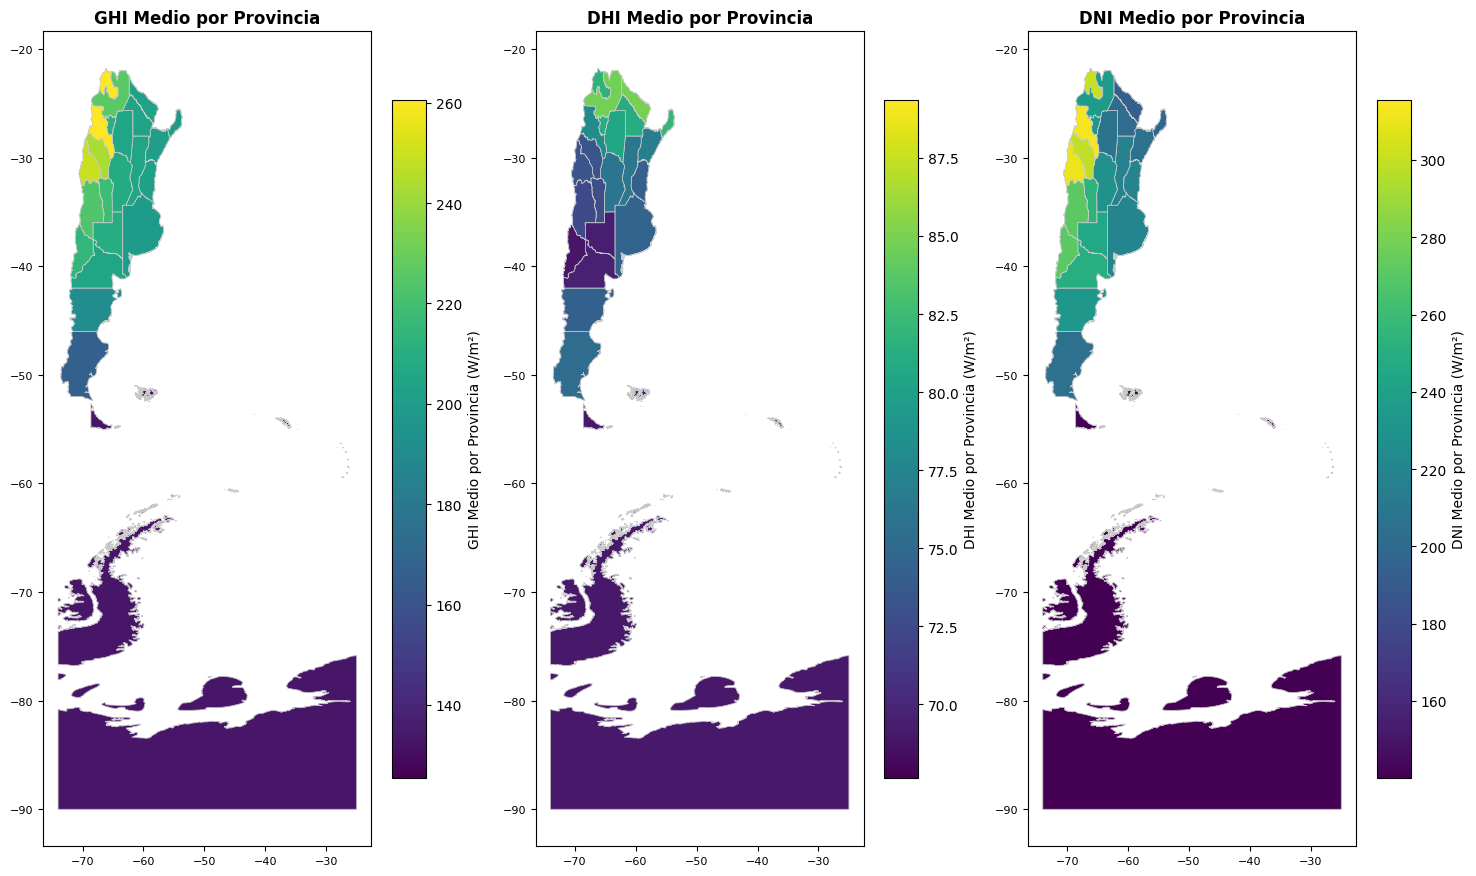

In [ ]:
# =============================================================================
# 📊 MAPAS DE IRRADIANCIA POR PROVINCIA
# =============================================================================

def create_compact_map(df, target_var, title, ax):
    """Función auxiliar para crear mapas compactos de irradiancia por provincia"""
    df_prov = df.groupby('provincia')[target_var].mean().reset_index()
    df_prov.rename(columns={target_var: 'target_media'}, inplace=True)
    df_prov['provincia_limpia'] = df_prov['provincia'].apply(limpiar_texto)
    
    mapa_correcciones = {
        'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
        'santiago_del_es': 'santiago_del_estero',
        'capital_federal': 'ciudad_autonoma_de_buenos_aires'
    }
    df_prov['provincia_limpia'] = df_prov['provincia_limpia'].replace(mapa_correcciones)
    
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
    mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)
    
    mapa_final = pd.merge(mapa_provincias, df_prov, on='provincia_limpia', how='left')
    
    mapa_final.plot(
        column='target_media', ax=ax, legend=True, cmap='viridis',
        linewidth=0.5, edgecolor='0.8',
        missing_kwds={"color": "lightgrey", "hatch": "///"},
        legend_kwds={'label': f"{title} (W/m²)", 'shrink': 0.8}
    )
    ax.set_title(title, fontsize=12, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=8)
fig, axes = plt.subplots(1, 3, figsize=(18, 11)) 

# Crear los mapas provinciales individuales
df_stations = pd.read_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv')
create_compact_map(df_stations, target_var='ghi',  title='GHI Medio por Provincia', ax=plt.subplot(1, 3, 1))
create_compact_map(df_stations, target_var='dhi',  title='DHI Medio por Provincia', ax=plt.subplot(1, 3, 2))
create_compact_map(df_stations, target_var='dni',  title='DNI Medio por Provincia', ax=plt.subplot(1, 3, 3))

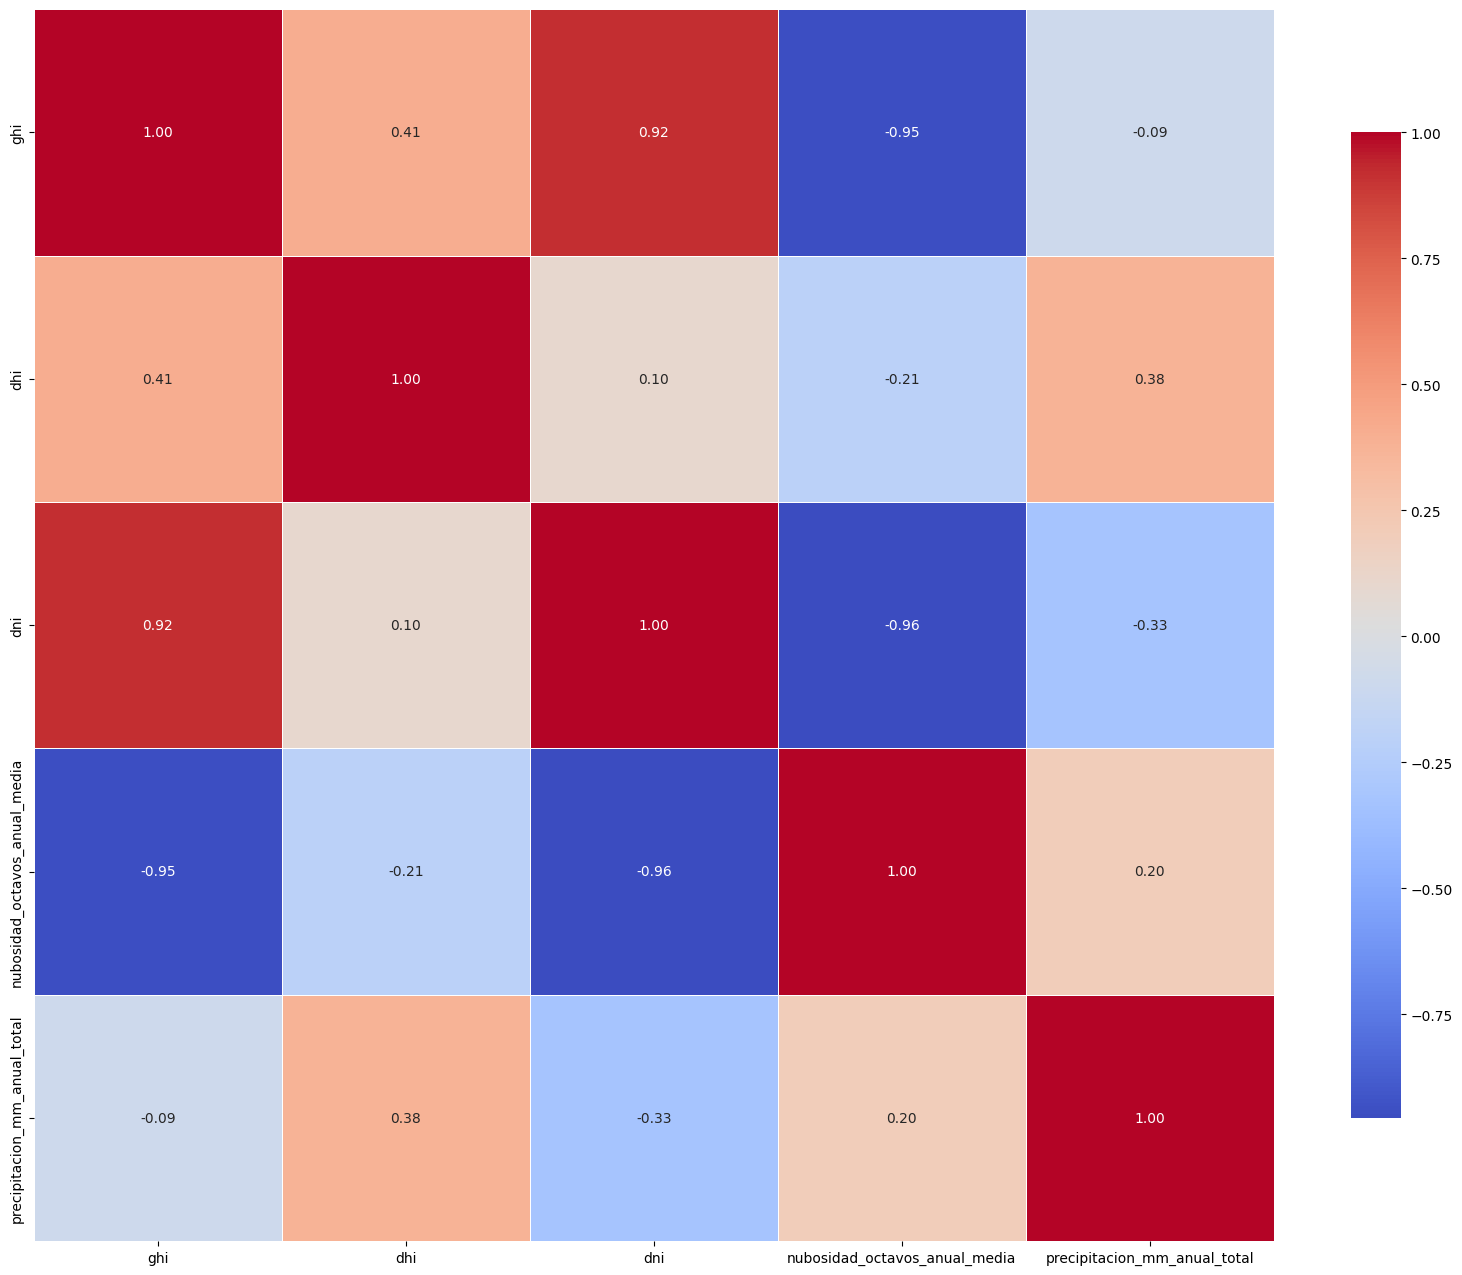

In [16]:
# =============================================================================
# 📊 ANÁLISIS DE CORRELACIÓN
# =============================================================================

# Crear una figura con múltiples subplots organizados
fig = plt.figure(figsize=(20, 16))

correlation_matrix = df_stations[[
    'ghi', 'dhi', 'dni', 'nubosidad_octavos_anual_media', 'precipitacion_mm_anual_total'
]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, 
           fmt=".2f", cbar_kws={'shrink': 0.8})

plt.show()

/tmp/ipykernel_428238/3689427335.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_428238/3689427335.py:46: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.savefig('graficos/precipitacion_altura_vs_irradiancia.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_428238/3689427335.py:46: UserWarning: Glyph 127956 (\N{SNOW CAPPED MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.savefig('graficos/precipitacion_altura_vs_irradiancia.png', dpi=300, bbox_inches='tight')
/home/rodrigo/Desktop/Maestria/solar-energy-suggester/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rodrigo/Desktop/Maestria/solar-energy-suggester/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 

/tmp/ipykernel_428238/3689427335.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_428238/3689427335.py:46: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.savefig('graficos/precipitacion_altura_vs_irradiancia.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_428238/3689427335.py:46: UserWarning: Glyph 127956 (\N{SNOW CAPPED MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.savefig('graficos/precipitacion_altura_vs_irradiancia.png', dpi=300, bbox_inches='tight')
/home/rodrigo/Desktop/Maestria/solar-energy-suggester/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rodrigo/Desktop/Maestria/solar-energy-suggester/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 

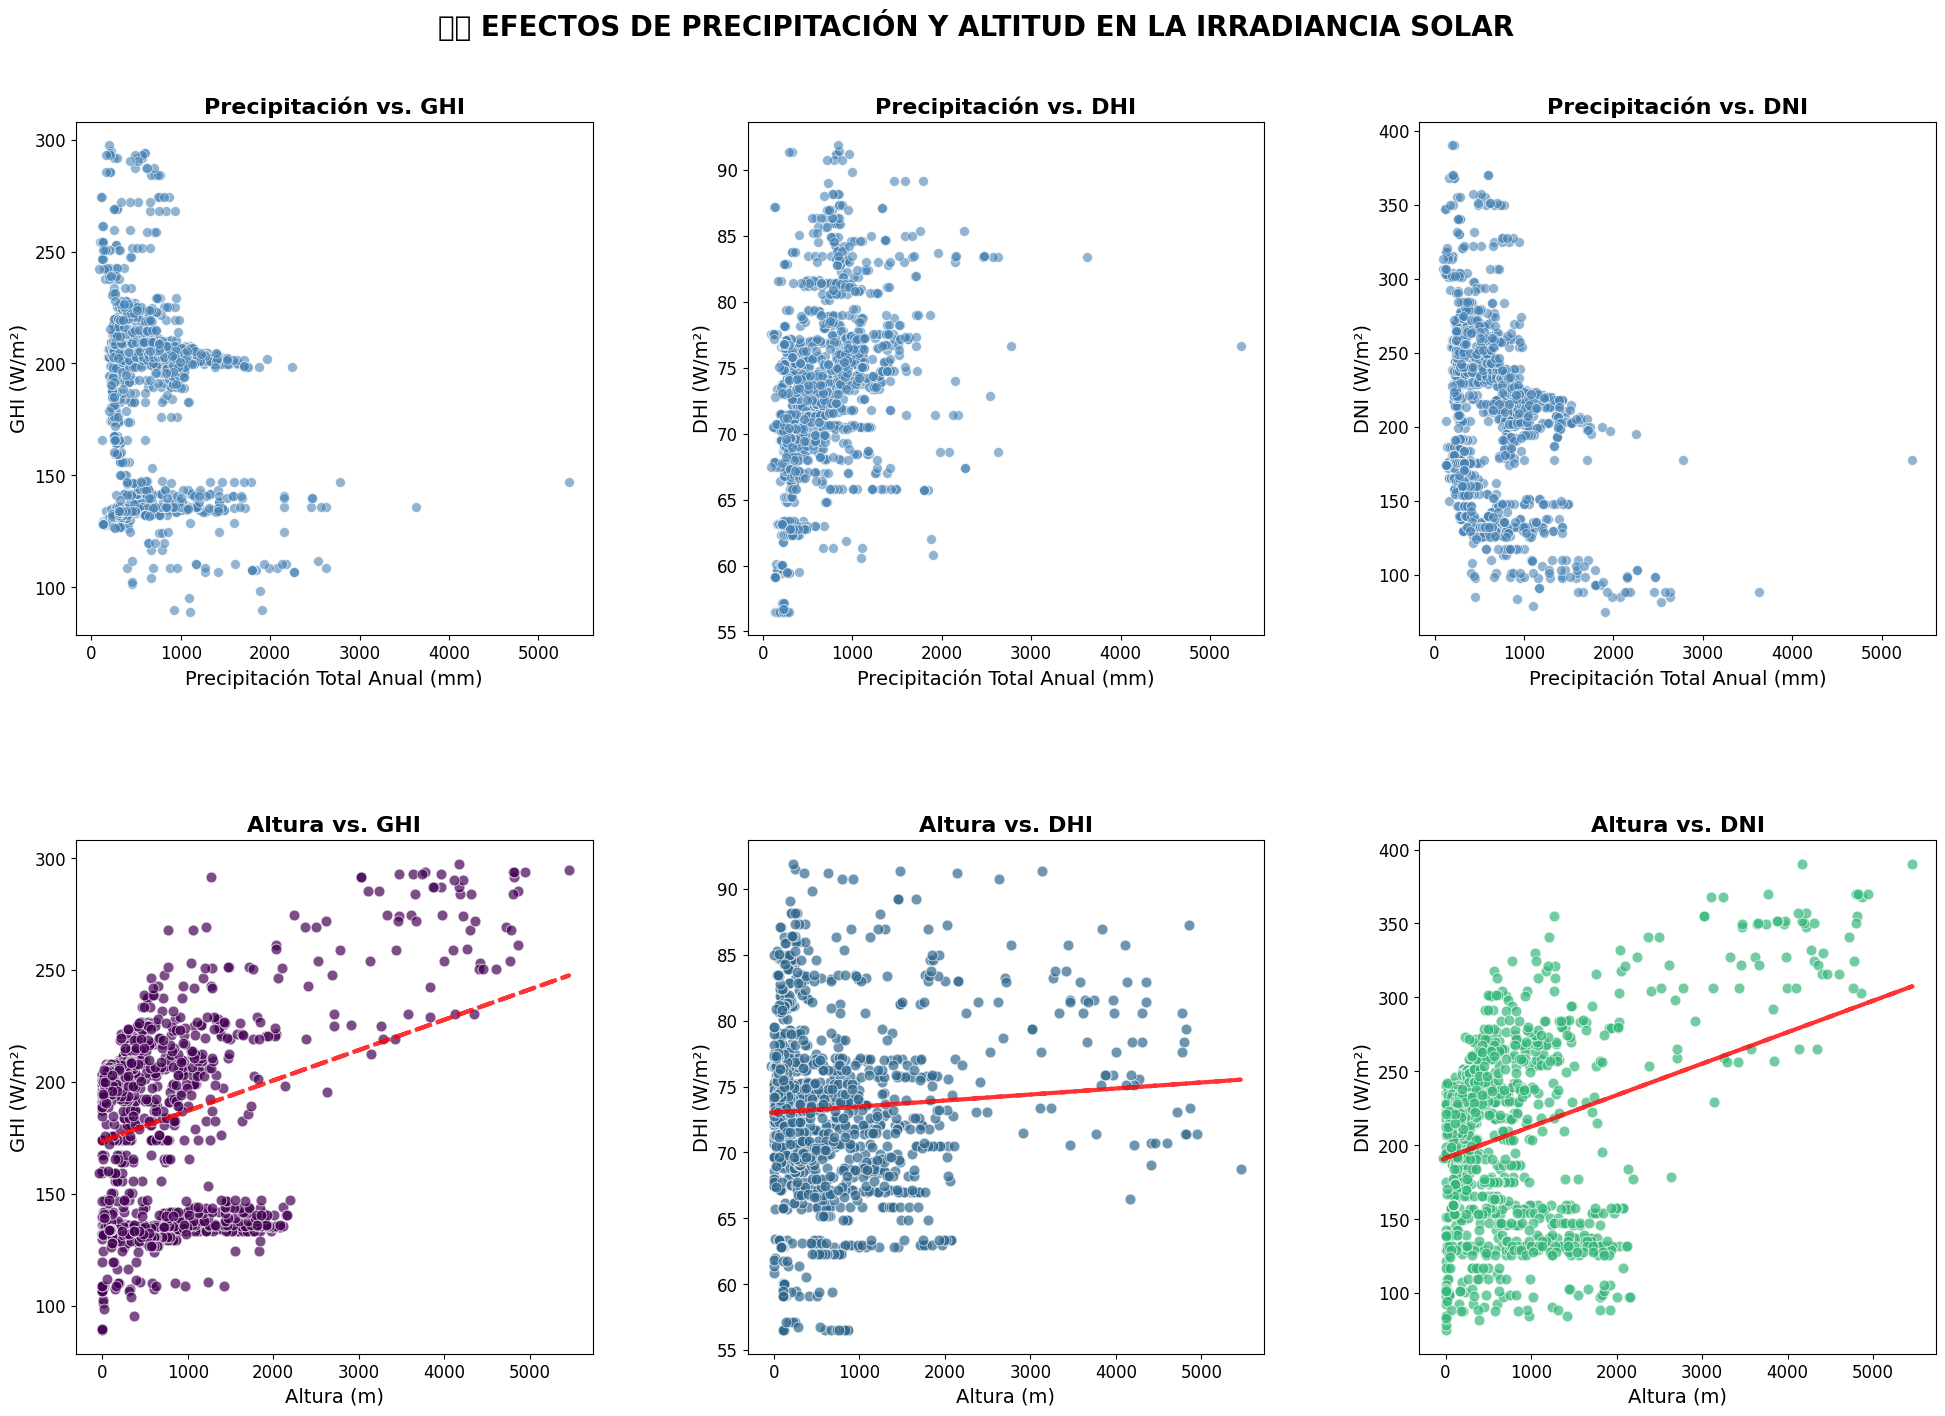

In [18]:
# =============================================================================
# 🌧️🏔️ ANÁLISIS DE PRECIPITACIÓN Y EFECTOS ALTITUDINALES
# =============================================================================

# Panel para análisis de precipitación y altura - FIGURA MÁS GRANDE
fig_combined = plt.figure(figsize=(24, 16))  # Aumentado de (20, 12) a (24, 16)

# Crear grilla para dos filas con más espacio
gs_combined = fig_combined.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.4, wspace=0.3)  # Aumentado el espacio

# --- 1. DIAGRAMAS DE DISPERSIÓN: PRECIPITACIÓN VS IRRADIANCIA (FILA 1) ---
variables_target = ['ghi', 'dhi', 'dni']
titles_target = ['GHI', 'DHI', 'DNI']

for i, (var, title) in enumerate(zip(variables_target, titles_target)):
    ax = fig_combined.add_subplot(gs_combined[0, i])
    sns.scatterplot(ax=ax, x='precipitacion_mm_anual_total', y=var, 
                   data=df_stations, alpha=0.6, s=50, color='steelblue')  # Aumentado el tamaño de puntos
    ax.set_title(f'Precipitación vs. {title}', fontsize=16, weight='bold')  # Aumentado el tamaño de fuente
    ax.set_xlabel('Precipitación Total Anual (mm)', fontsize=14)  # Aumentado el tamaño de fuente
    ax.set_ylabel(f'{title} (W/m²)', fontsize=14)  # Aumentado el tamaño de fuente
    ax.tick_params(labelsize=12)  # Aumentado el tamaño de las etiquetas

# --- 2. ANÁLISIS ALTITUDINAL DE LA IRRADIANCIA (FILA 2) ---
for i, (var, title) in enumerate(zip(variables_target, titles_target)):
    ax = fig_combined.add_subplot(gs_combined[1, i])
    sns.scatterplot(ax=ax, x='altura', y=var, data=df_stations, 
                   alpha=0.7, s=60, color=plt.cm.viridis(i/3))  # Aumentado el tamaño de puntos
    ax.set_title(f'Altura vs. {title}', fontsize=16, weight='bold')  # Aumentado el tamaño de fuente
    ax.set_xlabel('Altura (m)', fontsize=14)  # Aumentado el tamaño de fuente
    ax.set_ylabel(f'{title} (W/m²)', fontsize=14)  # Aumentado el tamaño de fuente
    ax.tick_params(labelsize=12)  # Aumentado el tamaño de las etiquetas
    
    # Agregar línea de tendencia con mayor grosor
    z = np.polyfit(df_stations['altura'].dropna(), 
                   df_stations[var].dropna(), 1)
    p = np.poly1d(z)
    ax.plot(df_stations['altura'], p(df_stations['altura']), 
            "r--", alpha=0.8, linewidth=3)  # Aumentado el grosor de la línea

# Título general del panel combinado con mayor tamaño
fig_combined.suptitle('🌧️🏔️ EFECTOS DE PRECIPITACIÓN Y ALTITUD EN LA IRRADIANCIA SOLAR', 
                     fontsize=20, weight='bold', y=0.95)  # Aumentado el tamaño de fuente

plt.tight_layout()
plt.savefig('graficos/precipitacion_altura_vs_irradiancia.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_24060/3608580503.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  argentina_polygon = pais_completo.unary_union


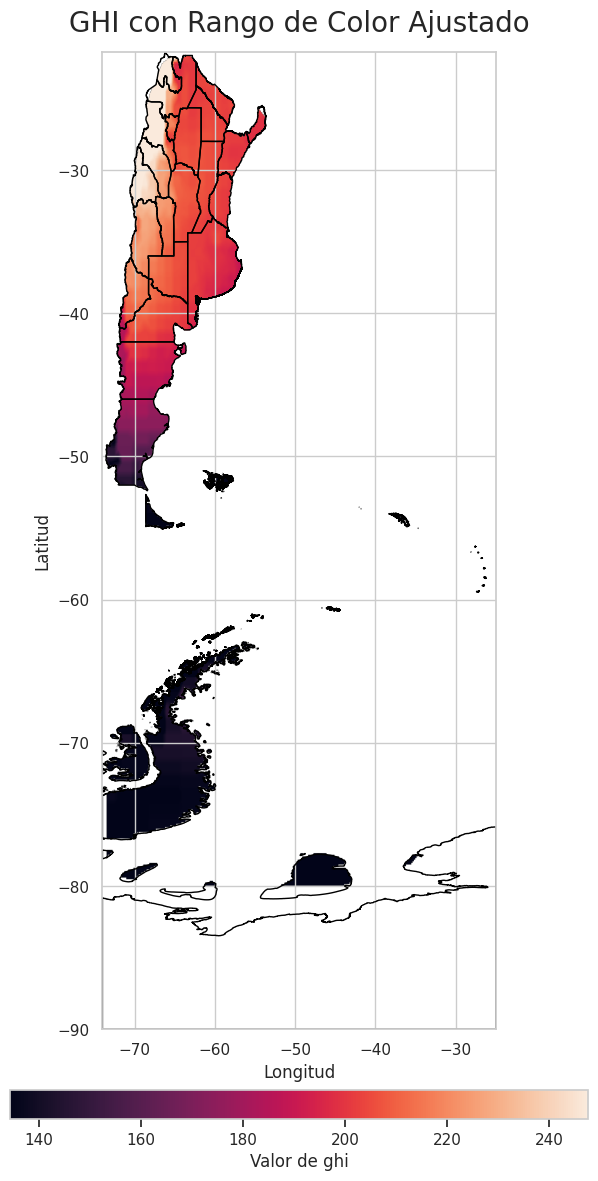

In [ ]:
# Se pensó en usar un mapa de calor para visualizar la irradiancia, pero se optó por un mapa de calor con interpolación espacial para una mejor visualización geográfica.
# Creemos que esta representación es más efectiva que los promedios provinciales para mostrar la distribución espacial de la irradiancia en Argentina.


def generar_mapa_final_sjoin(df, variable_a_mapear, cmap=None, titulo=None, grid_resolution=300, vmin=None, vmax=None):
    # --- 1. DATOS ---
    df_valid = df.dropna(subset=['longitud', 'latitud', variable_a_mapear])
    if df_valid.empty:
        print("No hay datos válidos para graficar.")
        return

    points = df_valid[['longitud', 'latitud']].values
    values = df_valid[variable_a_mapear].values

    # --- 2. MAPA ---
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    try:
        mapa_provincias = geopandas.read_file(ruta_mapa_provincias)
        pais_completo = mapa_provincias.dissolve()
        argentina_polygon = pais_completo.unary_union
    except Exception as e:
        print(f"Error cargando el mapa: {e}")
        return

    # --- 3. MALLA E INTERPOLACIÓN ---
    min_lon, min_lat, max_lon, max_lat = argentina_polygon.bounds
    x_coords = np.linspace(min_lon, max_lon, grid_resolution)
    y_coords = np.linspace(min_lat, max_lat, grid_resolution)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)

    interpolator = LinearNDInterpolator(points, values)
    grid_z = interpolator(grid_x, grid_y)

    # --- 4. MÁSCARA VÍA SJOIN ---
    gdf_grid = geopandas.GeoDataFrame(
        geometry=geopandas.points_from_xy(grid_x.ravel(), grid_y.ravel()),
        crs=mapa_provincias.crs
    )
    gdf_arg = geopandas.GeoDataFrame(geometry=[argentina_polygon], crs=mapa_provincias.crs)

    # Solo conservar puntos dentro de Argentina
    inside_points = geopandas.sjoin(gdf_grid, gdf_arg, how="inner")
    mask = np.zeros(gdf_grid.shape[0], dtype=bool)
    mask[inside_points.index] = True
    mask = mask.reshape(grid_x.shape)

    grid_z[~mask] = np.nan

    # --- 5. PLOTEO ---
    fig, ax = plt.subplots(figsize=(10, 13))
    ax.set_aspect('equal')
    if titulo is None:
        titulo = f'Mapa de Calor de "{variable_a_mapear.replace("_", " ").title()}"'

    im = ax.imshow(grid_z, extent=(min_lon, max_lon, min_lat, max_lat),
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    mapa_provincias.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.0)

    ax.set_title(titulo, fontsize=20, pad=15)
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')

    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.6)
    cbar.set_label(f'Valor de {variable_a_mapear}')
    plt.tight_layout()
    plt.show()



df_stations = pd.read_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv')
vmin_ajustado = df_stations['ghi'].quantile(0.15)
vmax_ajustado = df_stations['ghi'].quantile(0.95)

generar_mapa_final_sjoin(
    df=df_stations,
    variable_a_mapear='ghi',
    vmin=vmin_ajustado,
    vmax=vmax_ajustado,
    titulo='GHI con Rango de Color Ajustado',
    grid_resolution=600
)



--- 2. Generando Mapa de Puntos (sin interpolación) ---


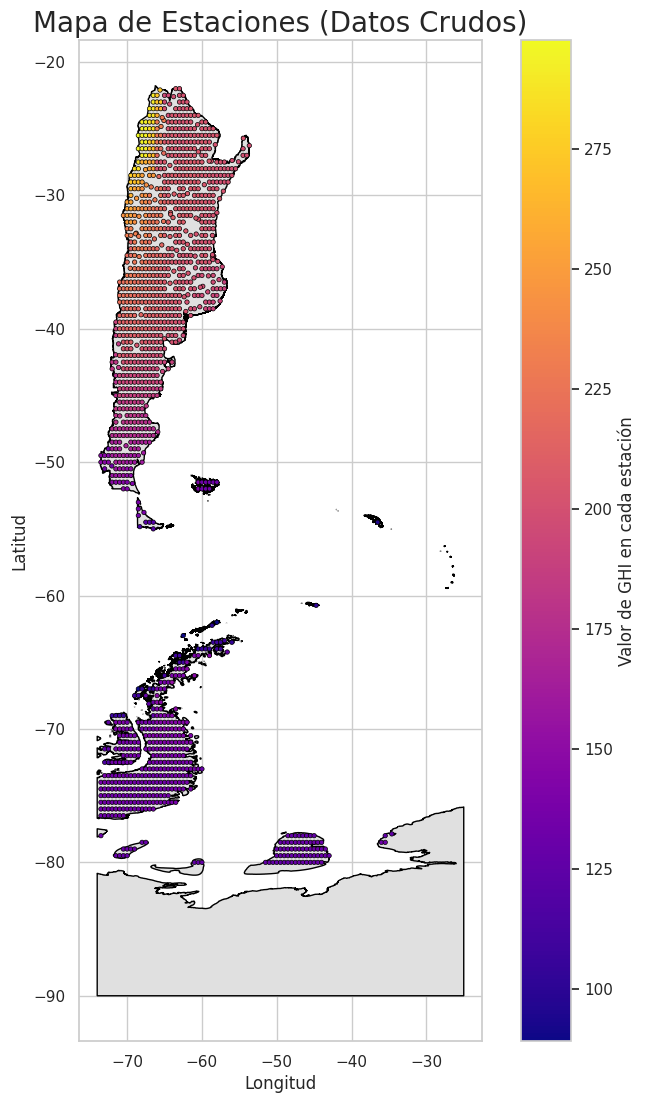

In [114]:
# Se verifican todos los datos de los puntos crudos de ghi
try:
    # 1. MAPA DE PUNTOS (DATOS CRUDOS)
    print("\n--- 2. Generando Mapa de Puntos (sin interpolación) ---")
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    pais_completo = geopandas.read_file(ruta_mapa_provincias).dissolve()

    fig, ax = plt.subplots(1, 1, figsize=(10, 13))
    
    # Dibujar el contorno del país como fondo
    pais_completo.plot(ax=ax, facecolor='#E0E0E0', edgecolor='black')

    # Dibujar un punto por cada estación. El color de cada punto es su valor de GHI.
    scatter = ax.scatter(
        df_stations['longitud'],
        df_stations['latitud'],
        c=df_stations['ghi'],
        cmap='plasma',
        s=10,
        edgecolor='black',
        linewidth=0.5
    )

    ax.set_title('Mapa de Estaciones (Datos Crudos)', fontsize=20)
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    fig.colorbar(scatter, label='Valor de GHI en cada estación')
    plt.show()

except NameError:
    print("\nERROR: No se encontró el DataFrame llamado 'df_stations'. Asegúrate de que esté cargado.")
except KeyError:
    print("\nERROR: No se encontró una de las columnas requeridas ('longitud', 'latitud', 'ghi').")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

## Selección de Variables Predictoras - *Features*

### Geográficas
- **Latitud** (grados)  
- **Longitud** (grados)  
- **Altura** (metros sobre el nivel del mar)  

### Astronómicas
- **Ángulo cenital en el solsticio de verano al mediodía** (grados)  
- **Ángulo cenital en el solsticio de invierno al mediodía** (grados)  
- **Duración del día en horas el primer día de invierno**  
- **Duración del día en horas el primer día de verano**  

### Meteorológicas
En principio, se hará uso de todas las variables meteorológicas disponibles, así como de aquellas generadas mediante técnicas de *feature engineering*.

> Cabe destacar que este proceso se ha realizado **antes del particionado** del conjunto de datos (*split*), debido a la naturaleza del mismo: se dispone de **N filas independientes**, cada una correspondiente a una estación meteorológica con sus respectivas características. Esto permite generar nuevas variables por fila sin incurrir en riesgo de *data leakage*.



In [21]:
# Se eliminan las columnas que no aportan valor predictivo, que son redundantes o generan fuga de datos.
df_stations = pd.read_csv('datos/dataset_cleaned_tabular_engineered_with_target.csv')
# Lista de columnas a eliminar
columnas_a_eliminar = [
    # 1. Fuga de datos 
    'dhi',
    'dni',
    
    # 2. Identificadores (no aportan valor predictivo numérico)
    'estacion',
    'oaci',
    'nro',
    
    # 3. Variables astronómicas
    'declinacion_verano_grados',
    'declinacion_invierno_grados',
    'duracion_dia_verano_horas',
    'duracion_dia_invierno_horas',
    'angulo_cenital_mediodia_verano_grados',
    'angulo_cenital_mediodia_invierno_grados',
    'G0_invierno_W_m2',
    'G0_verano_W_m2'
]
df_stations_limpio=df_stations.drop(columns=columnas_a_eliminar, axis=1)

In [22]:
# Muestra las primeras filas del nuevo DataFrame
df_stations_limpio.head()

provincia     region  latitud  longitud  altura  \
0  CAPITAL FEDERAL   Pampeana -34.5500  -58.4167     6.0   
1     BUENOS AIRES   Pampeana -36.8167  -59.8833   147.0   
2     BUENOS AIRES   Pampeana -38.7000  -62.1500    83.0   
3        RIO NEGRO  Patagonia -41.1333  -71.1500   835.0   
4        ANTARTIDA  Antártida -77.8667  -34.6167   256.0   

   frecuencia_dias_precipitacion_gt_1mm_anual_amplitud  \
0                                               3.00     
1                                               3.90     
2                                               3.20     
3                                              10.80     
4                                               0.88     

   frecuencia_dias_precipitacion_gt_1mm_anual_cv  \
0                                         0.1572   
1                                         0.2332   
2                                         0.1973   
3                                         0.5631   
4                                         0.0847   

   frecuencia_dias_precipitacion_gt_1mm_anual_max  \
0                                            7.50   
1                                            7.30   
2                                            6.70   
3                                           13.30   
4                                            4.54   

   frecuencia_dias_precipitacion_gt_1mm_anual_media  \
0                                            5.9250   
1                                            5.5583   
2                                            4.9750   
3                                            6.8167   
4                                            4.2900   

   frecuencia_dias_precipitacion_gt_1mm_anual_min  ...  \
0                                            4.50  ...   
1                                            3.40  ...   
2                                            3.50  ...   
3                                            2.50  ...   
4                                            3.66  ...   

   temperatura_maxima_c_anual_std  temperatura_maxima_c_anual_total  \
0                          4.9780                             259.3   
1                          5.7768                             254.0   
2                          6.1846                             269.1   
3                          6.0604                             179.2   
4                          6.8086                            -117.0   

   temperatura_minima_c_anual_amplitud  temperatura_minima_c_anual_cv  \
0                                 12.4                         0.3025   
1                                 12.2                         0.5673   
2                                 13.9                         0.5300   
3                                  8.6                         1.2221   
4                                 18.9                        -0.3952   

   temperatura_minima_c_anual_max  temperatura_minima_c_anual_media  \
0                            20.8                           14.7250   
1                            14.0                            7.7917   
2                            16.3                            9.2417   
3                             7.0                            2.5167   
4                            -6.1                          -17.3833   

   temperatura_minima_c_anual_min  temperatura_minima_c_anual_std  \
0                             8.4                          4.4540   
1                             1.8                          4.4199   
2                             2.4                          4.8985   
3                            -1.6                          3.0757   
4                           -25.0                          6.8695   

   temperatura_minima_c_anual_total         ghi  
0                             176.7  199.863917  
1                              93.5  198.299194  
2                             110.9  201.666222  
3                              30.2  183.928194  
4                            

In [23]:
#Todavia quedavan algunos pocos valores nulos, por lo que se procede a eliminarlos
total_nulos = df_stations_limpio.isnull().sum().sum()
print(f"Número total de datos faltantes: {total_nulos}")
# Muestra cuántas filas hay ANTES de la eliminación
print(f"Número de filas antes de eliminar: {len(df_stations_limpio)}")

# Elimina todas las filas que contengan al menos un valor nulo
df_stations_limpio.dropna(inplace=True)

print(f"Número de filas después de eliminar: {len(df_stations_limpio)}")

total_nulos_despues = df_stations_limpio.isnull().sum().sum()
print(f"Número total de datos faltantes ahora: {total_nulos_despues}")

if total_nulos_despues == 0:
    print("\nTodas las filas con valores nulos han sido eliminadas.")
    
    
nombre_archivo_final = 'datos/dataset_para_entrenamiento.csv'


df_stations_limpio.to_csv(nombre_archivo_final, index=False)

print(f"Dataset final guardado exitosamente en '{nombre_archivo_final}'")

Número total de datos faltantes: 0
Número de filas antes de eliminar: 1402
Número de filas después de eliminar: 1402
Número total de datos faltantes ahora: 0

Todas las filas con valores nulos han sido eliminadas.
Dataset final guardado exitosamente en 'datos/dataset_para_entrenamiento.csv'


# Validación Cruzada Espacial en Bloques

Para asegurar que nuestro modelo aprenda a generalizar en lugar de memorizar, implementamos una estrategia de **Validación Cruzada Espacial en Bloques**. El objetivo es evitar que en el conjunto de prueba (`test`) haya estaciones muy cercanas a las del conjunto de entrenamiento (`train`). De esta forma, el modelo se ve forzado a aprender las características climáticas subyacentes en lugar de simplemente asociar una ubicación geográfica específica con un valor objetivo (`ghi`).

El proceso se divide en los siguientes pasos:

### 1. Definición de Zonas de Prueba Geográficas

Primero, tratamos las coordenadas (latitud y longitud) de todas las estaciones como un conjunto de puntos en un mapa. Utilizamos el algoritmo **K-Means** para agrupar estas estaciones en `N_TEST_ZONES` (en este caso, 25) clusters o "zonas". K-Means identifica los centroides de estas zonas, que actúan como los puntos centrales de nuestros futuros bloques de prueba.

### 2. Selección de Estaciones para el Conjunto de Prueba

Una vez que tenemos los centros de las zonas, utilizamos el algoritmo **NearestNeighbors** (Vecinos más Cercanos) para encontrar las `stations_per_zone` (en este caso, 10) estaciones más próximas a cada uno de esos centroides.

- **`zone_centers`**: Son los puntos centrales calculados por K-Means.
- **`stations_per_zone`**: Es la cantidad de estaciones que conformarán cada bloque de prueba.

Todas las estaciones seleccionadas en este paso se agrupan para formar el **conjunto de prueba (`df_test`)**.

### 3. Creación del Conjunto de Entrenamiento

El **conjunto de entrenamiento (`df_train`)** se crea de forma sencilla: son todas las estaciones que **no** fueron seleccionadas para el conjunto de prueba.

### 4. Resultado Final

Este método nos garantiza que el conjunto de prueba esté compuesto por pequeños bloques de estaciones geográficamente agrupadas, mientras que el conjunto de entrenamiento contiene todas las demás estaciones. Al separar los datos de esta manera, evaluamos de forma más robusta la capacidad del modelo para predecir en ubicaciones completamente nuevas para él.

In [24]:

# --- 1. CONFIGURACIÓN ---
df_final = pd.read_csv('datos/dataset_para_entrenamiento.csv')

# --- INICIO DEL CÁLCULO DINÁMICO ---
# Parámetros clave que puedes ajustar
TARGET_TEST_PERCENTAGE = 0.15  # % de los datos para prueba
N_TEST_ZONES = 25              #zonas distribuidas 
RANDOM_STATE = 42

# Cálculo de estaciones por zona
total_stations = len(df_final)
target_test_size = int(total_stations * TARGET_TEST_PERCENTAGE)
stations_per_zone = target_test_size // N_TEST_ZONES
if stations_per_zone == 0:
    stations_per_zone = 1

actual_test_size = N_TEST_ZONES * stations_per_zone
actual_test_percentage = (actual_test_size / total_stations) * 100

print(f"Total de estaciones: {total_stations}")
print(f"Se crearán {N_TEST_ZONES} zonas de prueba con {stations_per_zone} estaciones cada una.")
print(f"Esto resulta en un conjunto de prueba de {actual_test_size} estaciones ({actual_test_percentage:.2f}% del total).")

# --- 2. PREPARACIÓN ---
coords = df_final[['latitud', 'longitud']].values
all_indices = np.arange(len(df_final))

# --- 3. PASO 1: ENCONTRAR LOS CENTROS DE LAS ZONAS DE PRUEBA ---
kmeans = KMeans(n_clusters=N_TEST_ZONES, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(coords)
zone_centers = kmeans.cluster_centers_

# --- 4. PASO 2: SELECCIONAR LAS ESTACIONES ALREDEDOR DE CADA CENTRO ---
nbrs = NearestNeighbors(n_neighbors=stations_per_zone).fit(coords)
distances, indices = nbrs.kneighbors(zone_centers)

test_indices = sorted(list(indices.flatten()))
train_indices = sorted(list(set(all_indices) - set(test_indices)))

# --- 5. CREACIÓN DE LOS DATASETS FINALES ---
df_train = df_final.iloc[train_indices]
df_test = df_final.iloc[test_indices]

for i in range(N_TEST_ZONES):
    zone_station_indices = indices[i]
    zone_station_names = df_final.iloc[zone_station_indices]['region'].tolist()
    print(f"  Zona {i+1}: {zone_station_names}")
X_train = df_train.drop(columns=['ghi', 'provincia', 'region'])
y_train = df_train['ghi']
X_test = df_test.drop(columns=['ghi', 'provincia', 'region'])
y_test = df_test['ghi']

# --- 6. VERIFICACIÓN ---
print("\n--- Resultado de la División por Zonas Distribuidas ---")
print(f"Estaciones totales en el conjunto de prueba: {len(df_test)}")
print(f"Estaciones totales en el conjunto de entrenamiento: {len(df_train)}")
print(f"\nMapa de Zonas de Prueba (Cluster -> Estaciones):")


ruta_guardado = 'datos/'

# Guardar los conjuntos de entrenamiento
X_train.to_csv(ruta_guardado + 'X_train.csv', index=False)
y_train.to_frame().to_csv(ruta_guardado + 'y_train.csv', index=False)

# Guardar los conjuntos de prueba
X_test.to_csv(ruta_guardado + 'X_test.csv', index=False)
y_test.to_frame().to_csv(ruta_guardado + 'y_test.csv', index=False)

print("Archivos guardados exitosamente:")
print(f"- {ruta_guardado}X_train.csv")
print(f"- {ruta_guardado}y_train.csv")
print(f"- {ruta_guardado}X_test.csv")
print(f"- {ruta_guardado}y_test.csv")

Total de estaciones: 1402
Se crearán 25 zonas de prueba con 8 estaciones cada una.
Esto resulta en un conjunto de prueba de 200 estaciones (14.27% del total).
  Zona 1: ['NEA', 'NEA', 'NEA', 'NEA', 'NEA', 'NEA', 'Pampeana', 'NEA']
  Zona 2: ['Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia']
  Zona 3: ['Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia']
  Zona 4: ['Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia']
  Zona 5: ['NEA', 'NEA', 'NEA', 'NEA', 'NEA', 'NEA', 'NEA', 'NEA']
  Zona 6: ['Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia']
  Zona 7: ['Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia']
  Zona 8: ['Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia', 'Patagonia']
  Zona 9: ['

/tmp/ipykernel_276515/424606658.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()


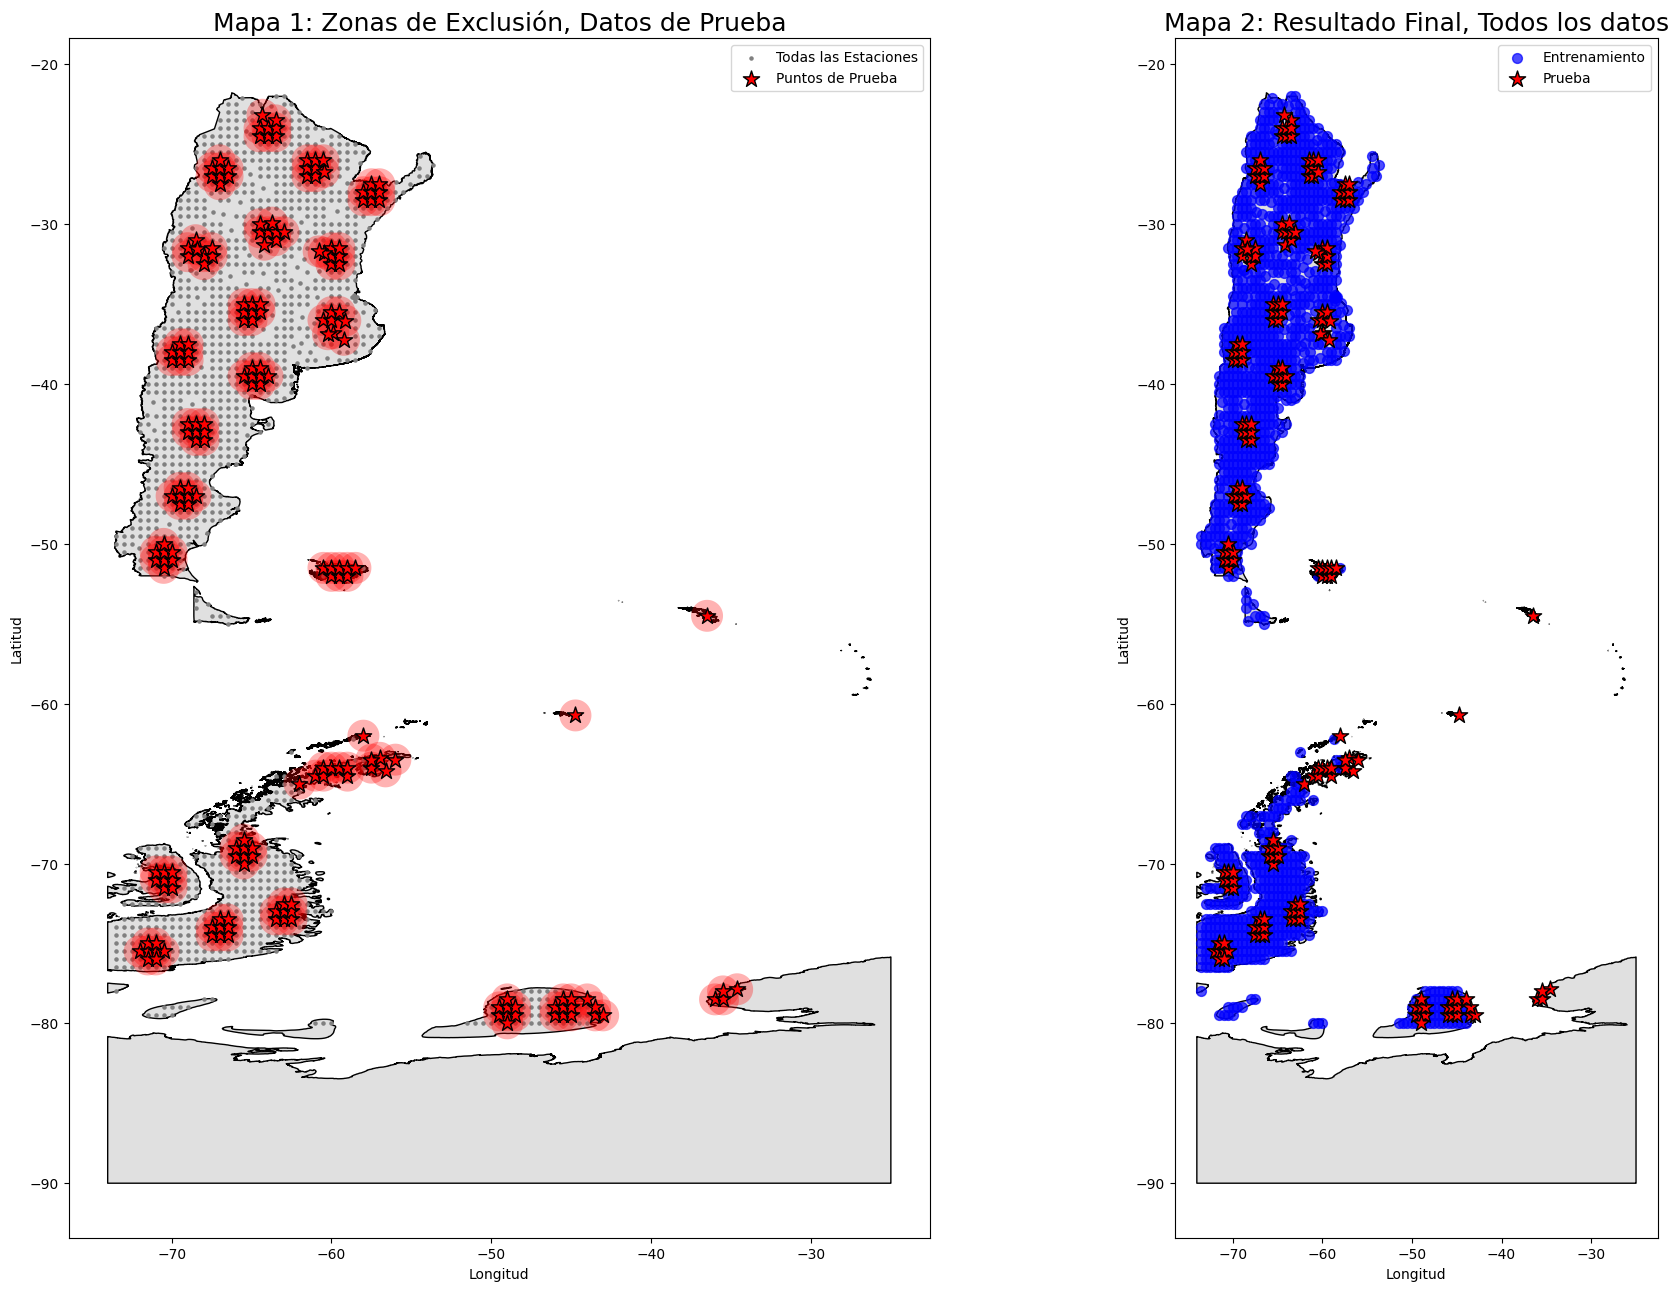

In [7]:
#Se visualizan los dos mapas con las zonas de exclusión (datos de test) y el resultado final con las separacion entre datos de entrenamiento y prueba

BUFFER_RADIUS_DEGREES = 1
# --- 2. PREPARACIÓN DEL MAPA DE FONDO ---
try:
    ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
    pais_completo = geopandas.read_file(ruta_mapa_provincias).dissolve()
except Exception as e:
    print(f"Error al cargar el shapefile: {e}")
    pais_completo = geopandas.GeoDataFrame()

# --- 3. CREACIÓN DE LOS DOS MAPAS ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 13))

# --- MAPA 1: Zonas de Exclusión ---
ax1.set_title('Mapa 1: Zonas de Exclusión, Datos de Prueba', fontsize=18)
pais_completo.plot(ax=ax1, facecolor='#E0E0E0', edgecolor='black')

# Dibujar TODOS los puntos originales en gris claro como referencia
ax1.scatter(df_final['longitud'], df_final['latitud'], color='gray', marker='.', s=20, label='Todas las Estaciones')

# Crear los círculos (buffers) alrededor de los puntos de prueba
gdf_test = geopandas.GeoDataFrame(df_test, geometry=geopandas.points_from_xy(df_test.longitud, df_test.latitud))
buffer_zones = gdf_test.geometry.buffer(BUFFER_RADIUS_DEGREES)

# Dibujar las zonas de exclusión
buffer_zones.plot(ax=ax1, facecolor='red', alpha=0.3, label=f'Zona de Exclusión ({BUFFER_RADIUS_DEGREES}°)')

# Dibujar los puntos de prueba en el centro de los buffers
ax1.scatter(df_test['longitud'], df_test['latitud'], color='red', marker='*', s=150, edgecolor='black', label='Puntos de Prueba')
ax1.set_xlabel('Longitud')
ax1.set_ylabel('Latitud')
ax1.legend()

# --- MAPA 2: Resultado Final de la División ---
ax2.set_title('Mapa 2: Resultado Final, Todos los datos', fontsize=18)
pais_completo.plot(ax=ax2, facecolor='#E0E0E0', edgecolor='black')

# Dibujar los puntos de entrenamiento finales
ax2.scatter(df_train['longitud'], df_train['latitud'], color='blue', marker='o', s=50, alpha=0.7, label='Entrenamiento')

# Dibujar los puntos de prueba finales
ax2.scatter(df_test['longitud'], df_test['latitud'], color='red', marker='*', s=150, edgecolor='black', label='Prueba')
ax2.set_xlabel('Longitud')
ax2.set_ylabel('Latitud')
ax2.legend()

plt.tight_layout()
plt.show()

Generando boxplots contextuales por región para cada variable...


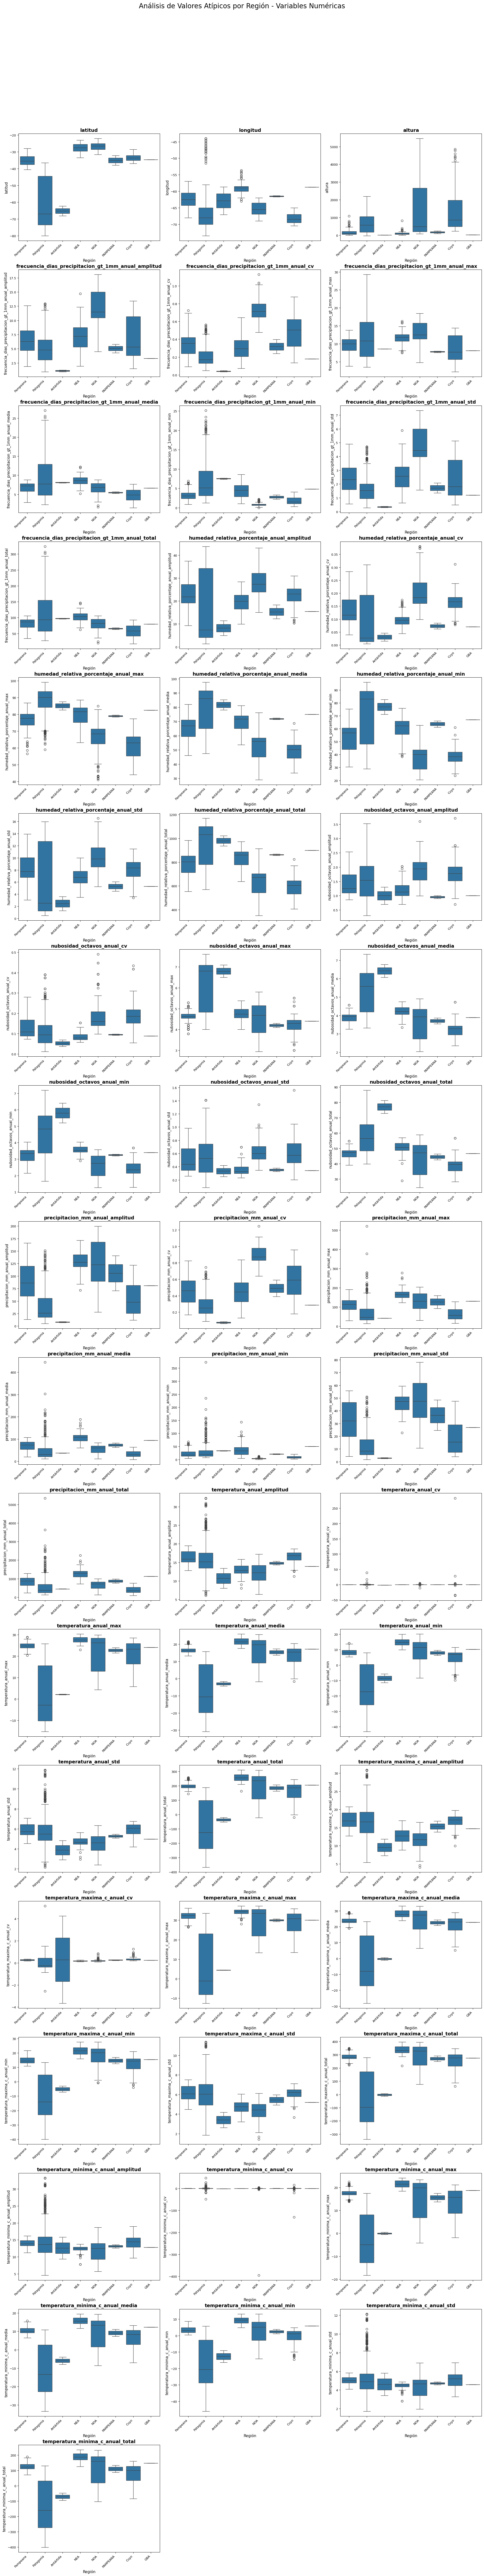

In [8]:
#Se realiza un analisis boxplot para visualizar valores atipicos y la distribucion de las variables numericas en el dataset de entrenamiento, agrupando por region
# Se agrupan por región porque hay valores que respecto a las medias del pais pueden parecer atípicos, pero no lo son en su contexto regional.
# Necesitamos la columna 'region' del df_final para agrupar, así que la unimos temporalmente a X_train para graficar.
df_train_para_plot = pd.concat([X_train, df_final.loc[X_train.index, 'region']], axis=1)

# Identificamos las columnas numéricas que queremos analizar
columnas_numericas = X_train.select_dtypes(include=np.number).columns

print("Generando boxplots contextuales por región para cada variable...")

# Configuración de subplots organizados
n_cols = 3  # Número de columnas por fila
n_rows = int(np.ceil(len(columnas_numericas) / n_cols))  # Calcular filas necesarias

# Crear figura con subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
fig.suptitle('Análisis de Valores Atípicos por Región - Variables Numéricas', fontsize=20, y=0.98)

# Aplanar axes para facilitar iteración si hay múltiples filas
if n_rows > 1:
    axes = axes.flatten()
elif n_cols == 1:
    axes = [axes]

# Iterar sobre cada variable para crear boxplots organizados
for i, col in enumerate(columnas_numericas):
    ax = axes[i]
    sns.boxplot(data=df_train_para_plot, x='region', y=col, ax=ax)
    
    ax.set_title(f'{col}', fontsize=14, weight='bold')
    ax.set_xlabel('Región', fontsize=11)
    ax.set_ylabel(col, fontsize=11)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    
    # Mejorar el espaciado de etiquetas del eje x
    for label in ax.get_xticklabels():
        label.set_ha('right')

# Ocultar subplots vacíos si los hay
for j in range(len(columnas_numericas), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Ajustar para el título general
plt.show()

### Eliminación de Outliers Geográficos y Climáticos

Basado en el análisis boxplot anterior, procederemos a eliminar los outliers que podrían perjudicar el rendimiento y la capacidad de generalización del modelo. La eliminación se basa en dos criterios principales:

1.  **Anomalía Geográfica:** Se eliminarán las estaciones de la región de la Patagonia cuya longitud es anómalamente baja (mayor a -55), lo que sugiere que son estaciones insulares (ej: Islas Malvinas) con un régimen climático distinto al continental.
2.  **Anomalía Climática Extrema:** Se eliminará la estación de la Patagonia que presenta un valor extremo de más de 300 días de precipitación anual. Este punto tiene un alto apalancamiento estadístico y no es representativo del clima general de la región.

In [50]:
print(f"Tamaño original del dataset: {X_train.shape}")

# --- 1. Definir las condiciones para eliminar outliers ---

# Condición 1: Estaciones en la Patagonia que por su longitud parecen ser insulares.
# (Basado en el análisis del boxplot, longitudes mayores a -55 en esa región son anómalas).
df_train = pd.concat([X_train, df_final.loc[X_train.index, 'region']], axis=1)
condicion_islas = (df_train['region'] == 'Patagonia') & (X_train['longitud'] > -55)

# Condición 2: Estación en la Patagonia con precipitaciones anuales extremas.
# (Basado en el análisis, el punto con más de 300 días de lluvia anual).
condicion_lluvia_extrema = (df_train['region'] == 'Patagonia') & (X_train['frecuencia_dias_precipitacion_gt_1mm_anual_total'] > 300)

# --- 2. Identificar y mostrar los outliers ---

indices_a_eliminar = X_train[condicion_islas | condicion_lluvia_extrema].index
if not indices_a_eliminar.empty:
    print(f"\nSe encontraron {len(indices_a_eliminar)} outliers para eliminar.")
    print("Mostrando los outliers identificados antes de la eliminación:")
    
    # Usamos display() mejorado para mostrar los outliers identificados
    display_nice_table(X_train.loc[indices_a_eliminar], 
                      title="⚠️  OUTLIERS IDENTIFICADOS PARA ELIMINAR", 
                      max_rows=10)

    # --- 3. Crear un nuevo DataFrame limpio ---
    # Usamos .drop() para eliminar las filas por su índice.
    X_train_so = X_train.drop(indices_a_eliminar)
    y_train_so = y_train.drop(indices_a_eliminar)

    print("\n✅ Outliers eliminados exitosamente.")
    print(f"Tamaño nuevo del dataset ('df_limpio'): {X_train_so.shape}")

else:
    print("\nNo se encontraron outliers que cumplan con las condiciones definidas.")
    df_limpio = X_train.copy()
X_train_so.to_csv('datos/X_train_limpio.csv', index=False)
y_train_so.to_csv('datos/y_train_limpio.csv', index=False)

Tamaño original del dataset: (1202, 52)

Se encontraron 48 outliers para eliminar.
Mostrando los outliers identificados antes de la eliminación:

          ⚠️  OUTLIERS IDENTIFICADOS PARA ELIMINAR          
Dimensiones: 48 filas × 52 columnas
------------------------------------------------------------


latitud  longitud  altura  \
32     -80.00    -48.00  113.00   
143    -80.00    -47.50  114.00   
254    -80.00    -47.00  114.00   
365    -80.00    -46.50  115.00   
380    -80.00    -46.00  114.00   
...       ...       ...     ...   
1079   -78.00    -46.50  637.00   
1090   -78.00    -46.00  609.00   
1101   -78.00    -45.50  582.00   
1113   -78.00    -45.00  570.00   
1223   -80.00    -48.50  112.00   

      frecuencia_dias_precipitacion_gt_1mm_anual_amplitud  \
32                   2.90                                   
143                  2.90                                   
254                  2.70                                   
365                  2.55                                   
380                  2.55                                   
...                   ...                                   
1079                 2.90                                   
1090                 2.90                                   
1101                 3.25                                   
1113                 3.20                                   
1223                 2.60                                   

      frecuencia_dias_precipitacion_gt_1mm_anual_cv  \
32                   0.26                             
143                  0.24                             
254                  0.20                             
365                  0.17                             
380                  0.17                             
...                   ...                             
1079                 0.12                             
1090                 0.12                             
1101                 0.14                             
1113                 0.14                             
1223                 0.25                             

      frecuencia_dias_precipitacion_gt_1mm_anual_max  \
32                   4.55                              
143                  4.65                              
254                  5.10                              
365                  5.80                              
380                  5.80                              
...                   ...                              
1079                 8.80                              
1090                 8.80                              
1101                 9.30                              
1113                 9.50                              
1223                 4.40                              

      frecuencia_dias_precipitacion_gt_1mm_anual_media  \
32                   3.00                                
143                  3.16                                
254                  3.71                                
365                  4.49                                
380                  4.49                                
...                   ...                                
1079                 7.03                                
1090                 7.03                                
1101                 7.18                                
1113                 7.36                                
1223                 2.89                                

      frecuencia_dias_precipitacion_gt_1mm_anual_min  \
32                   1.65                              
143                  1.75                              
254                  2.40                              
365                  3.25                              
380                  3.25                              
...                   ...                              
1079                 5.90                              
1090                 5.90                              
1101                 6.05                              
1113                 6.30                              
1223                 1.80                              

      frecuencia_dias_precipitacion_gt_1mm_anual_std  \
32                   0.76                              
143                  0.76           


... mostrando solo las primeras 10 filas de 48 totales

✅ Outliers eliminados exitosamente.
Tamaño nuevo del dataset ('df_limpio'): (1154, 52)


In [11]:
# Se genera un pipeline de preprocesamiento para escalar los datos numéricos. 
X_train = pd.read_csv('datos/X_train_limpio.csv')
y_train = pd.read_csv('datos/y_train_limpio.csv')
X_test = pd.read_csv('datos/X_test.csv')
y_test = pd.read_csv('datos/y_test.csv')
# 2. Crear el pipeline de preprocesamiento
# Como todas las columnas son numéricas, aplicamos un solo paso: el escalador.
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 3. Aplicar el pipeline a tus datos
X_train_preprocessed = pipeline.fit_transform(X_train)

X_test_preprocessed = pipeline.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)

In [13]:
#Se procesdio hacer una eliminación de variables altamente correlacionadas, para evitar problemas de multicolinealidad y mejorar la interpretabilidad del modelo.
# Los resultados del modelo son buenos por lo que no se considera necesario hacer una selección de variables más compleja, como PDA, LASSO o RFE.
CORRELATION_THRESHOLD = 0.85

# --- 2. CÁLCULO Y FILTRADO ---
# Calcula la matriz de correlación y toma el valor absoluto
correlation_matrix = X_train_scaled_df.corr().abs()


upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Convierte la matriz en una lista, elimina los nulos y filtra por el umbral
highly_correlated_pairs = upper_triangle.stack().sort_values(ascending=False)
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs > CORRELATION_THRESHOLD]

# --- 3. MOSTRAR RESULTADOS ---
print("🔍 " + "="*80)
print(f"   ANÁLISIS DE CORRELACIÓN ENTRE FEATURES (Umbral > {CORRELATION_THRESHOLD})")
print("="*80)

if highly_correlated_pairs.empty:
    print("✅ No se encontraron pares de features altamente correlacionadas con este umbral.")
else:
    print(f"⚠️  Se encontraron {len(highly_correlated_pairs)} pares de features altamente correlacionadas:")
    print()
    
    # Crear tabla formateada de correlaciones altas
    correlation_results = []
    for (feature1, feature2), corr_value in highly_correlated_pairs.items():
        correlation_results.append({
            'Feature 1': feature1,
            'Feature 2': feature2,
            'Correlación': f"{corr_value:.3f}"
        })
    
    df_correlations = pd.DataFrame(correlation_results)
    display_nice_table(df_correlations, "Pares de Features Altamente Correlacionadas")
    
temp_df = pd.concat([X_train_scaled_df, y_train], axis=1)

# Correlación de cada feature con el target 'ghi'
corr_with_target = temp_df.corr()['ghi'].abs().sort_values(ascending=False)

print("\n📊 " + "="*80)
print("   CORRELACIÓN DE FEATURES CON EL TARGET (GHI)")
print("="*80)

# Crear tabla formateada para correlación con target
target_correlation_data = []
for feature, corr_value in corr_with_target.head(15).items():
    if feature != 'ghi':  # Excluir la correlación de ghi consigo mismo
        target_correlation_data.append({
            'Feature': feature,
            'Correlación con GHI': f"{corr_value:.4f}",
            'Importancia': '🔴 Alta' if corr_value > 0.7 else '🟡 Media' if corr_value > 0.3 else '🟢 Baja'
        })

df_target_corr = pd.DataFrame(target_correlation_data)
display_nice_table(df_target_corr, "Top 15 Features por Correlación con GHI")

# Conjunto para almacenar las columnas que vamos a eliminar
columns_to_drop = set()

print("\n🎯 " + "="*80)
print("   DECISIONES DE SELECCIÓN DE FEATURES")
print("="*80)

# Crear lista para almacenar las decisiones
selection_decisions = []

# Iterar sobre los pares altamente correlacionados
for (feature1, feature2), corr_value in highly_correlated_pairs.items():
    if feature1 in columns_to_drop or feature2 in columns_to_drop:
        continue

    # Comparar su correlación con el target 'ghi'
    corr1 = corr_with_target.get(feature1, 0)
    corr2 = corr_with_target.get(feature2, 0)

    # Añadir la columna con la MENOR correlación con 'ghi' al conjunto de eliminación
    if corr1 >= corr2:
        columns_to_drop.add(feature2)
        decision = f"Conservar '{feature1}' (r={corr1:.3f}), Descartar '{feature2}' (r={corr2:.3f})"
        selection_decisions.append({
            'Par Correlacionado': f"({feature1}, {feature2})",
            'Correlación Entre Ellas': f"{corr_value:.3f}",
            'Decisión': f"✅ {feature1} | ❌ {feature2}",
            'Razón': f"Mayor correlación con GHI ({corr1:.3f} vs {corr2:.3f})"
        })
    else:
        columns_to_drop.add(feature1)
        decision = f"Conservar '{feature2}' (r={corr2:.3f}), Descartar '{feature1}' (r={corr1:.3f})"
        selection_decisions.append({
            'Par Correlacionado': f"({feature1}, {feature2})",
            'Correlación Entre Ellas': f"{corr_value:.3f}",
            'Decisión': f"✅ {feature2} | ❌ {feature1}",
            'Razón': f"Mayor correlación con GHI ({corr2:.3f} vs {corr1:.3f})"
        })

if selection_decisions:
    df_decisions = pd.DataFrame(selection_decisions)
    display_nice_table(df_decisions, "Decisiones de Selección de Features")

print("\n📋 " + "="*80)
print("   RESUMEN FINAL DE SELECCIÓN")
print("="*80)

summary_data = [
    {"Métrica": "Columnas originales", "Valor": f"{X_train_scaled_df.shape[1]:,}"},
    {"Métrica": "Columnas a eliminar", "Valor": f"{len(columns_to_drop):,}"},
    {"Métrica": "Columnas finales", "Valor": f"{X_train_scaled_df.shape[1] - len(columns_to_drop):,}"},
    {"Métrica": "Reducción porcentual", "Valor": f"{(len(columns_to_drop)/X_train_scaled_df.shape[1]*100):.1f}%"}
]

df_summary = pd.DataFrame(summary_data)
display_nice_table(df_summary, "Resumen de Reducción de Dimensionalidad")

if columns_to_drop:
    print(f"\n🗑️  Columnas sugeridas para eliminar ({len(columns_to_drop)}):")
    for i, col in enumerate(sorted(list(columns_to_drop)), 1):
        print(f"   {i:2d}. {col}")
else:
    print("\n✅ No se requiere eliminar ninguna columna.")

# Eliminar las columnas seleccionadas
X_train_selected = X_train_scaled_df.drop(columns=list(columns_to_drop))
X_test_selected = X_test_scaled_df.drop(columns=list(columns_to_drop)) # Aplicar la misma selección

print("\n💾 " + "="*80)
print("   APLICACIÓN DE SELECCIÓN Y GUARDADO")
print("="*80)

# Mostrar cambios en dimensiones
dimension_changes = [
    {"Dataset": "X_train", "Dimensiones Originales": f"{X_train_scaled_df.shape}", "Dimensiones Finales": f"{X_train_selected.shape}"},
    {"Dataset": "X_test", "Dimensiones Originales": f"{X_test_scaled_df.shape}", "Dimensiones Finales": f"{X_test_selected.shape}"}
]

df_dimensions = pd.DataFrame(dimension_changes)
display_nice_table(df_dimensions, "Cambios en Dimensiones de los Datasets")

# Guardar los datasets seleccionados
X_train_selected.to_csv('datos/X_train_selected.csv', index=False)
X_test_selected.to_csv('datos/X_test_selected.csv', index=False)

print("\n✅ Datasets guardados exitosamente:")
print("   📁 datos/X_train_selected.csv")
print("   📁 datos/X_test_selected.csv")

# Mostrar características finales
print(f"\n📊 Features finales seleccionadas ({len(X_train_selected.columns)}):")
for i, feature in enumerate(sorted(X_train_selected.columns), 1):
    print(f"   {i:2d}. {feature}")

print("\n🎉 " + "="*80)
print("   SELECCIÓN DE FEATURES COMPLETADA EXITOSAMENTE")
print("="*80)


🔍 ================================================================================
   ANÁLISIS DE CORRELACIÓN ENTRE FEATURES (Umbral > 0.85)
⚠️  Se encontraron 137 pares de features altamente correlacionadas:


        Pares de Features Altamente Correlacionadas         
Dimensiones: 137 filas × 3 columnas
------------------------------------------------------------


Feature 1            Feature 2 Correlación
0    temperatura_mini...  temperatura_mini...       1.000
1    temperatura_anua...  temperatura_anua...       1.000
2    temperatura_maxi...  temperatura_maxi...       1.000
3    frecuencia_dias_...  frecuencia_dias_...       1.000
4    precipitacion_mm...  precipitacion_mm...       0.999
..                   ...                  ...         ...
132  humedad_relativa...  nubosidad_octavo...       0.853
133  temperatura_anua...  temperatura_mini...       0.853
134  humedad_relativa...  humedad_relativa...       0.853
135  temperatura_anua...  temperatura_mini...       0.853
136  humedad_relativa...  nubosidad_octavo...       0.852

[137 rows x 3 columns]


... mostrando solo las primeras 10 filas de 137 totales

📊 ================================================================================
   CORRELACIÓN DE FEATURES CON EL TARGET (GHI)

          Top 15 Features por Correlación con GHI           
Dimensiones: 14 filas × 3 columnas
------------------------------------------------------------


Feature Correlación con GHI Importancia
0   nubosidad_octavo...              0.9490      🔴 Alta
1   nubosidad_octavo...              0.9260      🔴 Alta
2   nubosidad_octavo...              0.9128      🔴 Alta
3   humedad_relativa...              0.8873      🔴 Alta
4   humedad_relativa...              0.8870      🔴 Alta
..                  ...                 ...         ...
9   temperatura_maxi...              0.7773      🔴 Alta
10  temperatura_maxi...              0.7772      🔴 Alta
11  temperatura_maxi...              0.7759      🔴 Alta
12  temperatura_maxi...              0.7708      🔴 Alta
13  frecuencia_dias_...              0.7397      🔴 Alta

[14 rows x 3 columns]


... mostrando solo las primeras 10 filas de 14 totales

🎯 ================================================================================
   DECISIONES DE SELECCIÓN DE FEATURES

            Decisiones de Selección de Features             
Dimensiones: 36 filas × 4 columnas
------------------------------------------------------------


Par Correlacionado Correlación Entre Ellas             Decisión  \
0   (temperatura_min...                1.000     ✅ temperatura_mi...   
1   (temperatura_anu...                1.000     ✅ temperatura_an...   
2   (temperatura_max...                1.000     ✅ temperatura_ma...   
3   (frecuencia_dias...                1.000     ✅ frecuencia_dia...   
4   (precipitacion_m...                0.999     ✅ precipitacion_...   
..                  ...                  ...                     ...   
31  (precipitacion_m...                0.900     ✅ precipitacion_...   
32  (nubosidad_octav...                0.882     ✅ nubosidad_octa...   
33  (humedad_relativ...                0.882     ✅ nubosidad_octa...   
34  (frecuencia_dias...                0.861     ✅ frecuencia_dia...   
35  (latitud, nubosi...                0.860     ✅ nubosidad_octa...   

                  Razón  
0   Mayor correlació...  
1   Mayor correlació...  
2   Mayor correlació...  
3   Mayor correlació...  
4   Mayor correlació...  
..                  ...  
31  Mayor correlació...  
32  Mayor correlació...  
33  Mayor correlació...  
34  Mayor correlació...  
35  Mayor correlació...  

[36 rows x 4 columns]


... mostrando solo las primeras 10 filas de 36 totales

📋 ================================================================================
   RESUMEN FINAL DE SELECCIÓN

          Resumen de Reducción de Dimensionalidad           
Dimensiones: 4 filas × 2 columnas
------------------------------------------------------------


Métrica  Valor
0  Columnas originales     52
1  Columnas a eliminar     36
2     Columnas finales     16
3  Reducción porcen...  69.2%


🗑️  Columnas sugeridas para eliminar (36):
    1. frecuencia_dias_precipitacion_gt_1mm_anual_amplitud
    2. frecuencia_dias_precipitacion_gt_1mm_anual_media
    3. frecuencia_dias_precipitacion_gt_1mm_anual_total
    4. humedad_relativa_porcentaje_anual_amplitud
    5. humedad_relativa_porcentaje_anual_max
    6. humedad_relativa_porcentaje_anual_media
    7. humedad_relativa_porcentaje_anual_min
    8. humedad_relativa_porcentaje_anual_std
    9. humedad_relativa_porcentaje_anual_total
   10. latitud
   11. nubosidad_octavos_anual_amplitud
   12. nubosidad_octavos_anual_max
   13. nubosidad_octavos_anual_min
   14. nubosidad_octavos_anual_std
   15. nubosidad_octavos_anual_total
   16. precipitacion_mm_anual_amplitud
   17. precipitacion_mm_anual_cv
   18. precipitacion_mm_anual_max
   19. precipitacion_mm_anual_media
   20. precipitacion_mm_anual_min
   21. temperatura_anual_max
   22. temperatura_anual_media
   23. temperatura_anual_min
   24. temperatura_anual_std
   25. temperat

Dataset Dimensiones Originales Dimensiones Finales
0  X_train           (1154, 52)            (1154, 16)
1   X_test            (200, 52)             (200, 16)


✅ Datasets guardados exitosamente:
   📁 datos/X_train_selected.csv
   📁 datos/X_test_selected.csv

📊 Features finales seleccionadas (16):
    1. altura
    2. frecuencia_dias_precipitacion_gt_1mm_anual_cv
    3. frecuencia_dias_precipitacion_gt_1mm_anual_max
    4. frecuencia_dias_precipitacion_gt_1mm_anual_min
    5. frecuencia_dias_precipitacion_gt_1mm_anual_std
    6. humedad_relativa_porcentaje_anual_cv
    7. longitud
    8. nubosidad_octavos_anual_cv
    9. nubosidad_octavos_anual_media
   10. precipitacion_mm_anual_std
   11. precipitacion_mm_anual_total
   12. temperatura_anual_amplitud
   13. temperatura_anual_cv
   14. temperatura_maxima_c_anual_cv
   15. temperatura_minima_c_anual_amplitud
   16. temperatura_minima_c_anual_cv

🎉 ================================================================================
   SELECCIÓN DE FEATURES COMPLETADA EXITOSAMENTE


In [ ]:
# Se procede a entrenar y evaluar los modelos de regresión, utilizando las métricas de rendimiento más comunes para comparar su desempeño.

# --- 1. Cargar los datos finales ---
X_train = pd.read_csv('datos/X_train_selected.csv') # Usar el dataset con variables seleccionadas
y_train = pd.read_csv('datos/y_train_limpio.csv') # Usar el dataset limpio sin outliers
X_test = pd.read_csv('datos/X_test_selected.csv') # Usar el dataset con variables seleccionadas
y_test = pd.read_csv('datos/y_test.csv') #

# --- 2. Definir los modelos a probar ---
models = {
    "Ridge Regression": Ridge(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1),
    "Support Vector Regressor (SVR)": SVR()
}

# --- 3. Bucle de Entrenamiento y Evaluación ---
results = []
print("--- Iniciando Entrenamiento y Evaluación de Modelos ---")
predictions_list = []
for name, model in models.items():
    print(f"Entrenando {name}...")
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    predictions_list.append(predictions)
    # Calcular todas las métricas
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    # RMSE se calcula como la raíz cuadrada de MSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    medae = median_absolute_error(y_test, predictions)
    max_err = max_error(y_test, predictions)
    
    # Guardar los resultados
    results.append({
        "Modelo": name,
        "R² Score": r2,
        "MAE": mae,
        "RMSE": rmse,
        "MedAE": medae,
        "Max Error": max_err
    })

# --- 4. Tabla Comparativa Final ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R² Score", ascending=False).reset_index(drop=True)

display_nice_table(results_df, 
                  title="🏆 RENDIMIENTO COMPARATIVO DE MODELOS", 
                  max_rows=10)

--- Iniciando Entrenamiento y Evaluación de Modelos ---
Entrenando Ridge Regression...
Entrenando Random Forest...
Entrenando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 1154, number of used features: 16
[LightGBM] [Info] Start training from score 186.786387
Entrenando Support Vector Regressor (SVR)...

            🏆 RENDIMIENTO COMPARATIVO DE MODELOS            
Dimensiones: 4 filas × 6 columnas
------------------------------------------------------------
Entrenando Support Vector Regressor (SVR)...

            🏆 RENDIMIENTO COMPARATIVO DE MODELOS            
Dimensiones: 4 filas × 6 columnas
------------------------------------------------------------


Modelo  R² Score   MAE  RMSE  MedAE  Max Error
0        Random Forest      0.98  2.24  5.85   0.80      64.06
1             LightGBM      0.98  2.82  6.48   1.38      66.37
2     Ridge Regression      0.84 10.56 17.03   5.06      74.81
3  Support Vector R...      0.61 15.92 26.85   3.64      86.26

--- Cargando datos y mapa de fondo (una sola vez) ---

--- Generando mapas para el modelo: Ridge Regression ---


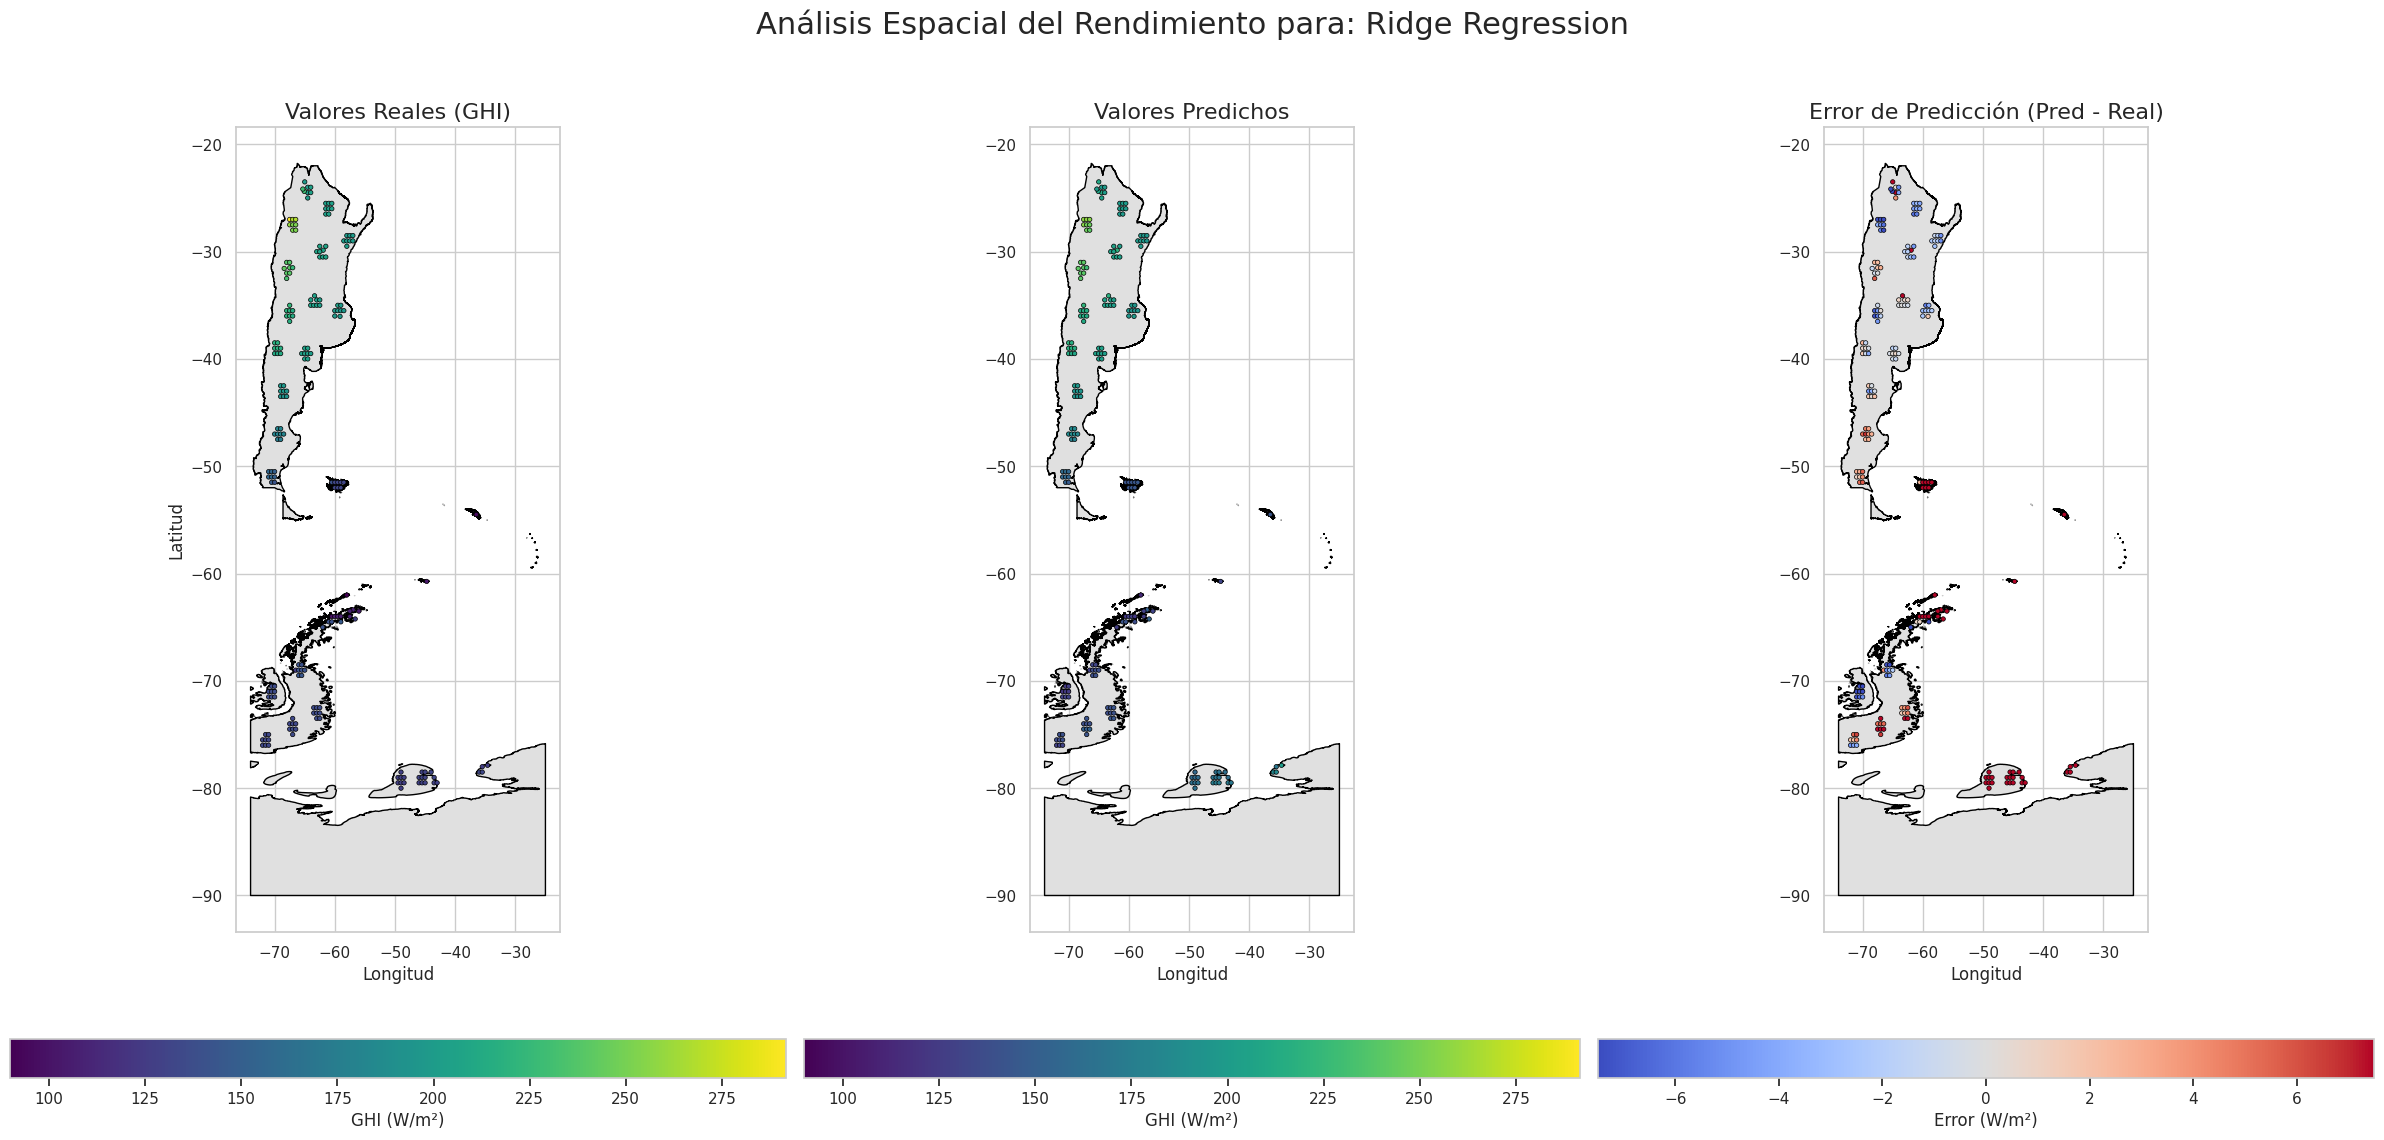


--- Generando mapas para el modelo: Random Forest ---


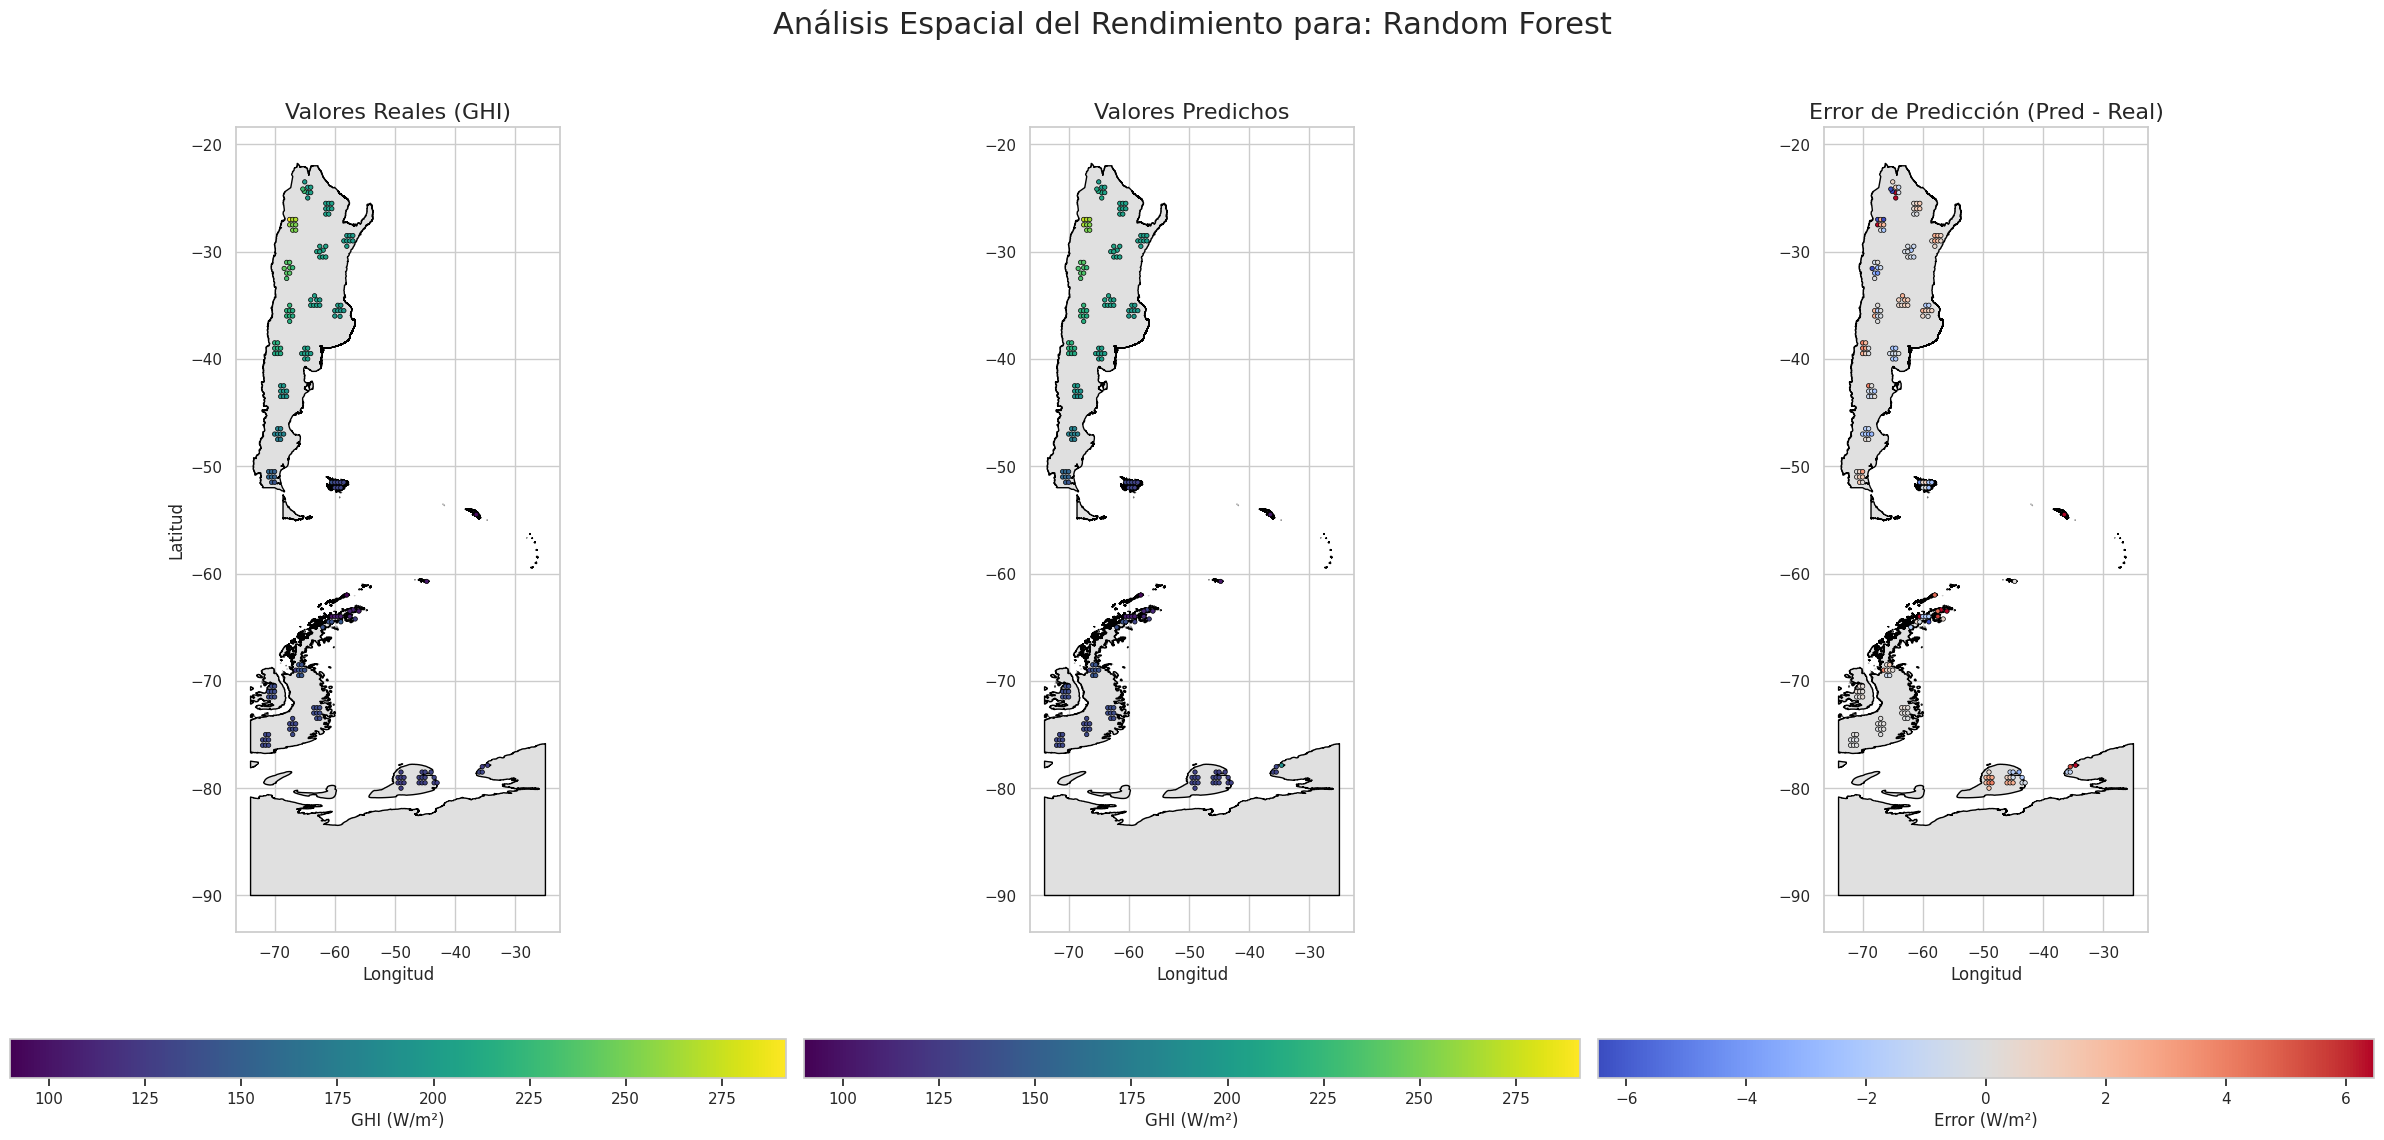


--- Generando mapas para el modelo: LightGBM ---


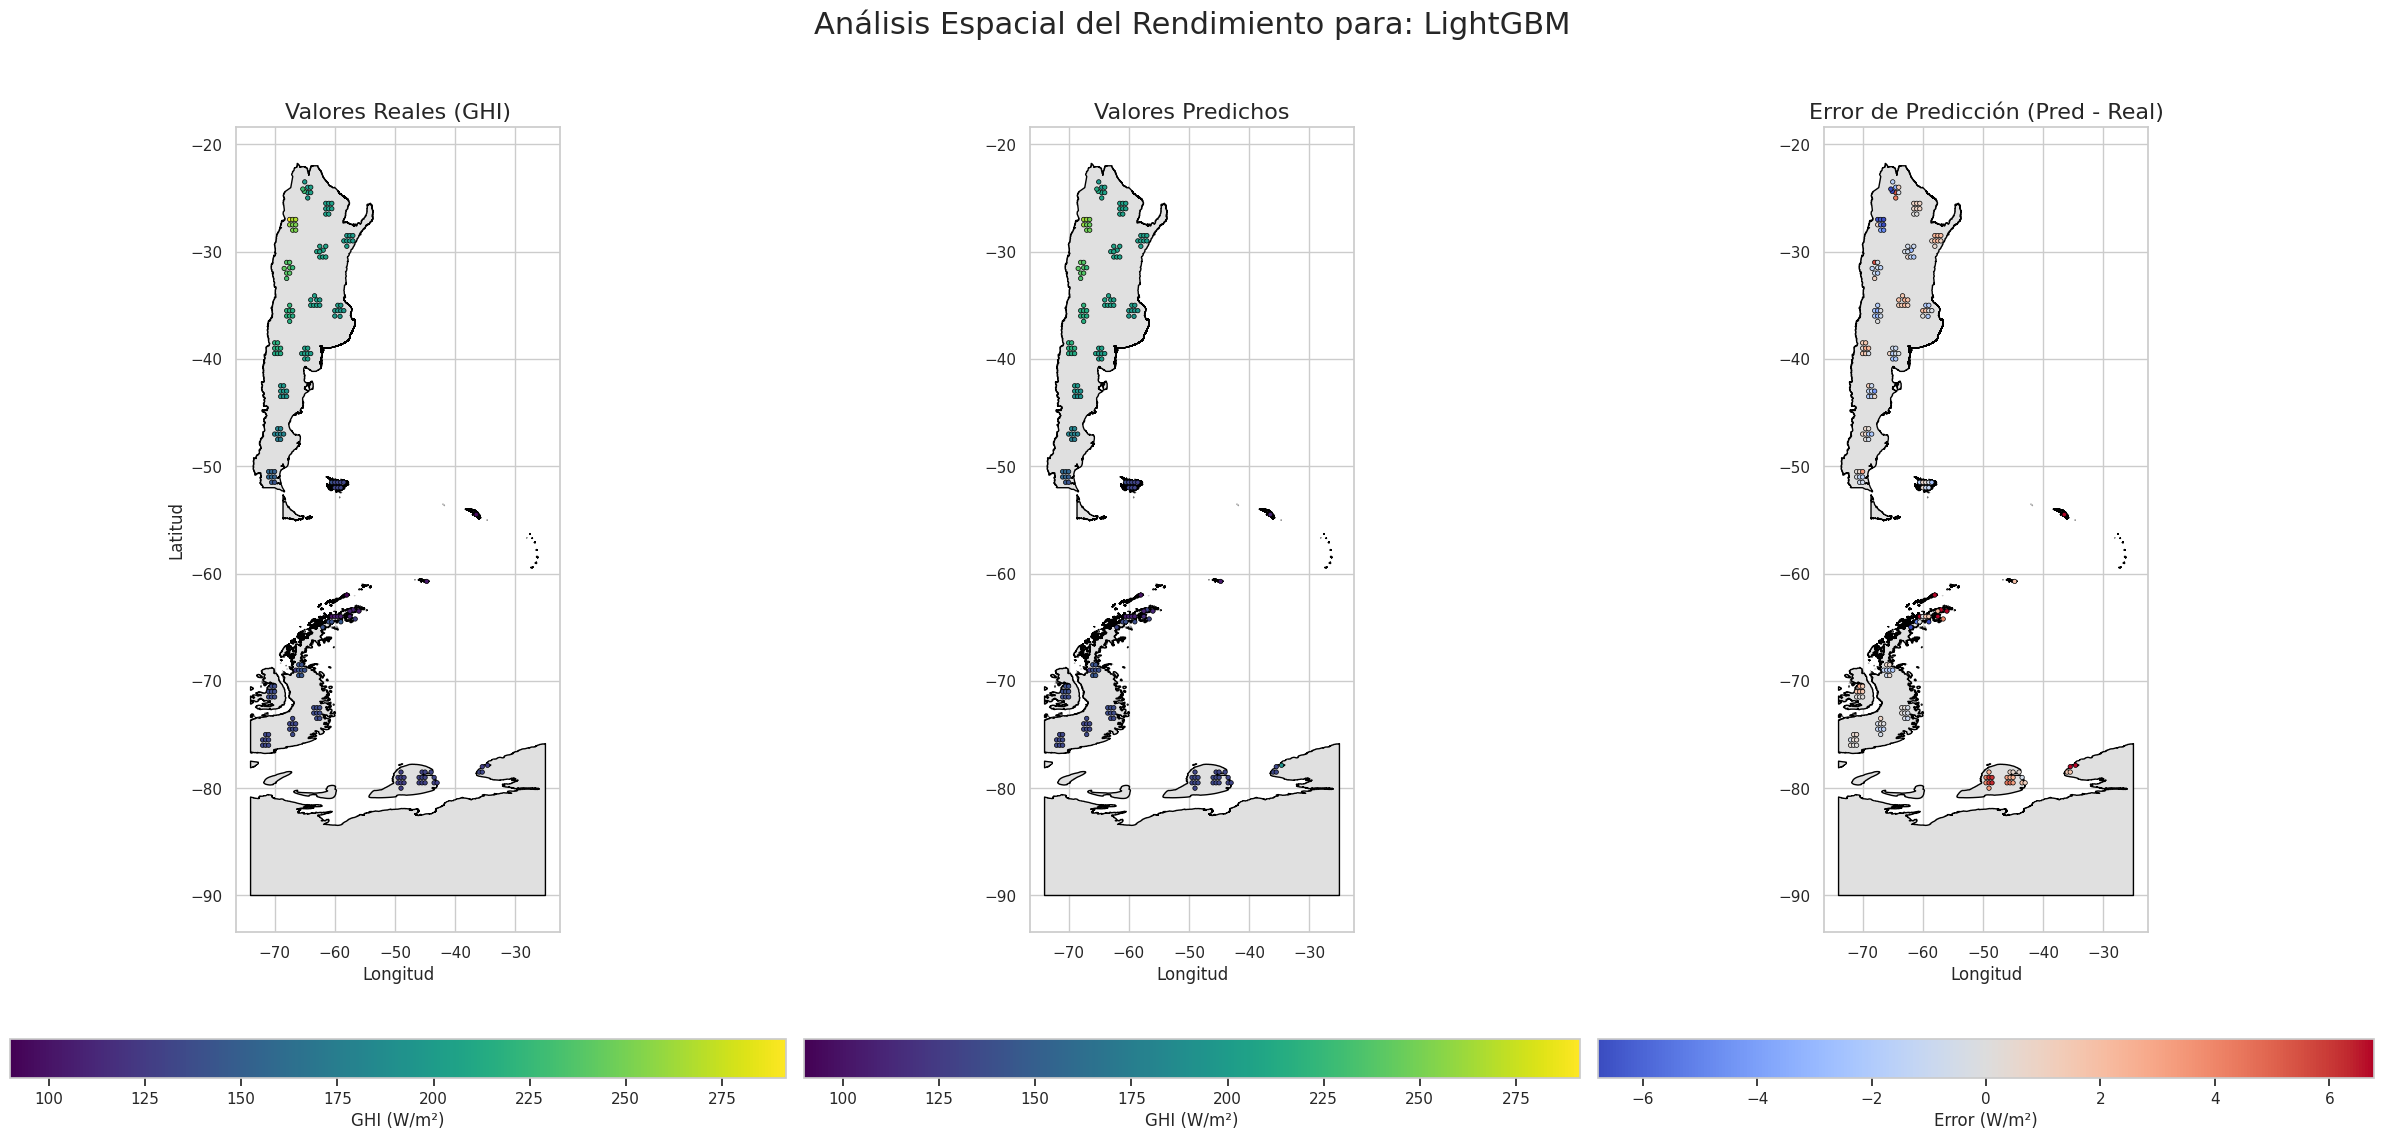


--- Generando mapas para el modelo: Support Vector Regressor (SVR) ---


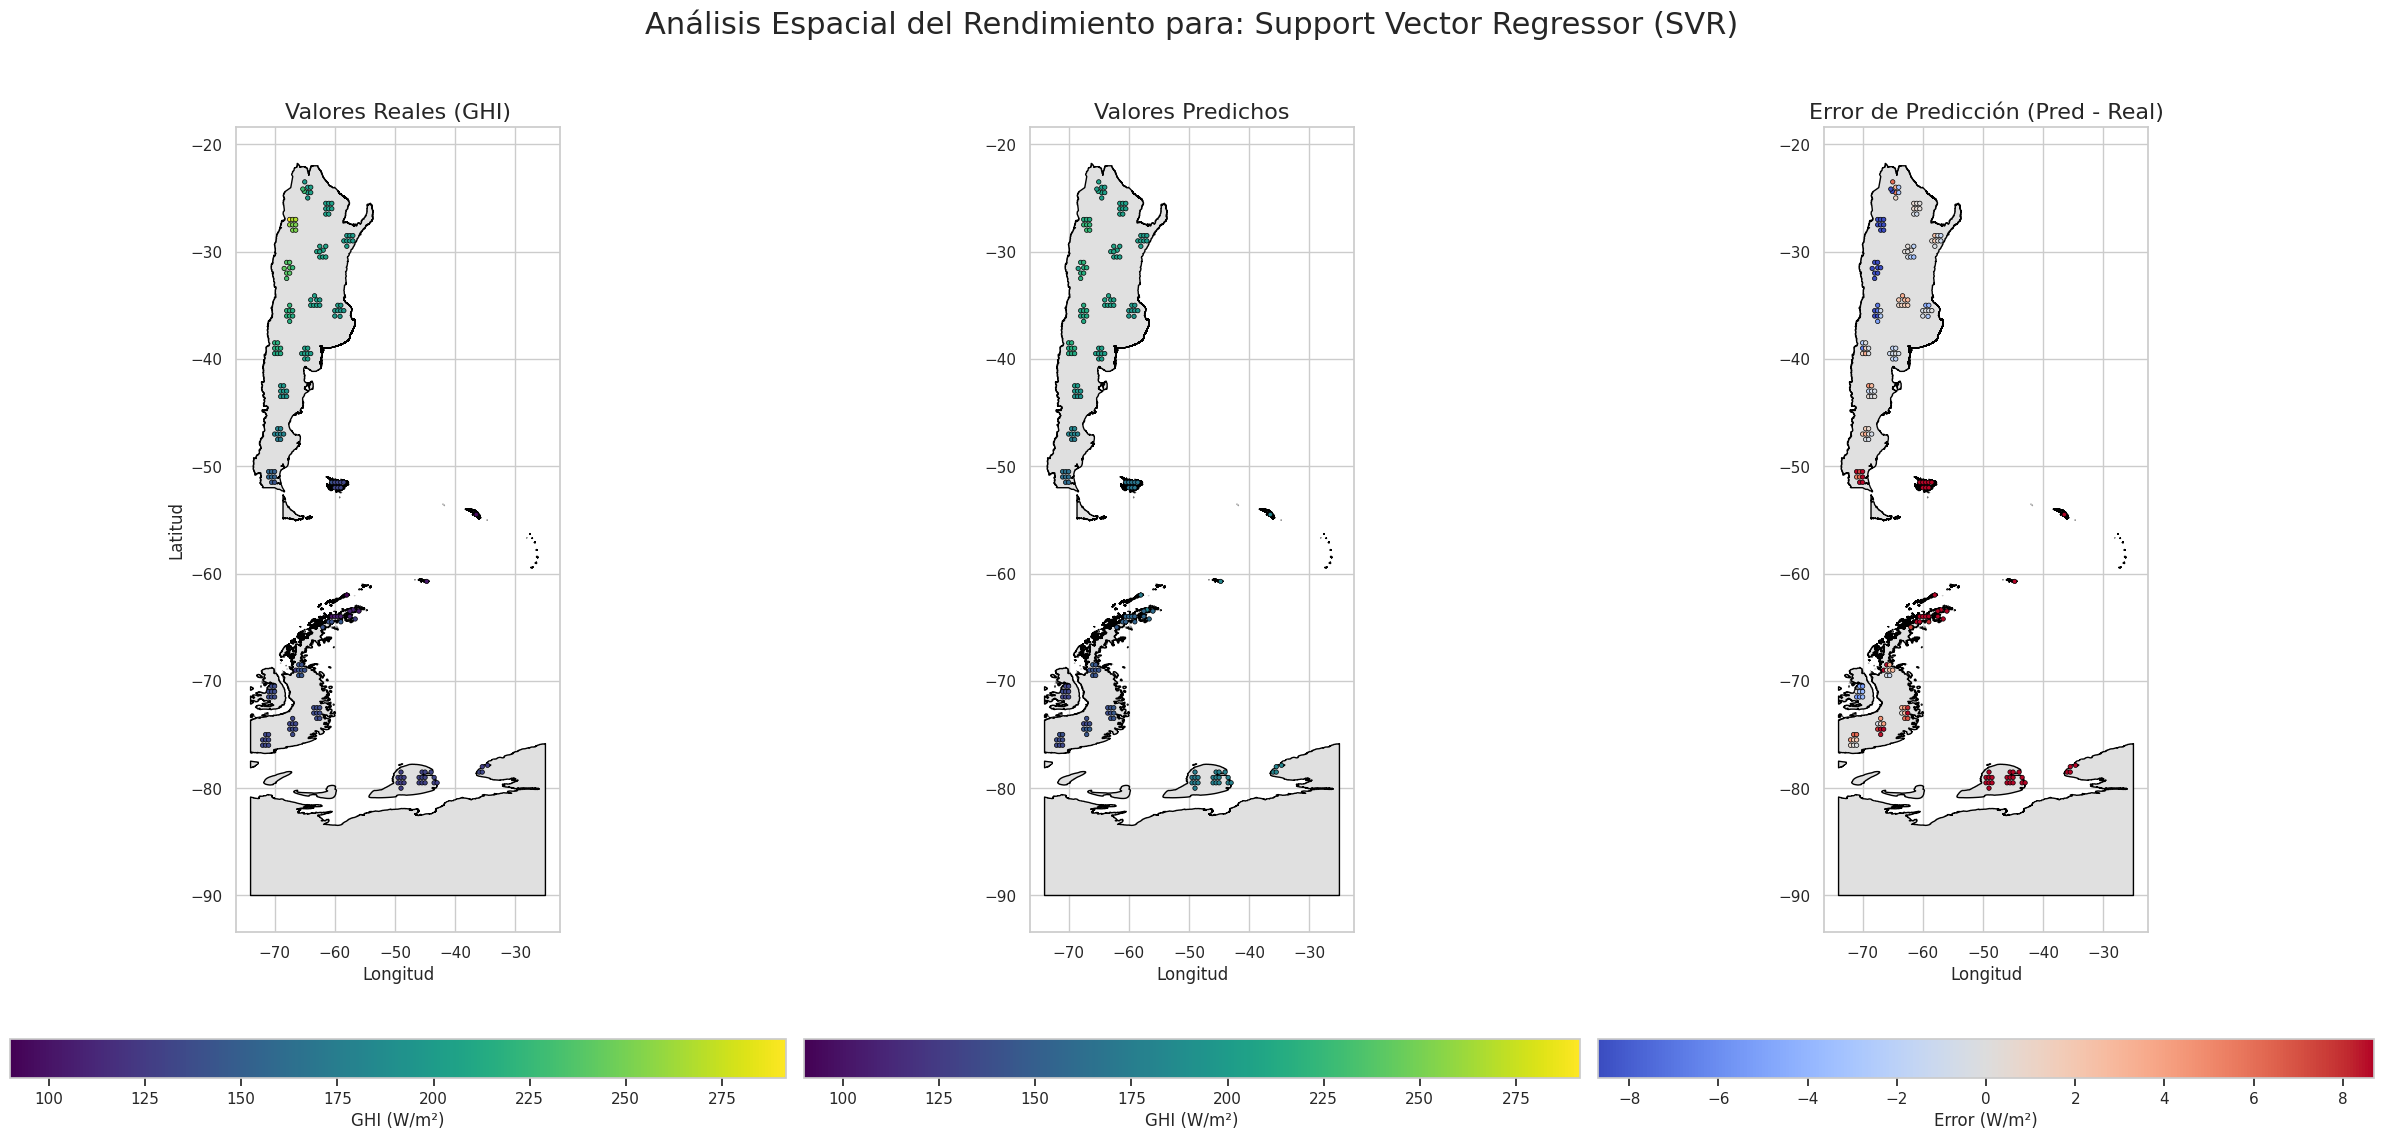

In [125]:
#Se visualizan los resultados de los modelos en un mapa, mostrando las predicciones de GHI y el error de predicción para cada modelo.
print("--- Cargando datos y mapa de fondo (una sola vez) ---")

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
pais_completo = geopandas.read_file(ruta_mapa_provincias).dissolve()
mapa_cargado = True
X_test = pd.read_csv('datos/X_test.csv')

# --- 2. BUCLE PARA VISUALIZAR CADA MODELO ---

# Iteramos sobre los nombres de los modelos y sus correspondientes predicciones
for model_name, predictions in zip(models.keys(), predictions_list):
    
    print(f"\n--- Generando mapas para el modelo: {model_name} ---")

    # Crear un DataFrame con los resultados específicos de este modelo
    df_results_map = pd.DataFrame({
        'latitud': X_test['latitud'],
        'longitud': X_test['longitud'],
        'ghi_real': y_test.values.ravel(),
        'ghi_predicho': predictions
    })

    # Calcular el error para este modelo
    df_results_map['error'] = df_results_map['ghi_predicho'] - df_results_map['ghi_real']

    # --- Creación de los tres mapas para el modelo actual ---
    fig, axes = plt.subplots(1, 3, figsize=(24, 13))
    
    # Título
    fig.suptitle(f'Análisis Espacial del Rendimiento para: {model_name}', fontsize=22)

    # --- MAPA 1: VALORES REALES (GHI) ---
    if mapa_cargado:
        pais_completo.plot(ax=axes[0], facecolor='#E0E0E0', edgecolor='black')
    
    # Sincronizar la escala de color entre el mapa real y el predicho
    vmin = min(df_results_map['ghi_real'].min(), df_results_map['ghi_predicho'].min())
    vmax = max(df_results_map['ghi_real'].max(), df_results_map['ghi_predicho'].max())

    scatter1 = axes[0].scatter(
        df_results_map['longitud'], df_results_map['latitud'], c=df_results_map['ghi_real'],
        cmap='viridis', s=10, edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax
    )
    axes[0].set_title('Valores Reales (GHI)', fontsize=16)
    axes[0].set_xlabel('Longitud')
    axes[0].set_ylabel('Latitud')
    fig.colorbar(scatter1, ax=axes[0], label='GHI (W/m²)', orientation='horizontal', pad=0.1)

    # --- MAPA 2: VALORES PREDICHOS (GHI) ---
    if mapa_cargado:
        pais_completo.plot(ax=axes[1], facecolor='#E0E0E0', edgecolor='black')
        
    scatter2 = axes[1].scatter(
        df_results_map['longitud'], df_results_map['latitud'], c=df_results_map['ghi_predicho'],
        cmap='viridis', s=10, edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax
    )
    axes[1].set_title('Valores Predichos', fontsize=16)
    axes[1].set_xlabel('Longitud')
    axes[1].set_ylabel('')
    fig.colorbar(scatter2, ax=axes[1], label='GHI (W/m²)', orientation='horizontal', pad=0.1)

    # --- MAPA 3: ERROR DE PREDICCIÓN ---
    if mapa_cargado:
        pais_completo.plot(ax=axes[2], facecolor='#E0E0E0', edgecolor='black')
        
    error_cmap = 'coolwarm'
    max_abs_error = df_results_map['error'].abs().max()*0.1

    scatter3 = axes[2].scatter(
        df_results_map['longitud'], df_results_map['latitud'], c=df_results_map['error'],
        cmap=error_cmap, s=10, edgecolor='black', linewidth=0.5,
        vmin=-max_abs_error, vmax=max_abs_error
    )
    axes[2].set_title('Error de Predicción (Pred - Real)', fontsize=16)
    axes[2].set_xlabel('Longitud')
    axes[2].set_ylabel('')
    fig.colorbar(scatter3, ax=axes[2], label='Error (W/m²)', orientation='horizontal', pad=0.1)

    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()
